In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import lpips
import pandas as pd
from tqdm import tqdm
from diffusers import UnCLIPImageVariationPipeline
from torchvision import datasets, transforms

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

/opt/conda/envs/smic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GPU_NUM = 0

device = torch.device(f"cuda:{GPU_NUM}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
dtype = torch.float16 if torch.cuda.is_available() else torch.bfloat16

print(device)

In [3]:
pipe = UnCLIPImageVariationPipeline.from_pretrained(
    "kakaobrain/karlo-v1-alpha-image-variations",
    # "stabilityai/stable-diffusion-2",
    torch_dtype=dtype,
)
pipe.to(device)

Loading pipeline components...:  10%|█         | 1/10 [00:00<00:02,  3.38it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/super_res_first: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/super_res_first.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/decoder: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snaps

UnCLIPImageVariationPipeline {
  "_class_name": "UnCLIPImageVariationPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kakaobrain/karlo-v1-alpha-image-variations",
  "decoder": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "decoder_scheduler": [
    "diffusers",
    "UnCLIPScheduler"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "super_res_first": [
    "diffusers",
    "UNet2DModel"
  ],
  "super_res_last": [
    "diffusers",
    "UNet2DModel"
  ],
  "super_res_scheduler": [
    "diffusers",
    "UnCLIPScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_proj": [
    "unclip",
    "UnCLIPTextProjModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ]
}

In [ ]:
# Kodak 데이터셋 이미지 불러오기
image_dir = './data/k'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
image_paths = [os.path.join(image_dir, f) for f in image_files]

# 이미지 로드
images = []
for path in image_paths:
    img = Image.open(path)
    images.append(img)
print(f"Number of loaded images: {len(images)}")

Number of loaded images: 24


### A. Simple Reconstruction (Encoding and Decoding)

In [6]:
latents = []

for image in tqdm(images):
    with torch.no_grad():  # ✅ 불필요한 메모리 사용 방지
        # 이미지를 텐서로 변환하고 GPU로 이동
        image_tensor = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
        
        # 이미지 임베딩 생성
        image_latent = pipe.image_encoder(image_tensor).image_embeds

        # ✅ detach() 후 CPU로 이동하여 저장
        latents.append(image_latent.detach().cpu())

    # ✅ GPU 메모리 해제
    del image_tensor, image_latent
    torch.cuda.empty_cache()

100%|██████████| 24/24 [00:02<00:00, 10.45it/s]


In [18]:
# latents를 numpy 배열로 변환하여 저장
# latents_np = [l.cpu().numpy() for l in latents]
# np.save('./results/kodak_latents.npy', latents_np)

# 저장된 latents 불러오기
loaded_latents = np.load('./results/landscape_set_latents.npy')
latents = [torch.from_numpy(l) for l in loaded_latents]
latents = [latent.to(device) for latent in latents]

In [19]:
print(f"Number of saved latents: {len(latents)}")
print(f"Shape of each latent: {latents[0].shape}")


Number of saved latents: 4316
Shape of each latent: torch.Size([1, 768])


In [20]:
# 평가 지표를 저장할 리스트 초기화
psnr_values = []
ssim_values = []
lpips_values = []

# LPIPS 모델 초기화
lpips_model = lpips.LPIPS(net='alex').to(device)

for i, latent in enumerate(tqdm(latents, desc="이미지 생성 및 평가", leave=True)):
    output = pipe(image_embeddings=latent, generator=generator)
    generated_image = output.images[0]
    
    # 결과 시각화
    plt.figure(figsize=(10, 5))
    
    # 원본 이미지 표시
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title('Original Image')
    
    # 생성된 이미지 표시
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.axis('off')
    plt.title('Generated Image')
    
    plt.tight_layout()
    
    # 결과 저장
    save_path = f'./results/kodak/comparison_{i:06d}.jpg'
    os.makedirs('./results/kodak', exist_ok=True)
    plt.savefig(save_path)
    plt.close()

    # 평가 지표 계산을 위한 이미지 전처리
    orig_img = np.array(images[i])
    gen_img = np.array(generated_image)
    
    # ✅ 생성된 이미지를 원본 이미지와 같은 크기로 리사이즈
    gen_img = Image.fromarray(gen_img).resize((orig_img.shape[1], orig_img.shape[0]), Image.LANCZOS)
    gen_img = np.array(gen_img)
    
    # PSNR 계산
    psnr_val = psnr(orig_img, gen_img)
    psnr_values.append(psnr_val)
    
    # SSIM 계산
    min_win_size = min(orig_img.shape[0], orig_img.shape[1], 7)
    ssim_val = ssim(orig_img, gen_img, win_size=min_win_size, channel_axis=2)
    ssim_values.append(ssim_val)
    
    # LPIPS 계산
    orig_tensor = torch.from_numpy(orig_img).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    gen_tensor = torch.from_numpy(gen_img).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    with torch.no_grad():
        lpips_val = lpips_model(orig_tensor, gen_tensor).item()
    lpips_values.append(lpips_val)
    
    print(f"Image {i}: PSNR: {psnr_val:.2f}dB, SSIM: {ssim_val:.4f}, LPIPS: {lpips_val:.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/envs/smic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/smic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/conda/envs/smic/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


이미지 생성 및 평가:   0%|          | 1/4316 [00:05<6:54:43,  5.77s/it]

Image 0: PSNR: 12.85dB, SSIM: 0.4523, LPIPS: 0.5822


이미지 생성 및 평가:   0%|          | 2/4316 [00:10<6:18:31,  5.26s/it]

Image 1: PSNR: 11.17dB, SSIM: 0.4430, LPIPS: 0.5654


이미지 생성 및 평가:   0%|          | 3/4316 [00:16<6:33:25,  5.47s/it]

Image 2: PSNR: 11.03dB, SSIM: 0.4188, LPIPS: 0.6107


이미지 생성 및 평가:   0%|          | 4/4316 [00:22<6:52:19,  5.74s/it]

Image 3: PSNR: 13.47dB, SSIM: 0.4852, LPIPS: 0.5050


이미지 생성 및 평가:   0%|          | 5/4316 [00:28<6:58:40,  5.83s/it]

Image 4: PSNR: 9.85dB, SSIM: 0.3769, LPIPS: 0.5508


이미지 생성 및 평가:   0%|          | 6/4316 [00:34<6:53:47,  5.76s/it]

Image 5: PSNR: 13.06dB, SSIM: 0.4084, LPIPS: 0.5734


이미지 생성 및 평가:   0%|          | 7/4316 [00:39<6:36:39,  5.52s/it]

Image 6: PSNR: 11.22dB, SSIM: 0.6372, LPIPS: 0.4323


이미지 생성 및 평가:   0%|          | 8/4316 [00:45<7:04:16,  5.91s/it]

Image 7: PSNR: 11.87dB, SSIM: 0.5450, LPIPS: 0.4466


이미지 생성 및 평가:   0%|          | 9/4316 [00:52<7:20:47,  6.14s/it]

Image 8: PSNR: 9.95dB, SSIM: 0.3778, LPIPS: 0.5939


이미지 생성 및 평가:   0%|          | 10/4316 [00:59<7:41:43,  6.43s/it]

Image 9: PSNR: 15.96dB, SSIM: 0.3438, LPIPS: 0.6776


이미지 생성 및 평가:   0%|          | 11/4316 [01:05<7:31:39,  6.29s/it]

Image 10: PSNR: 13.63dB, SSIM: 0.3418, LPIPS: 0.5961


이미지 생성 및 평가:   0%|          | 12/4316 [01:13<7:58:45,  6.67s/it]

Image 11: PSNR: 10.20dB, SSIM: 0.2204, LPIPS: 0.8033


이미지 생성 및 평가:   0%|          | 13/4316 [01:20<8:09:37,  6.83s/it]

Image 12: PSNR: 13.08dB, SSIM: 0.6945, LPIPS: 0.3176


이미지 생성 및 평가:   0%|          | 14/4316 [01:24<7:19:38,  6.13s/it]

Image 13: PSNR: 10.03dB, SSIM: 0.1357, LPIPS: 0.7498


이미지 생성 및 평가:   0%|          | 15/4316 [01:29<6:51:24,  5.74s/it]

Image 14: PSNR: 9.62dB, SSIM: 0.2222, LPIPS: 0.8789


이미지 생성 및 평가:   0%|          | 16/4316 [01:34<6:30:35,  5.45s/it]

Image 15: PSNR: 12.64dB, SSIM: 0.4004, LPIPS: 0.5646


이미지 생성 및 평가:   0%|          | 17/4316 [01:41<7:01:51,  5.89s/it]

Image 16: PSNR: 12.27dB, SSIM: 0.2832, LPIPS: 0.7255


이미지 생성 및 평가:   0%|          | 18/4316 [01:46<6:50:36,  5.73s/it]

Image 17: PSNR: 10.66dB, SSIM: 0.3149, LPIPS: 0.5799


이미지 생성 및 평가:   0%|          | 19/4316 [01:52<6:40:32,  5.59s/it]

Image 18: PSNR: 13.98dB, SSIM: 0.6107, LPIPS: 0.4968


이미지 생성 및 평가:   0%|          | 20/4316 [01:56<6:17:34,  5.27s/it]

Image 19: PSNR: 11.00dB, SSIM: 0.2557, LPIPS: 0.7387


이미지 생성 및 평가:   0%|          | 21/4316 [02:01<6:09:15,  5.16s/it]

Image 20: PSNR: 9.65dB, SSIM: 0.4612, LPIPS: 0.5136


이미지 생성 및 평가:   1%|          | 22/4316 [02:06<6:00:59,  5.04s/it]

Image 21: PSNR: 10.85dB, SSIM: 0.3465, LPIPS: 0.6896


이미지 생성 및 평가:   1%|          | 23/4316 [02:10<5:48:45,  4.87s/it]

Image 22: PSNR: 10.65dB, SSIM: 0.1811, LPIPS: 0.7922


이미지 생성 및 평가:   1%|          | 24/4316 [02:16<6:07:23,  5.14s/it]

Image 23: PSNR: 12.98dB, SSIM: 0.4763, LPIPS: 0.4192


이미지 생성 및 평가:   1%|          | 25/4316 [02:21<6:11:37,  5.20s/it]

Image 24: PSNR: 10.45dB, SSIM: 0.3557, LPIPS: 0.6654


이미지 생성 및 평가:   1%|          | 26/4316 [02:29<6:54:55,  5.80s/it]

Image 25: PSNR: 14.23dB, SSIM: 0.4951, LPIPS: 0.5199


이미지 생성 및 평가:   1%|          | 27/4316 [02:33<6:36:04,  5.54s/it]

Image 26: PSNR: 11.24dB, SSIM: 0.4442, LPIPS: 0.6058


이미지 생성 및 평가:   1%|          | 28/4316 [02:40<6:50:45,  5.75s/it]

Image 27: PSNR: 11.20dB, SSIM: 0.5142, LPIPS: 0.5499


이미지 생성 및 평가:   1%|          | 29/4316 [02:45<6:44:30,  5.66s/it]

Image 28: PSNR: 11.58dB, SSIM: 0.4880, LPIPS: 0.5244


이미지 생성 및 평가:   1%|          | 30/4316 [02:52<7:06:32,  5.97s/it]

Image 29: PSNR: 12.39dB, SSIM: 0.6682, LPIPS: 0.3972


이미지 생성 및 평가:   1%|          | 31/4316 [02:57<6:47:55,  5.71s/it]

Image 30: PSNR: 8.31dB, SSIM: 0.0960, LPIPS: 0.7700


이미지 생성 및 평가:   1%|          | 32/4316 [03:03<6:54:30,  5.81s/it]

Image 31: PSNR: 9.10dB, SSIM: 0.6183, LPIPS: 0.4541


이미지 생성 및 평가:   1%|          | 33/4316 [03:08<6:41:08,  5.62s/it]

Image 32: PSNR: 12.28dB, SSIM: 0.3896, LPIPS: 0.6881


이미지 생성 및 평가:   1%|          | 34/4316 [03:13<6:28:09,  5.44s/it]

Image 33: PSNR: 10.05dB, SSIM: 0.2215, LPIPS: 0.8133


이미지 생성 및 평가:   1%|          | 35/4316 [03:18<6:12:14,  5.22s/it]

Image 34: PSNR: 13.02dB, SSIM: 0.3897, LPIPS: 0.5819


이미지 생성 및 평가:   1%|          | 36/4316 [03:23<6:10:18,  5.19s/it]

Image 35: PSNR: 12.12dB, SSIM: 0.4616, LPIPS: 0.5818


이미지 생성 및 평가:   1%|          | 37/4316 [03:29<6:24:20,  5.39s/it]

Image 36: PSNR: 9.40dB, SSIM: 0.2785, LPIPS: 0.7709


이미지 생성 및 평가:   1%|          | 38/4316 [03:35<6:48:33,  5.73s/it]

Image 37: PSNR: 13.67dB, SSIM: 0.3936, LPIPS: 0.6204


이미지 생성 및 평가:   1%|          | 39/4316 [03:40<6:30:58,  5.48s/it]

Image 38: PSNR: 12.98dB, SSIM: 0.4479, LPIPS: 0.5101


이미지 생성 및 평가:   1%|          | 40/4316 [03:46<6:37:46,  5.58s/it]

Image 39: PSNR: 11.09dB, SSIM: 0.3740, LPIPS: 0.6859


이미지 생성 및 평가:   1%|          | 41/4316 [03:51<6:20:39,  5.34s/it]

Image 40: PSNR: 7.90dB, SSIM: 0.1300, LPIPS: 0.7737


이미지 생성 및 평가:   1%|          | 42/4316 [03:56<6:07:32,  5.16s/it]

Image 41: PSNR: 10.34dB, SSIM: 0.3262, LPIPS: 0.7417


이미지 생성 및 평가:   1%|          | 43/4316 [04:01<6:05:17,  5.13s/it]

Image 42: PSNR: 13.38dB, SSIM: 0.5346, LPIPS: 0.4384


이미지 생성 및 평가:   1%|          | 44/4316 [04:06<6:03:26,  5.10s/it]

Image 43: PSNR: 12.21dB, SSIM: 0.3025, LPIPS: 0.7182


이미지 생성 및 평가:   1%|          | 45/4316 [04:10<5:46:30,  4.87s/it]

Image 44: PSNR: 9.99dB, SSIM: 0.2600, LPIPS: 0.6152


이미지 생성 및 평가:   1%|          | 46/4316 [04:15<5:46:50,  4.87s/it]

Image 45: PSNR: 10.30dB, SSIM: 0.3519, LPIPS: 0.6587


이미지 생성 및 평가:   1%|          | 47/4316 [04:21<6:22:56,  5.38s/it]

Image 46: PSNR: 11.55dB, SSIM: 0.2744, LPIPS: 0.7325


이미지 생성 및 평가:   1%|          | 48/4316 [04:26<6:06:05,  5.15s/it]

Image 47: PSNR: 9.84dB, SSIM: 0.3328, LPIPS: 0.7247


이미지 생성 및 평가:   1%|          | 49/4316 [04:32<6:12:23,  5.24s/it]

Image 48: PSNR: 10.52dB, SSIM: 0.2243, LPIPS: 0.7744


이미지 생성 및 평가:   1%|          | 50/4316 [04:36<6:04:28,  5.13s/it]

Image 49: PSNR: 15.68dB, SSIM: 0.5650, LPIPS: 0.4458


이미지 생성 및 평가:   1%|          | 51/4316 [04:43<6:33:18,  5.53s/it]

Image 50: PSNR: 14.28dB, SSIM: 0.5924, LPIPS: 0.4275


이미지 생성 및 평가:   1%|          | 52/4316 [04:48<6:23:52,  5.40s/it]

Image 51: PSNR: 11.90dB, SSIM: 0.4298, LPIPS: 0.5396


이미지 생성 및 평가:   1%|          | 53/4316 [04:52<5:57:53,  5.04s/it]

Image 52: PSNR: 11.88dB, SSIM: 0.2456, LPIPS: 0.6726


이미지 생성 및 평가:   1%|▏         | 54/4316 [04:57<5:46:54,  4.88s/it]

Image 53: PSNR: 11.15dB, SSIM: 0.2486, LPIPS: 0.6889


이미지 생성 및 평가:   1%|▏         | 55/4316 [05:03<6:08:10,  5.18s/it]

Image 54: PSNR: 11.66dB, SSIM: 0.3201, LPIPS: 0.6697


이미지 생성 및 평가:   1%|▏         | 56/4316 [05:08<6:10:06,  5.21s/it]

Image 55: PSNR: 11.68dB, SSIM: 0.3164, LPIPS: 0.7035


이미지 생성 및 평가:   1%|▏         | 57/4316 [05:14<6:30:23,  5.50s/it]

Image 56: PSNR: 10.05dB, SSIM: 0.2815, LPIPS: 0.7793


이미지 생성 및 평가:   1%|▏         | 58/4316 [05:19<6:10:50,  5.23s/it]

Image 57: PSNR: 12.77dB, SSIM: 0.4205, LPIPS: 0.6010


이미지 생성 및 평가:   1%|▏         | 59/4316 [05:24<6:11:56,  5.24s/it]

Image 58: PSNR: 8.44dB, SSIM: 0.2934, LPIPS: 0.8041


이미지 생성 및 평가:   1%|▏         | 60/4316 [05:31<6:42:19,  5.67s/it]

Image 59: PSNR: 9.59dB, SSIM: 0.0835, LPIPS: 1.0341


이미지 생성 및 평가:   1%|▏         | 61/4316 [05:35<6:15:04,  5.29s/it]

Image 60: PSNR: 14.01dB, SSIM: 0.6256, LPIPS: 0.3169


이미지 생성 및 평가:   1%|▏         | 62/4316 [05:41<6:27:44,  5.47s/it]

Image 61: PSNR: 7.97dB, SSIM: 0.4155, LPIPS: 0.4723


이미지 생성 및 평가:   1%|▏         | 63/4316 [05:46<6:21:25,  5.38s/it]

Image 62: PSNR: 11.81dB, SSIM: 0.2472, LPIPS: 0.7775


이미지 생성 및 평가:   1%|▏         | 64/4316 [05:51<6:14:32,  5.29s/it]

Image 63: PSNR: 12.33dB, SSIM: 0.4740, LPIPS: 0.5020


이미지 생성 및 평가:   2%|▏         | 65/4316 [05:58<6:41:12,  5.66s/it]

Image 64: PSNR: 12.51dB, SSIM: 0.6432, LPIPS: 0.3512


이미지 생성 및 평가:   2%|▏         | 66/4316 [06:02<6:12:13,  5.26s/it]

Image 65: PSNR: 11.08dB, SSIM: 0.2300, LPIPS: 0.7459


이미지 생성 및 평가:   2%|▏         | 67/4316 [06:06<5:52:45,  4.98s/it]

Image 66: PSNR: 10.55dB, SSIM: 0.2093, LPIPS: 0.6987


이미지 생성 및 평가:   2%|▏         | 68/4316 [06:11<5:45:04,  4.87s/it]

Image 67: PSNR: 12.64dB, SSIM: 0.4664, LPIPS: 0.5882


이미지 생성 및 평가:   2%|▏         | 69/4316 [06:16<5:41:40,  4.83s/it]

Image 68: PSNR: 12.27dB, SSIM: 0.5446, LPIPS: 0.5189


이미지 생성 및 평가:   2%|▏         | 70/4316 [06:21<5:54:30,  5.01s/it]

Image 69: PSNR: 11.19dB, SSIM: 0.2756, LPIPS: 0.7485


이미지 생성 및 평가:   2%|▏         | 71/4316 [06:28<6:31:14,  5.53s/it]

Image 70: PSNR: 10.71dB, SSIM: 0.5449, LPIPS: 0.5487


이미지 생성 및 평가:   2%|▏         | 72/4316 [06:34<6:36:38,  5.61s/it]

Image 71: PSNR: 8.48dB, SSIM: 0.3382, LPIPS: 0.6379


이미지 생성 및 평가:   2%|▏         | 73/4316 [06:39<6:27:36,  5.48s/it]

Image 72: PSNR: 9.99dB, SSIM: 0.6335, LPIPS: 0.4390


이미지 생성 및 평가:   2%|▏         | 74/4316 [06:46<6:53:57,  5.86s/it]

Image 73: PSNR: 15.08dB, SSIM: 0.3992, LPIPS: 0.6326


이미지 생성 및 평가:   2%|▏         | 75/4316 [06:51<6:39:07,  5.65s/it]

Image 74: PSNR: 14.13dB, SSIM: 0.4585, LPIPS: 0.4581


이미지 생성 및 평가:   2%|▏         | 76/4316 [06:56<6:31:53,  5.55s/it]

Image 75: PSNR: 9.37dB, SSIM: 0.2879, LPIPS: 0.6459


이미지 생성 및 평가:   2%|▏         | 77/4316 [07:01<6:11:22,  5.26s/it]

Image 76: PSNR: 9.11dB, SSIM: 0.1860, LPIPS: 0.7563


이미지 생성 및 평가:   2%|▏         | 78/4316 [07:06<6:08:14,  5.21s/it]

Image 77: PSNR: 10.79dB, SSIM: 0.3712, LPIPS: 0.6567


이미지 생성 및 평가:   2%|▏         | 79/4316 [07:11<6:00:34,  5.11s/it]

Image 78: PSNR: 11.88dB, SSIM: 0.4570, LPIPS: 0.6001


이미지 생성 및 평가:   2%|▏         | 80/4316 [07:16<6:04:41,  5.17s/it]

Image 79: PSNR: 12.01dB, SSIM: 0.3075, LPIPS: 0.7183


이미지 생성 및 평가:   2%|▏         | 81/4316 [07:21<6:01:26,  5.12s/it]

Image 80: PSNR: 10.09dB, SSIM: 0.1370, LPIPS: 0.8339


이미지 생성 및 평가:   2%|▏         | 82/4316 [07:25<5:49:32,  4.95s/it]

Image 81: PSNR: 9.70dB, SSIM: 0.2602, LPIPS: 0.5852


이미지 생성 및 평가:   2%|▏         | 83/4316 [07:32<6:27:21,  5.49s/it]

Image 82: PSNR: 8.94dB, SSIM: 0.2515, LPIPS: 0.8109


이미지 생성 및 평가:   2%|▏         | 84/4316 [07:38<6:32:56,  5.57s/it]

Image 83: PSNR: 12.18dB, SSIM: 0.3195, LPIPS: 0.6908


이미지 생성 및 평가:   2%|▏         | 85/4316 [07:44<6:44:19,  5.73s/it]

Image 84: PSNR: 10.96dB, SSIM: 0.1970, LPIPS: 0.7668


이미지 생성 및 평가:   2%|▏         | 86/4316 [07:48<6:12:15,  5.28s/it]

Image 85: PSNR: 10.63dB, SSIM: 0.2773, LPIPS: 0.6765


이미지 생성 및 평가:   2%|▏         | 87/4316 [07:53<6:08:19,  5.23s/it]

Image 86: PSNR: 10.72dB, SSIM: 0.3102, LPIPS: 0.7424


이미지 생성 및 평가:   2%|▏         | 88/4316 [07:58<5:47:06,  4.93s/it]

Image 87: PSNR: 11.03dB, SSIM: 0.2400, LPIPS: 0.7571


이미지 생성 및 평가:   2%|▏         | 89/4316 [08:02<5:44:34,  4.89s/it]

Image 88: PSNR: 11.70dB, SSIM: 0.4690, LPIPS: 0.5478


이미지 생성 및 평가:   2%|▏         | 90/4316 [08:07<5:40:06,  4.83s/it]

Image 89: PSNR: 8.96dB, SSIM: 0.3478, LPIPS: 0.6375


이미지 생성 및 평가:   2%|▏         | 91/4316 [08:12<5:40:58,  4.84s/it]

Image 90: PSNR: 10.50dB, SSIM: 0.5462, LPIPS: 0.5193


이미지 생성 및 평가:   2%|▏         | 92/4316 [08:18<6:08:28,  5.23s/it]

Image 91: PSNR: 14.76dB, SSIM: 0.3774, LPIPS: 0.5758


이미지 생성 및 평가:   2%|▏         | 93/4316 [08:25<6:35:58,  5.63s/it]

Image 92: PSNR: 13.47dB, SSIM: 0.6019, LPIPS: 0.4542


이미지 생성 및 평가:   2%|▏         | 94/4316 [08:31<7:00:50,  5.98s/it]

Image 93: PSNR: 12.70dB, SSIM: 0.3654, LPIPS: 0.6595


이미지 생성 및 평가:   2%|▏         | 95/4316 [08:38<7:05:51,  6.05s/it]

Image 94: PSNR: 10.90dB, SSIM: 0.2347, LPIPS: 0.8786


이미지 생성 및 평가:   2%|▏         | 96/4316 [08:43<6:48:24,  5.81s/it]

Image 95: PSNR: 10.86dB, SSIM: 0.3606, LPIPS: 0.5993


이미지 생성 및 평가:   2%|▏         | 97/4316 [08:48<6:34:19,  5.61s/it]

Image 96: PSNR: 11.17dB, SSIM: 0.5356, LPIPS: 0.4478


이미지 생성 및 평가:   2%|▏         | 98/4316 [08:52<6:05:28,  5.20s/it]

Image 97: PSNR: 8.04dB, SSIM: 0.1703, LPIPS: 0.7365


이미지 생성 및 평가:   2%|▏         | 99/4316 [08:57<5:47:56,  4.95s/it]

Image 98: PSNR: 11.78dB, SSIM: 0.2743, LPIPS: 0.7184


이미지 생성 및 평가:   2%|▏         | 100/4316 [09:01<5:41:02,  4.85s/it]

Image 99: PSNR: 8.38dB, SSIM: 0.2667, LPIPS: 0.6822


이미지 생성 및 평가:   2%|▏         | 101/4316 [09:06<5:39:32,  4.83s/it]

Image 100: PSNR: 11.14dB, SSIM: 0.4438, LPIPS: 0.6340


이미지 생성 및 평가:   2%|▏         | 102/4316 [09:12<6:11:45,  5.29s/it]

Image 101: PSNR: 11.38dB, SSIM: 0.2100, LPIPS: 0.9031


이미지 생성 및 평가:   2%|▏         | 103/4316 [09:18<6:13:57,  5.33s/it]

Image 102: PSNR: 9.70dB, SSIM: 0.3486, LPIPS: 0.6109


이미지 생성 및 평가:   2%|▏         | 104/4316 [09:23<6:04:06,  5.19s/it]

Image 103: PSNR: 8.48dB, SSIM: 0.3347, LPIPS: 0.6596


이미지 생성 및 평가:   2%|▏         | 105/4316 [09:28<6:06:08,  5.22s/it]

Image 104: PSNR: 10.93dB, SSIM: 0.3146, LPIPS: 0.7179


이미지 생성 및 평가:   2%|▏         | 106/4316 [09:34<6:27:48,  5.53s/it]

Image 105: PSNR: 9.31dB, SSIM: 0.4497, LPIPS: 0.6236


이미지 생성 및 평가:   2%|▏         | 107/4316 [09:39<6:09:28,  5.27s/it]

Image 106: PSNR: 9.70dB, SSIM: 0.4277, LPIPS: 0.5215


이미지 생성 및 평가:   3%|▎         | 108/4316 [09:45<6:17:47,  5.39s/it]

Image 107: PSNR: 9.71dB, SSIM: 0.3248, LPIPS: 0.5923


이미지 생성 및 평가:   3%|▎         | 109/4316 [09:49<5:54:25,  5.05s/it]

Image 108: PSNR: 8.71dB, SSIM: 0.1687, LPIPS: 0.6766


이미지 생성 및 평가:   3%|▎         | 110/4316 [09:53<5:41:44,  4.88s/it]

Image 109: PSNR: 11.56dB, SSIM: 0.6076, LPIPS: 0.4035


이미지 생성 및 평가:   3%|▎         | 111/4316 [09:59<6:02:13,  5.17s/it]

Image 110: PSNR: 9.22dB, SSIM: 0.2990, LPIPS: 0.7523


이미지 생성 및 평가:   3%|▎         | 112/4316 [10:04<6:03:05,  5.18s/it]

Image 111: PSNR: 11.78dB, SSIM: 0.3921, LPIPS: 0.6505


이미지 생성 및 평가:   3%|▎         | 113/4316 [10:11<6:26:19,  5.52s/it]

Image 112: PSNR: 16.06dB, SSIM: 0.8427, LPIPS: 0.3123


이미지 생성 및 평가:   3%|▎         | 114/4316 [10:16<6:32:14,  5.60s/it]

Image 113: PSNR: 10.63dB, SSIM: 0.5120, LPIPS: 0.5988


이미지 생성 및 평가:   3%|▎         | 115/4316 [10:22<6:22:33,  5.46s/it]

Image 114: PSNR: 10.11dB, SSIM: 0.3681, LPIPS: 0.6124


이미지 생성 및 평가:   3%|▎         | 116/4316 [10:26<6:06:24,  5.23s/it]

Image 115: PSNR: 16.50dB, SSIM: 0.5309, LPIPS: 0.6078


이미지 생성 및 평가:   3%|▎         | 117/4316 [10:31<5:56:00,  5.09s/it]

Image 116: PSNR: 11.13dB, SSIM: 0.3988, LPIPS: 0.6029


이미지 생성 및 평가:   3%|▎         | 118/4316 [10:36<5:48:29,  4.98s/it]

Image 117: PSNR: 10.48dB, SSIM: 0.5691, LPIPS: 0.4140


이미지 생성 및 평가:   3%|▎         | 119/4316 [10:41<5:48:08,  4.98s/it]

Image 118: PSNR: 12.94dB, SSIM: 0.5150, LPIPS: 0.5264


이미지 생성 및 평가:   3%|▎         | 120/4316 [10:45<5:40:57,  4.88s/it]

Image 119: PSNR: 10.65dB, SSIM: 0.3149, LPIPS: 0.7335


이미지 생성 및 평가:   3%|▎         | 121/4316 [10:50<5:40:55,  4.88s/it]

Image 120: PSNR: 10.91dB, SSIM: 0.7413, LPIPS: 0.2547


이미지 생성 및 평가:   3%|▎         | 122/4316 [10:55<5:47:59,  4.98s/it]

Image 121: PSNR: 13.64dB, SSIM: 0.7028, LPIPS: 0.3569


이미지 생성 및 평가:   3%|▎         | 123/4316 [11:00<5:48:39,  4.99s/it]

Image 122: PSNR: 15.38dB, SSIM: 0.7574, LPIPS: 0.2641


이미지 생성 및 평가:   3%|▎         | 124/4316 [11:05<5:45:08,  4.94s/it]

Image 123: PSNR: 13.72dB, SSIM: 0.6853, LPIPS: 0.3418


이미지 생성 및 평가:   3%|▎         | 125/4316 [11:10<5:46:53,  4.97s/it]

Image 124: PSNR: 9.43dB, SSIM: 0.5010, LPIPS: 0.5451


이미지 생성 및 평가:   3%|▎         | 126/4316 [11:15<5:47:07,  4.97s/it]

Image 125: PSNR: 9.74dB, SSIM: 0.2423, LPIPS: 0.6183


이미지 생성 및 평가:   3%|▎         | 127/4316 [11:20<5:50:08,  5.02s/it]

Image 126: PSNR: 13.07dB, SSIM: 0.5284, LPIPS: 0.5369


이미지 생성 및 평가:   3%|▎         | 128/4316 [11:26<6:07:27,  5.26s/it]

Image 127: PSNR: 13.63dB, SSIM: 0.7161, LPIPS: 0.3236


이미지 생성 및 평가:   3%|▎         | 129/4316 [11:30<5:41:11,  4.89s/it]

Image 128: PSNR: 9.51dB, SSIM: 0.2732, LPIPS: 0.6990


이미지 생성 및 평가:   3%|▎         | 130/4316 [11:37<6:18:54,  5.43s/it]

Image 129: PSNR: 10.00dB, SSIM: 0.5118, LPIPS: 0.4115


이미지 생성 및 평가:   3%|▎         | 131/4316 [11:43<6:22:42,  5.49s/it]

Image 130: PSNR: 15.62dB, SSIM: 0.5908, LPIPS: 0.5209


이미지 생성 및 평가:   3%|▎         | 132/4316 [11:48<6:11:39,  5.33s/it]

Image 131: PSNR: 12.24dB, SSIM: 0.4757, LPIPS: 0.5035


이미지 생성 및 평가:   3%|▎         | 133/4316 [11:53<6:16:09,  5.40s/it]

Image 132: PSNR: 10.04dB, SSIM: 0.2700, LPIPS: 0.6825


이미지 생성 및 평가:   3%|▎         | 134/4316 [12:00<6:52:24,  5.92s/it]

Image 133: PSNR: 13.23dB, SSIM: 0.4157, LPIPS: 0.6601


이미지 생성 및 평가:   3%|▎         | 135/4316 [12:06<6:42:15,  5.77s/it]

Image 134: PSNR: 8.96dB, SSIM: 0.2637, LPIPS: 0.6715


이미지 생성 및 평가:   3%|▎         | 136/4316 [12:12<7:00:12,  6.03s/it]

Image 135: PSNR: 9.47dB, SSIM: 0.0810, LPIPS: 1.0715


이미지 생성 및 평가:   3%|▎         | 137/4316 [12:17<6:40:32,  5.75s/it]

Image 136: PSNR: 9.05dB, SSIM: 0.4027, LPIPS: 0.4748


이미지 생성 및 평가:   3%|▎         | 138/4316 [12:24<6:59:17,  6.02s/it]

Image 137: PSNR: 10.11dB, SSIM: 0.3234, LPIPS: 0.6697


이미지 생성 및 평가:   3%|▎         | 139/4316 [12:29<6:45:50,  5.83s/it]

Image 138: PSNR: 11.64dB, SSIM: 0.3804, LPIPS: 0.6417


이미지 생성 및 평가:   3%|▎         | 140/4316 [12:35<6:29:38,  5.60s/it]

Image 139: PSNR: 11.29dB, SSIM: 0.4190, LPIPS: 0.5122


이미지 생성 및 평가:   3%|▎         | 141/4316 [12:41<6:54:04,  5.95s/it]

Image 140: PSNR: 10.32dB, SSIM: 0.4596, LPIPS: 0.5701


이미지 생성 및 평가:   3%|▎         | 142/4316 [12:47<6:49:35,  5.89s/it]

Image 141: PSNR: 10.87dB, SSIM: 0.4273, LPIPS: 0.5664


이미지 생성 및 평가:   3%|▎         | 143/4316 [12:52<6:27:17,  5.57s/it]

Image 142: PSNR: 9.30dB, SSIM: 0.4934, LPIPS: 0.5534


이미지 생성 및 평가:   3%|▎         | 144/4316 [12:59<7:01:48,  6.07s/it]

Image 143: PSNR: 12.71dB, SSIM: 0.5787, LPIPS: 0.3970


이미지 생성 및 평가:   3%|▎         | 145/4316 [13:04<6:44:57,  5.83s/it]

Image 144: PSNR: 10.35dB, SSIM: 0.2953, LPIPS: 0.7301


이미지 생성 및 평가:   3%|▎         | 146/4316 [13:11<6:53:38,  5.95s/it]

Image 145: PSNR: 15.98dB, SSIM: 0.7574, LPIPS: 0.2374


이미지 생성 및 평가:   3%|▎         | 147/4316 [13:15<6:28:22,  5.59s/it]

Image 146: PSNR: 9.86dB, SSIM: 0.4985, LPIPS: 0.5854


이미지 생성 및 평가:   3%|▎         | 148/4316 [13:20<6:10:11,  5.33s/it]

Image 147: PSNR: 15.88dB, SSIM: 0.5768, LPIPS: 0.4069


이미지 생성 및 평가:   3%|▎         | 149/4316 [13:25<5:59:34,  5.18s/it]

Image 148: PSNR: 9.74dB, SSIM: 0.2328, LPIPS: 0.7122


이미지 생성 및 평가:   3%|▎         | 150/4316 [13:31<6:09:10,  5.32s/it]

Image 149: PSNR: 9.68dB, SSIM: 0.4166, LPIPS: 0.6018


이미지 생성 및 평가:   3%|▎         | 151/4316 [13:37<6:41:05,  5.78s/it]

Image 150: PSNR: 8.05dB, SSIM: 0.2789, LPIPS: 0.6857


이미지 생성 및 평가:   4%|▎         | 152/4316 [13:42<6:26:02,  5.56s/it]

Image 151: PSNR: 10.32dB, SSIM: 0.2720, LPIPS: 0.7200


이미지 생성 및 평가:   4%|▎         | 153/4316 [13:47<5:56:05,  5.13s/it]

Image 152: PSNR: 8.98dB, SSIM: 0.0833, LPIPS: 0.9183


이미지 생성 및 평가:   4%|▎         | 154/4316 [13:52<5:55:00,  5.12s/it]

Image 153: PSNR: 11.52dB, SSIM: 0.3009, LPIPS: 0.6664


이미지 생성 및 평가:   4%|▎         | 155/4316 [13:57<5:52:48,  5.09s/it]

Image 154: PSNR: 7.16dB, SSIM: 0.4124, LPIPS: 0.6255


이미지 생성 및 평가:   4%|▎         | 156/4316 [14:03<6:18:31,  5.46s/it]

Image 155: PSNR: 7.86dB, SSIM: 0.1788, LPIPS: 0.9829


이미지 생성 및 평가:   4%|▎         | 157/4316 [14:08<6:05:23,  5.27s/it]

Image 156: PSNR: 12.81dB, SSIM: 0.5059, LPIPS: 0.4955


이미지 생성 및 평가:   4%|▎         | 158/4316 [14:13<6:06:53,  5.29s/it]

Image 157: PSNR: 10.55dB, SSIM: 0.4289, LPIPS: 0.5312


이미지 생성 및 평가:   4%|▎         | 159/4316 [14:19<6:15:05,  5.41s/it]

Image 158: PSNR: 11.47dB, SSIM: 0.2684, LPIPS: 0.7748


이미지 생성 및 평가:   4%|▎         | 160/4316 [14:24<6:07:07,  5.30s/it]

Image 159: PSNR: 10.25dB, SSIM: 0.5276, LPIPS: 0.5297


이미지 생성 및 평가:   4%|▎         | 161/4316 [14:29<6:03:52,  5.25s/it]

Image 160: PSNR: 8.94dB, SSIM: 0.3993, LPIPS: 0.7112


이미지 생성 및 평가:   4%|▍         | 162/4316 [14:34<6:05:55,  5.29s/it]

Image 161: PSNR: 10.22dB, SSIM: 0.4605, LPIPS: 0.5743


이미지 생성 및 평가:   4%|▍         | 163/4316 [14:39<5:51:12,  5.07s/it]

Image 162: PSNR: 14.11dB, SSIM: 0.7275, LPIPS: 0.3954


이미지 생성 및 평가:   4%|▍         | 164/4316 [14:44<5:46:43,  5.01s/it]

Image 163: PSNR: 10.03dB, SSIM: 0.3647, LPIPS: 0.6619


이미지 생성 및 평가:   4%|▍         | 165/4316 [14:51<6:22:55,  5.53s/it]

Image 164: PSNR: 10.84dB, SSIM: 0.4061, LPIPS: 0.6802


이미지 생성 및 평가:   4%|▍         | 166/4316 [14:56<6:10:29,  5.36s/it]

Image 165: PSNR: 8.97dB, SSIM: 0.3403, LPIPS: 0.7114


이미지 생성 및 평가:   4%|▍         | 167/4316 [15:02<6:40:17,  5.79s/it]

Image 166: PSNR: 12.83dB, SSIM: 0.5313, LPIPS: 0.4176


이미지 생성 및 평가:   4%|▍         | 168/4316 [15:07<6:26:55,  5.60s/it]

Image 167: PSNR: 13.90dB, SSIM: 0.6165, LPIPS: 0.3407


이미지 생성 및 평가:   4%|▍         | 169/4316 [15:14<6:39:29,  5.78s/it]

Image 168: PSNR: 11.23dB, SSIM: 0.3837, LPIPS: 0.7415


이미지 생성 및 평가:   4%|▍         | 170/4316 [15:19<6:25:53,  5.58s/it]

Image 169: PSNR: 8.94dB, SSIM: 0.4052, LPIPS: 0.6534


이미지 생성 및 평가:   4%|▍         | 171/4316 [15:26<6:53:29,  5.99s/it]

Image 170: PSNR: 17.37dB, SSIM: 0.6151, LPIPS: 0.4596


이미지 생성 및 평가:   4%|▍         | 172/4316 [15:31<6:35:52,  5.73s/it]

Image 171: PSNR: 12.06dB, SSIM: 0.3822, LPIPS: 0.6243


이미지 생성 및 평가:   4%|▍         | 173/4316 [15:36<6:22:01,  5.53s/it]

Image 172: PSNR: 9.63dB, SSIM: 0.2324, LPIPS: 0.7897


이미지 생성 및 평가:   4%|▍         | 174/4316 [15:41<6:09:35,  5.35s/it]

Image 173: PSNR: 10.50dB, SSIM: 0.4526, LPIPS: 0.5400


이미지 생성 및 평가:   4%|▍         | 175/4316 [15:46<5:54:49,  5.14s/it]

Image 174: PSNR: 9.72dB, SSIM: 0.0990, LPIPS: 0.6997


이미지 생성 및 평가:   4%|▍         | 176/4316 [15:50<5:48:57,  5.06s/it]

Image 175: PSNR: 10.74dB, SSIM: 0.4527, LPIPS: 0.5437


이미지 생성 및 평가:   4%|▍         | 177/4316 [15:55<5:45:27,  5.01s/it]

Image 176: PSNR: 11.30dB, SSIM: 0.5369, LPIPS: 0.4548


이미지 생성 및 평가:   4%|▍         | 178/4316 [16:00<5:33:56,  4.84s/it]

Image 177: PSNR: 8.84dB, SSIM: 0.3954, LPIPS: 0.5314


이미지 생성 및 평가:   4%|▍         | 179/4316 [16:05<5:39:08,  4.92s/it]

Image 178: PSNR: 9.92dB, SSIM: 0.3185, LPIPS: 0.7219


이미지 생성 및 평가:   4%|▍         | 180/4316 [16:09<5:32:20,  4.82s/it]

Image 179: PSNR: 12.43dB, SSIM: 0.1970, LPIPS: 0.7157


이미지 생성 및 평가:   4%|▍         | 181/4316 [16:15<5:51:51,  5.11s/it]

Image 180: PSNR: 13.16dB, SSIM: 0.5848, LPIPS: 0.4496


이미지 생성 및 평가:   4%|▍         | 182/4316 [16:20<5:41:16,  4.95s/it]

Image 181: PSNR: 10.65dB, SSIM: 0.4587, LPIPS: 0.4472


이미지 생성 및 평가:   4%|▍         | 183/4316 [16:25<5:42:42,  4.98s/it]

Image 182: PSNR: 14.73dB, SSIM: 0.4179, LPIPS: 0.5830


이미지 생성 및 평가:   4%|▍         | 184/4316 [16:32<6:19:07,  5.51s/it]

Image 183: PSNR: 15.02dB, SSIM: 0.5596, LPIPS: 0.4211


이미지 생성 및 평가:   4%|▍         | 185/4316 [16:37<6:23:26,  5.57s/it]

Image 184: PSNR: 12.18dB, SSIM: 0.6407, LPIPS: 0.4049


이미지 생성 및 평가:   4%|▍         | 186/4316 [16:42<6:12:49,  5.42s/it]

Image 185: PSNR: 13.28dB, SSIM: 0.3619, LPIPS: 0.6381


이미지 생성 및 평가:   4%|▍         | 187/4316 [16:48<6:22:52,  5.56s/it]

Image 186: PSNR: 8.32dB, SSIM: 0.2863, LPIPS: 0.6947


이미지 생성 및 평가:   4%|▍         | 188/4316 [16:55<6:43:39,  5.87s/it]

Image 187: PSNR: 11.44dB, SSIM: 0.4108, LPIPS: 0.5998


이미지 생성 및 평가:   4%|▍         | 189/4316 [17:00<6:24:54,  5.60s/it]

Image 188: PSNR: 9.34dB, SSIM: 0.2979, LPIPS: 0.6710


이미지 생성 및 평가:   4%|▍         | 190/4316 [17:06<6:47:00,  5.92s/it]

Image 189: PSNR: 8.75dB, SSIM: 0.4817, LPIPS: 0.4596


이미지 생성 및 평가:   4%|▍         | 191/4316 [17:12<6:36:28,  5.77s/it]

Image 190: PSNR: 8.56dB, SSIM: 0.3069, LPIPS: 0.6330


이미지 생성 및 평가:   4%|▍         | 192/4316 [17:17<6:32:36,  5.71s/it]

Image 191: PSNR: 11.16dB, SSIM: 0.3101, LPIPS: 0.6886


이미지 생성 및 평가:   4%|▍         | 193/4316 [17:25<7:09:16,  6.25s/it]

Image 192: PSNR: 10.36dB, SSIM: 0.3922, LPIPS: 0.5751


이미지 생성 및 평가:   4%|▍         | 194/4316 [17:31<6:59:02,  6.10s/it]

Image 193: PSNR: 10.54dB, SSIM: 0.5252, LPIPS: 0.5074


이미지 생성 및 평가:   5%|▍         | 195/4316 [17:37<7:00:13,  6.12s/it]

Image 194: PSNR: 11.02dB, SSIM: 0.3376, LPIPS: 0.7037


이미지 생성 및 평가:   5%|▍         | 196/4316 [17:41<6:15:34,  5.47s/it]

Image 195: PSNR: 15.79dB, SSIM: 0.5386, LPIPS: 0.3760


이미지 생성 및 평가:   5%|▍         | 197/4316 [17:46<6:02:19,  5.28s/it]

Image 196: PSNR: 9.84dB, SSIM: 0.3357, LPIPS: 0.6521


이미지 생성 및 평가:   5%|▍         | 198/4316 [17:52<6:17:32,  5.50s/it]

Image 197: PSNR: 10.10dB, SSIM: 0.4778, LPIPS: 0.5391


이미지 생성 및 평가:   5%|▍         | 199/4316 [17:57<6:06:28,  5.34s/it]

Image 198: PSNR: 9.31dB, SSIM: 0.2255, LPIPS: 0.7069


이미지 생성 및 평가:   5%|▍         | 200/4316 [18:02<6:12:27,  5.43s/it]

Image 199: PSNR: 10.88dB, SSIM: 0.4996, LPIPS: 0.5971


이미지 생성 및 평가:   5%|▍         | 201/4316 [18:08<6:18:27,  5.52s/it]

Image 200: PSNR: 15.38dB, SSIM: 0.6198, LPIPS: 0.4243


이미지 생성 및 평가:   5%|▍         | 202/4316 [18:13<6:08:25,  5.37s/it]

Image 201: PSNR: 14.29dB, SSIM: 0.3099, LPIPS: 0.6829


이미지 생성 및 평가:   5%|▍         | 203/4316 [18:18<5:56:37,  5.20s/it]

Image 202: PSNR: 10.39dB, SSIM: 0.4427, LPIPS: 0.5613


이미지 생성 및 평가:   5%|▍         | 204/4316 [18:22<5:41:01,  4.98s/it]

Image 203: PSNR: 11.41dB, SSIM: 0.3386, LPIPS: 0.6465


이미지 생성 및 평가:   5%|▍         | 205/4316 [18:28<5:58:09,  5.23s/it]

Image 204: PSNR: 10.12dB, SSIM: 0.2584, LPIPS: 0.6863


이미지 생성 및 평가:   5%|▍         | 206/4316 [18:37<7:03:28,  6.18s/it]

Image 205: PSNR: 10.72dB, SSIM: 0.2072, LPIPS: 0.7500


이미지 생성 및 평가:   5%|▍         | 207/4316 [18:42<6:47:54,  5.96s/it]

Image 206: PSNR: 13.11dB, SSIM: 0.5667, LPIPS: 0.3824


이미지 생성 및 평가:   5%|▍         | 208/4316 [18:49<7:00:51,  6.15s/it]

Image 207: PSNR: 8.51dB, SSIM: 0.2829, LPIPS: 0.8026


이미지 생성 및 평가:   5%|▍         | 209/4316 [18:56<7:27:27,  6.54s/it]

Image 208: PSNR: 11.81dB, SSIM: 0.0902, LPIPS: 0.9226


이미지 생성 및 평가:   5%|▍         | 210/4316 [19:03<7:44:23,  6.79s/it]

Image 209: PSNR: 11.96dB, SSIM: 0.5139, LPIPS: 0.5537


이미지 생성 및 평가:   5%|▍         | 211/4316 [19:09<7:30:23,  6.58s/it]

Image 210: PSNR: 10.59dB, SSIM: 0.0805, LPIPS: 0.9217


이미지 생성 및 평가:   5%|▍         | 212/4316 [19:15<7:04:39,  6.21s/it]

Image 211: PSNR: 11.34dB, SSIM: 0.2519, LPIPS: 0.7630


이미지 생성 및 평가:   5%|▍         | 213/4316 [19:22<7:21:34,  6.46s/it]

Image 212: PSNR: 11.50dB, SSIM: 0.3470, LPIPS: 0.6376


이미지 생성 및 평가:   5%|▍         | 214/4316 [19:27<6:53:43,  6.05s/it]

Image 213: PSNR: 10.83dB, SSIM: 0.4009, LPIPS: 0.6722


이미지 생성 및 평가:   5%|▍         | 215/4316 [19:33<6:49:49,  6.00s/it]

Image 214: PSNR: 10.19dB, SSIM: 0.5479, LPIPS: 0.5098


이미지 생성 및 평가:   5%|▌         | 216/4316 [19:38<6:29:28,  5.70s/it]

Image 215: PSNR: 11.31dB, SSIM: 0.4428, LPIPS: 0.5459


이미지 생성 및 평가:   5%|▌         | 217/4316 [19:43<6:18:40,  5.54s/it]

Image 216: PSNR: 9.33dB, SSIM: 0.2693, LPIPS: 0.6568


이미지 생성 및 평가:   5%|▌         | 218/4316 [19:49<6:28:41,  5.69s/it]

Image 217: PSNR: 12.04dB, SSIM: 0.5576, LPIPS: 0.5724


이미지 생성 및 평가:   5%|▌         | 219/4316 [19:54<6:17:28,  5.53s/it]

Image 218: PSNR: 11.64dB, SSIM: 0.5400, LPIPS: 0.5181


이미지 생성 및 평가:   5%|▌         | 220/4316 [20:00<6:26:08,  5.66s/it]

Image 219: PSNR: 9.92dB, SSIM: 0.4525, LPIPS: 0.5448


이미지 생성 및 평가:   5%|▌         | 221/4316 [20:05<6:13:04,  5.47s/it]

Image 220: PSNR: 10.58dB, SSIM: 0.6226, LPIPS: 0.3985


이미지 생성 및 평가:   5%|▌         | 222/4316 [20:11<6:20:03,  5.57s/it]

Image 221: PSNR: 11.46dB, SSIM: 0.4348, LPIPS: 0.7007


이미지 생성 및 평가:   5%|▌         | 223/4316 [20:16<6:11:12,  5.44s/it]

Image 222: PSNR: 10.95dB, SSIM: 0.4054, LPIPS: 0.6063


이미지 생성 및 평가:   5%|▌         | 224/4316 [20:21<5:58:42,  5.26s/it]

Image 223: PSNR: 11.40dB, SSIM: 0.6549, LPIPS: 0.3893


이미지 생성 및 평가:   5%|▌         | 225/4316 [20:26<6:02:30,  5.32s/it]

Image 224: PSNR: 10.55dB, SSIM: 0.2319, LPIPS: 0.6811


이미지 생성 및 평가:   5%|▌         | 226/4316 [20:32<6:14:55,  5.50s/it]

Image 225: PSNR: 12.74dB, SSIM: 0.6711, LPIPS: 0.3781


이미지 생성 및 평가:   5%|▌         | 227/4316 [20:39<6:39:04,  5.86s/it]

Image 226: PSNR: 9.16dB, SSIM: 0.3990, LPIPS: 0.6457


이미지 생성 및 평가:   5%|▌         | 228/4316 [20:44<6:28:52,  5.71s/it]

Image 227: PSNR: 14.84dB, SSIM: 0.5952, LPIPS: 0.4465


이미지 생성 및 평가:   5%|▌         | 229/4316 [20:50<6:26:20,  5.67s/it]

Image 228: PSNR: 12.06dB, SSIM: 0.7514, LPIPS: 0.2901


이미지 생성 및 평가:   5%|▌         | 230/4316 [20:55<6:10:13,  5.44s/it]

Image 229: PSNR: 9.92dB, SSIM: 0.4440, LPIPS: 0.6030


이미지 생성 및 평가:   5%|▌         | 231/4316 [20:59<5:42:50,  5.04s/it]

Image 230: PSNR: 7.56dB, SSIM: 0.1093, LPIPS: 0.7551


이미지 생성 및 평가:   5%|▌         | 232/4316 [21:05<5:58:56,  5.27s/it]

Image 231: PSNR: 9.11dB, SSIM: 0.2953, LPIPS: 0.7568


이미지 생성 및 평가:   5%|▌         | 233/4316 [21:11<6:27:56,  5.70s/it]

Image 232: PSNR: 11.96dB, SSIM: 0.4331, LPIPS: 0.5865


이미지 생성 및 평가:   5%|▌         | 234/4316 [21:19<6:59:32,  6.17s/it]

Image 233: PSNR: 13.48dB, SSIM: 0.4283, LPIPS: 0.6421


이미지 생성 및 평가:   5%|▌         | 235/4316 [21:23<6:25:28,  5.67s/it]

Image 234: PSNR: 13.53dB, SSIM: 0.3463, LPIPS: 0.5884


이미지 생성 및 평가:   5%|▌         | 236/4316 [21:29<6:19:45,  5.58s/it]

Image 235: PSNR: 9.68dB, SSIM: 0.3820, LPIPS: 0.5773


이미지 생성 및 평가:   5%|▌         | 237/4316 [21:34<6:13:28,  5.49s/it]

Image 236: PSNR: 12.76dB, SSIM: 0.2241, LPIPS: 0.7742


이미지 생성 및 평가:   6%|▌         | 238/4316 [21:38<5:51:16,  5.17s/it]

Image 237: PSNR: 9.88dB, SSIM: 0.3725, LPIPS: 0.5026


이미지 생성 및 평가:   6%|▌         | 239/4316 [21:43<5:35:56,  4.94s/it]

Image 238: PSNR: 12.41dB, SSIM: 0.5212, LPIPS: 0.4734


이미지 생성 및 평가:   6%|▌         | 240/4316 [21:47<5:25:44,  4.79s/it]

Image 239: PSNR: 10.42dB, SSIM: 0.2095, LPIPS: 0.6513


이미지 생성 및 평가:   6%|▌         | 241/4316 [21:53<5:46:14,  5.10s/it]

Image 240: PSNR: 11.31dB, SSIM: 0.3287, LPIPS: 0.7156


이미지 생성 및 평가:   6%|▌         | 242/4316 [21:58<5:52:14,  5.19s/it]

Image 241: PSNR: 14.16dB, SSIM: 0.3760, LPIPS: 0.6841


이미지 생성 및 평가:   6%|▌         | 243/4316 [22:03<5:44:39,  5.08s/it]

Image 242: PSNR: 11.38dB, SSIM: 0.3633, LPIPS: 0.6995


이미지 생성 및 평가:   6%|▌         | 244/4316 [22:09<5:55:48,  5.24s/it]

Image 243: PSNR: 13.21dB, SSIM: 0.3644, LPIPS: 0.6842


이미지 생성 및 평가:   6%|▌         | 245/4316 [22:13<5:40:46,  5.02s/it]

Image 244: PSNR: 10.14dB, SSIM: 0.4664, LPIPS: 0.5642


이미지 생성 및 평가:   6%|▌         | 246/4316 [22:20<6:20:44,  5.61s/it]

Image 245: PSNR: 10.40dB, SSIM: 0.1618, LPIPS: 0.9662


이미지 생성 및 평가:   6%|▌         | 247/4316 [22:27<6:40:36,  5.91s/it]

Image 246: PSNR: 14.27dB, SSIM: 0.5216, LPIPS: 0.5102


이미지 생성 및 평가:   6%|▌         | 248/4316 [22:32<6:17:22,  5.57s/it]

Image 247: PSNR: 11.40dB, SSIM: 0.4195, LPIPS: 0.5147


이미지 생성 및 평가:   6%|▌         | 249/4316 [22:37<6:09:07,  5.45s/it]

Image 248: PSNR: 13.96dB, SSIM: 0.7608, LPIPS: 0.2911


이미지 생성 및 평가:   6%|▌         | 250/4316 [22:42<6:04:27,  5.38s/it]

Image 249: PSNR: 12.58dB, SSIM: 0.3236, LPIPS: 0.6814


이미지 생성 및 평가:   6%|▌         | 251/4316 [22:48<6:20:16,  5.61s/it]

Image 250: PSNR: 10.57dB, SSIM: 0.3447, LPIPS: 0.5913


이미지 생성 및 평가:   6%|▌         | 252/4316 [22:54<6:27:23,  5.72s/it]

Image 251: PSNR: 11.83dB, SSIM: 0.4676, LPIPS: 0.4980


이미지 생성 및 평가:   6%|▌         | 253/4316 [23:02<7:09:32,  6.34s/it]

Image 252: PSNR: 9.46dB, SSIM: 0.4102, LPIPS: 0.6989


이미지 생성 및 평가:   6%|▌         | 254/4316 [23:08<6:56:05,  6.15s/it]

Image 253: PSNR: 17.80dB, SSIM: 0.6407, LPIPS: 0.4251


이미지 생성 및 평가:   6%|▌         | 255/4316 [23:13<6:36:19,  5.86s/it]

Image 254: PSNR: 10.92dB, SSIM: 0.4269, LPIPS: 0.5840


이미지 생성 및 평가:   6%|▌         | 256/4316 [23:19<6:42:51,  5.95s/it]

Image 255: PSNR: 8.41dB, SSIM: 0.2436, LPIPS: 0.7291


이미지 생성 및 평가:   6%|▌         | 257/4316 [23:24<6:31:44,  5.79s/it]

Image 256: PSNR: 12.04dB, SSIM: 0.3267, LPIPS: 0.5983


이미지 생성 및 평가:   6%|▌         | 258/4316 [23:30<6:19:19,  5.61s/it]

Image 257: PSNR: 10.63dB, SSIM: 0.3071, LPIPS: 0.7143


이미지 생성 및 평가:   6%|▌         | 259/4316 [23:35<6:12:50,  5.51s/it]

Image 258: PSNR: 10.58dB, SSIM: 0.3113, LPIPS: 0.7757


이미지 생성 및 평가:   6%|▌         | 260/4316 [23:41<6:32:42,  5.81s/it]

Image 259: PSNR: 10.59dB, SSIM: 0.5341, LPIPS: 0.4791


이미지 생성 및 평가:   6%|▌         | 261/4316 [23:47<6:25:29,  5.70s/it]

Image 260: PSNR: 10.29dB, SSIM: 0.5085, LPIPS: 0.4594


이미지 생성 및 평가:   6%|▌         | 262/4316 [23:51<5:54:36,  5.25s/it]

Image 261: PSNR: 9.94dB, SSIM: 0.1252, LPIPS: 0.6348


이미지 생성 및 평가:   6%|▌         | 263/4316 [23:57<6:06:28,  5.43s/it]

Image 262: PSNR: 10.66dB, SSIM: 0.5131, LPIPS: 0.5289


이미지 생성 및 평가:   6%|▌         | 264/4316 [24:02<5:54:27,  5.25s/it]

Image 263: PSNR: 11.69dB, SSIM: 0.4067, LPIPS: 0.4964


이미지 생성 및 평가:   6%|▌         | 265/4316 [24:07<5:47:55,  5.15s/it]

Image 264: PSNR: 9.81dB, SSIM: 0.0379, LPIPS: 0.8163


이미지 생성 및 평가:   6%|▌         | 266/4316 [24:11<5:37:42,  5.00s/it]

Image 265: PSNR: 11.32dB, SSIM: 0.4335, LPIPS: 0.5825


이미지 생성 및 평가:   6%|▌         | 267/4316 [24:18<6:00:55,  5.35s/it]

Image 266: PSNR: 12.92dB, SSIM: 0.5649, LPIPS: 0.3294


이미지 생성 및 평가:   6%|▌         | 268/4316 [24:24<6:29:50,  5.78s/it]

Image 267: PSNR: 12.15dB, SSIM: 0.3219, LPIPS: 0.7612


이미지 생성 및 평가:   6%|▌         | 269/4316 [24:29<6:15:37,  5.57s/it]

Image 268: PSNR: 12.36dB, SSIM: 0.5293, LPIPS: 0.5282


이미지 생성 및 평가:   6%|▋         | 270/4316 [24:36<6:28:21,  5.76s/it]

Image 269: PSNR: 10.23dB, SSIM: 0.4783, LPIPS: 0.5834


이미지 생성 및 평가:   6%|▋         | 271/4316 [24:42<6:32:19,  5.82s/it]

Image 270: PSNR: 9.76dB, SSIM: 0.1902, LPIPS: 0.8024


이미지 생성 및 평가:   6%|▋         | 272/4316 [24:48<6:42:17,  5.97s/it]

Image 271: PSNR: 10.75dB, SSIM: 0.6085, LPIPS: 0.5007


이미지 생성 및 평가:   6%|▋         | 273/4316 [24:54<6:47:35,  6.05s/it]

Image 272: PSNR: 10.14dB, SSIM: 0.4005, LPIPS: 0.6768


이미지 생성 및 평가:   6%|▋         | 274/4316 [24:59<6:28:05,  5.76s/it]

Image 273: PSNR: 11.90dB, SSIM: 0.2774, LPIPS: 0.6981


이미지 생성 및 평가:   6%|▋         | 275/4316 [25:05<6:35:10,  5.87s/it]

Image 274: PSNR: 14.88dB, SSIM: 0.7210, LPIPS: 0.3178


이미지 생성 및 평가:   6%|▋         | 276/4316 [25:11<6:23:29,  5.70s/it]

Image 275: PSNR: 9.99dB, SSIM: 0.4343, LPIPS: 0.4928


이미지 생성 및 평가:   6%|▋         | 277/4316 [25:16<6:19:05,  5.63s/it]

Image 276: PSNR: 13.76dB, SSIM: 0.3644, LPIPS: 0.6640


이미지 생성 및 평가:   6%|▋         | 278/4316 [25:22<6:24:12,  5.71s/it]

Image 277: PSNR: 14.96dB, SSIM: 0.7144, LPIPS: 0.4170


이미지 생성 및 평가:   6%|▋         | 279/4316 [25:27<6:17:06,  5.60s/it]

Image 278: PSNR: 13.66dB, SSIM: 0.6630, LPIPS: 0.3038


이미지 생성 및 평가:   6%|▋         | 280/4316 [25:34<6:32:47,  5.84s/it]

Image 279: PSNR: 10.83dB, SSIM: 0.4806, LPIPS: 0.5095


이미지 생성 및 평가:   7%|▋         | 281/4316 [25:39<6:18:35,  5.63s/it]

Image 280: PSNR: 12.25dB, SSIM: 0.3609, LPIPS: 0.5843


이미지 생성 및 평가:   7%|▋         | 282/4316 [25:45<6:33:51,  5.86s/it]

Image 281: PSNR: 8.88dB, SSIM: 0.4154, LPIPS: 0.5643


이미지 생성 및 평가:   7%|▋         | 283/4316 [25:50<6:15:37,  5.59s/it]

Image 282: PSNR: 13.90dB, SSIM: 0.5323, LPIPS: 0.5004


이미지 생성 및 평가:   7%|▋         | 284/4316 [25:57<6:34:29,  5.87s/it]

Image 283: PSNR: 13.73dB, SSIM: 0.5019, LPIPS: 0.5892


이미지 생성 및 평가:   7%|▋         | 285/4316 [26:02<6:16:40,  5.61s/it]

Image 284: PSNR: 7.34dB, SSIM: 0.2480, LPIPS: 0.7312


이미지 생성 및 평가:   7%|▋         | 286/4316 [26:07<6:18:42,  5.64s/it]

Image 285: PSNR: 13.21dB, SSIM: 0.3348, LPIPS: 0.6520


이미지 생성 및 평가:   7%|▋         | 287/4316 [26:12<5:49:54,  5.21s/it]

Image 286: PSNR: 12.27dB, SSIM: 0.4844, LPIPS: 0.3782


이미지 생성 및 평가:   7%|▋         | 288/4316 [26:16<5:35:59,  5.00s/it]

Image 287: PSNR: 11.90dB, SSIM: 0.3336, LPIPS: 0.6638


이미지 생성 및 평가:   7%|▋         | 289/4316 [26:25<6:50:23,  6.11s/it]

Image 288: PSNR: 9.23dB, SSIM: 0.6051, LPIPS: 0.4510


이미지 생성 및 평가:   7%|▋         | 290/4316 [26:29<6:15:58,  5.60s/it]

Image 289: PSNR: 10.46dB, SSIM: 0.3559, LPIPS: 0.6034


이미지 생성 및 평가:   7%|▋         | 291/4316 [26:34<5:58:26,  5.34s/it]

Image 290: PSNR: 8.76dB, SSIM: 0.3899, LPIPS: 0.5975


이미지 생성 및 평가:   7%|▋         | 292/4316 [26:40<6:19:44,  5.66s/it]

Image 291: PSNR: 11.51dB, SSIM: 0.3684, LPIPS: 0.7353


이미지 생성 및 평가:   7%|▋         | 293/4316 [26:46<6:23:58,  5.73s/it]

Image 292: PSNR: 11.16dB, SSIM: 0.4997, LPIPS: 0.5153


이미지 생성 및 평가:   7%|▋         | 294/4316 [26:52<6:27:42,  5.78s/it]

Image 293: PSNR: 14.24dB, SSIM: 0.5977, LPIPS: 0.4127


이미지 생성 및 평가:   7%|▋         | 295/4316 [26:59<6:50:34,  6.13s/it]

Image 294: PSNR: 12.27dB, SSIM: 0.4088, LPIPS: 0.6535


이미지 생성 및 평가:   7%|▋         | 296/4316 [27:06<7:04:03,  6.33s/it]

Image 295: PSNR: 15.52dB, SSIM: 0.6632, LPIPS: 0.3553


이미지 생성 및 평가:   7%|▋         | 297/4316 [27:11<6:46:14,  6.06s/it]

Image 296: PSNR: 10.70dB, SSIM: 0.3409, LPIPS: 0.6958


이미지 생성 및 평가:   7%|▋         | 298/4316 [27:17<6:30:11,  5.83s/it]

Image 297: PSNR: 11.00dB, SSIM: 0.2619, LPIPS: 0.7880


이미지 생성 및 평가:   7%|▋         | 299/4316 [27:21<6:09:58,  5.53s/it]

Image 298: PSNR: 9.87dB, SSIM: 0.3663, LPIPS: 0.6294


이미지 생성 및 평가:   7%|▋         | 300/4316 [27:27<6:15:53,  5.62s/it]

Image 299: PSNR: 11.12dB, SSIM: 0.4536, LPIPS: 0.6169


이미지 생성 및 평가:   7%|▋         | 301/4316 [27:33<6:08:37,  5.51s/it]

Image 300: PSNR: 9.63dB, SSIM: 0.2337, LPIPS: 0.7675


이미지 생성 및 평가:   7%|▋         | 302/4316 [27:38<5:59:43,  5.38s/it]

Image 301: PSNR: 14.60dB, SSIM: 0.5340, LPIPS: 0.4379


이미지 생성 및 평가:   7%|▋         | 303/4316 [27:45<6:33:35,  5.88s/it]

Image 302: PSNR: 11.07dB, SSIM: 0.3004, LPIPS: 0.8891


이미지 생성 및 평가:   7%|▋         | 304/4316 [27:49<6:04:03,  5.44s/it]

Image 303: PSNR: 10.68dB, SSIM: 0.3905, LPIPS: 0.4983


이미지 생성 및 평가:   7%|▋         | 305/4316 [27:55<6:20:44,  5.70s/it]

Image 304: PSNR: 10.71dB, SSIM: 0.2113, LPIPS: 0.7731


이미지 생성 및 평가:   7%|▋         | 306/4316 [28:03<6:48:41,  6.12s/it]

Image 305: PSNR: 12.24dB, SSIM: 0.3400, LPIPS: 0.7592


이미지 생성 및 평가:   7%|▋         | 307/4316 [28:08<6:37:02,  5.94s/it]

Image 306: PSNR: 11.41dB, SSIM: 0.4170, LPIPS: 0.5571


이미지 생성 및 평가:   7%|▋         | 308/4316 [28:13<6:13:36,  5.59s/it]

Image 307: PSNR: 17.16dB, SSIM: 0.5983, LPIPS: 0.4830


이미지 생성 및 평가:   7%|▋         | 309/4316 [28:19<6:30:25,  5.85s/it]

Image 308: PSNR: 10.74dB, SSIM: 0.3293, LPIPS: 0.5903


이미지 생성 및 평가:   7%|▋         | 310/4316 [28:25<6:25:41,  5.78s/it]

Image 309: PSNR: 9.45dB, SSIM: 0.4202, LPIPS: 0.6881


이미지 생성 및 평가:   7%|▋         | 311/4316 [28:30<6:19:05,  5.68s/it]

Image 310: PSNR: 9.49dB, SSIM: 0.2210, LPIPS: 0.7830


이미지 생성 및 평가:   7%|▋         | 312/4316 [28:35<6:02:45,  5.44s/it]

Image 311: PSNR: 8.76dB, SSIM: 0.4293, LPIPS: 0.5719


이미지 생성 및 평가:   7%|▋         | 313/4316 [28:41<6:04:46,  5.47s/it]

Image 312: PSNR: 11.74dB, SSIM: 0.5802, LPIPS: 0.4709


이미지 생성 및 평가:   7%|▋         | 314/4316 [28:46<6:06:13,  5.49s/it]

Image 313: PSNR: 10.38dB, SSIM: 0.2241, LPIPS: 0.8250


이미지 생성 및 평가:   7%|▋         | 315/4316 [28:51<5:48:52,  5.23s/it]

Image 314: PSNR: 11.92dB, SSIM: 0.2483, LPIPS: 0.7874


이미지 생성 및 평가:   7%|▋         | 316/4316 [28:56<5:39:27,  5.09s/it]

Image 315: PSNR: 12.59dB, SSIM: 0.5919, LPIPS: 0.5083


이미지 생성 및 평가:   7%|▋         | 317/4316 [29:00<5:24:17,  4.87s/it]

Image 316: PSNR: 8.88dB, SSIM: 0.4580, LPIPS: 0.5675


이미지 생성 및 평가:   7%|▋         | 318/4316 [29:05<5:29:23,  4.94s/it]

Image 317: PSNR: 12.12dB, SSIM: 0.2859, LPIPS: 0.6906


이미지 생성 및 평가:   7%|▋         | 319/4316 [29:10<5:30:52,  4.97s/it]

Image 318: PSNR: 9.06dB, SSIM: 0.4404, LPIPS: 0.5727


이미지 생성 및 평가:   7%|▋         | 320/4316 [29:17<5:59:07,  5.39s/it]

Image 319: PSNR: 12.75dB, SSIM: 0.4065, LPIPS: 0.5846


이미지 생성 및 평가:   7%|▋         | 321/4316 [29:22<5:55:13,  5.34s/it]

Image 320: PSNR: 10.74dB, SSIM: 0.2724, LPIPS: 0.7299


이미지 생성 및 평가:   7%|▋         | 322/4316 [29:27<5:52:41,  5.30s/it]

Image 321: PSNR: 12.80dB, SSIM: 0.5982, LPIPS: 0.4208


이미지 생성 및 평가:   7%|▋         | 323/4316 [29:32<5:52:03,  5.29s/it]

Image 322: PSNR: 10.16dB, SSIM: 0.6169, LPIPS: 0.4405


이미지 생성 및 평가:   8%|▊         | 324/4316 [29:37<5:46:56,  5.21s/it]

Image 323: PSNR: 11.68dB, SSIM: 0.3573, LPIPS: 0.6237


이미지 생성 및 평가:   8%|▊         | 325/4316 [29:44<6:22:02,  5.74s/it]

Image 324: PSNR: 8.38dB, SSIM: 0.4316, LPIPS: 0.5966


이미지 생성 및 평가:   8%|▊         | 326/4316 [29:51<6:50:22,  6.17s/it]

Image 325: PSNR: 9.71dB, SSIM: 0.4790, LPIPS: 0.5404


이미지 생성 및 평가:   8%|▊         | 327/4316 [29:56<6:23:57,  5.78s/it]

Image 326: PSNR: 13.29dB, SSIM: 0.4509, LPIPS: 0.6060


이미지 생성 및 평가:   8%|▊         | 328/4316 [30:01<6:00:06,  5.42s/it]

Image 327: PSNR: 10.85dB, SSIM: 0.3809, LPIPS: 0.7280


이미지 생성 및 평가:   8%|▊         | 329/4316 [30:06<5:49:46,  5.26s/it]

Image 328: PSNR: 9.76dB, SSIM: 0.3418, LPIPS: 0.5878


이미지 생성 및 평가:   8%|▊         | 330/4316 [30:11<5:53:24,  5.32s/it]

Image 329: PSNR: 11.14dB, SSIM: 0.2359, LPIPS: 0.8416


이미지 생성 및 평가:   8%|▊         | 331/4316 [30:17<6:00:29,  5.43s/it]

Image 330: PSNR: 10.16dB, SSIM: 0.5129, LPIPS: 0.5275


이미지 생성 및 평가:   8%|▊         | 332/4316 [30:25<6:53:14,  6.22s/it]

Image 331: PSNR: 11.51dB, SSIM: 0.3133, LPIPS: 0.7175


이미지 생성 및 평가:   8%|▊         | 333/4316 [30:31<6:54:36,  6.25s/it]

Image 332: PSNR: 13.75dB, SSIM: 0.4526, LPIPS: 0.6209


이미지 생성 및 평가:   8%|▊         | 334/4316 [30:37<6:41:05,  6.04s/it]

Image 333: PSNR: 11.57dB, SSIM: 0.4738, LPIPS: 0.5392


이미지 생성 및 평가:   8%|▊         | 335/4316 [30:43<6:43:52,  6.09s/it]

Image 334: PSNR: 7.58dB, SSIM: 0.2836, LPIPS: 0.7606


이미지 생성 및 평가:   8%|▊         | 336/4316 [30:49<6:39:49,  6.03s/it]

Image 335: PSNR: 10.29dB, SSIM: 0.3694, LPIPS: 0.7167


이미지 생성 및 평가:   8%|▊         | 337/4316 [30:55<6:35:47,  5.97s/it]

Image 336: PSNR: 12.73dB, SSIM: 0.5449, LPIPS: 0.4107


이미지 생성 및 평가:   8%|▊         | 338/4316 [31:03<7:14:54,  6.56s/it]

Image 337: PSNR: 8.27dB, SSIM: 0.1577, LPIPS: 0.9189


이미지 생성 및 평가:   8%|▊         | 339/4316 [31:09<7:02:42,  6.38s/it]

Image 338: PSNR: 12.96dB, SSIM: 0.3687, LPIPS: 0.5725


이미지 생성 및 평가:   8%|▊         | 340/4316 [31:13<6:30:56,  5.90s/it]

Image 339: PSNR: 12.73dB, SSIM: 0.4733, LPIPS: 0.5340


이미지 생성 및 평가:   8%|▊         | 341/4316 [31:20<6:51:06,  6.21s/it]

Image 340: PSNR: 10.32dB, SSIM: 0.3467, LPIPS: 0.6406


이미지 생성 및 평가:   8%|▊         | 342/4316 [31:24<6:08:54,  5.57s/it]

Image 341: PSNR: 10.90dB, SSIM: 0.2902, LPIPS: 0.6770


이미지 생성 및 평가:   8%|▊         | 343/4316 [31:31<6:30:10,  5.89s/it]

Image 342: PSNR: 14.57dB, SSIM: 0.6575, LPIPS: 0.4387


이미지 생성 및 평가:   8%|▊         | 344/4316 [31:38<6:45:42,  6.13s/it]

Image 343: PSNR: 13.22dB, SSIM: 0.6439, LPIPS: 0.4033


이미지 생성 및 평가:   8%|▊         | 345/4316 [31:45<7:07:33,  6.46s/it]

Image 344: PSNR: 7.17dB, SSIM: 0.0840, LPIPS: 0.8786


이미지 생성 및 평가:   8%|▊         | 346/4316 [31:51<6:55:56,  6.29s/it]

Image 345: PSNR: 13.65dB, SSIM: 0.6448, LPIPS: 0.4075


이미지 생성 및 평가:   8%|▊         | 347/4316 [31:58<7:05:05,  6.43s/it]

Image 346: PSNR: 10.99dB, SSIM: 0.4925, LPIPS: 0.5353


이미지 생성 및 평가:   8%|▊         | 348/4316 [32:03<6:45:03,  6.12s/it]

Image 347: PSNR: 11.19dB, SSIM: 0.3811, LPIPS: 0.5504


이미지 생성 및 평가:   8%|▊         | 349/4316 [32:10<6:59:45,  6.35s/it]

Image 348: PSNR: 10.70dB, SSIM: 0.5442, LPIPS: 0.5745


이미지 생성 및 평가:   8%|▊         | 350/4316 [32:17<7:06:25,  6.45s/it]

Image 349: PSNR: 9.00dB, SSIM: 0.1913, LPIPS: 0.9729


이미지 생성 및 평가:   8%|▊         | 351/4316 [32:22<6:40:53,  6.07s/it]

Image 350: PSNR: 9.40dB, SSIM: 0.2500, LPIPS: 0.7863


이미지 생성 및 평가:   8%|▊         | 352/4316 [32:27<6:18:44,  5.73s/it]

Image 351: PSNR: 10.80dB, SSIM: 0.4217, LPIPS: 0.6046


이미지 생성 및 평가:   8%|▊         | 353/4316 [32:33<6:36:30,  6.00s/it]

Image 352: PSNR: 10.96dB, SSIM: 0.5285, LPIPS: 0.5433


이미지 생성 및 평가:   8%|▊         | 354/4316 [32:38<6:04:16,  5.52s/it]

Image 353: PSNR: 10.57dB, SSIM: 0.2921, LPIPS: 0.7127


이미지 생성 및 평가:   8%|▊         | 355/4316 [32:45<6:36:57,  6.01s/it]

Image 354: PSNR: 16.56dB, SSIM: 0.4877, LPIPS: 0.5815


이미지 생성 및 평가:   8%|▊         | 356/4316 [32:53<7:13:40,  6.57s/it]

Image 355: PSNR: 11.37dB, SSIM: 0.5139, LPIPS: 0.4806


이미지 생성 및 평가:   8%|▊         | 357/4316 [32:58<6:46:29,  6.16s/it]

Image 356: PSNR: 9.81dB, SSIM: 0.2395, LPIPS: 0.7782


이미지 생성 및 평가:   8%|▊         | 358/4316 [33:03<6:22:31,  5.80s/it]

Image 357: PSNR: 10.10dB, SSIM: 0.1829, LPIPS: 0.8203


이미지 생성 및 평가:   8%|▊         | 359/4316 [33:08<6:06:51,  5.56s/it]

Image 358: PSNR: 12.49dB, SSIM: 0.6971, LPIPS: 0.3504


이미지 생성 및 평가:   8%|▊         | 360/4316 [33:12<5:42:51,  5.20s/it]

Image 359: PSNR: 10.46dB, SSIM: 0.3354, LPIPS: 0.6426


이미지 생성 및 평가:   8%|▊         | 361/4316 [33:17<5:24:51,  4.93s/it]

Image 360: PSNR: 11.67dB, SSIM: 0.6373, LPIPS: 0.3176


이미지 생성 및 평가:   8%|▊         | 362/4316 [33:23<6:03:07,  5.51s/it]

Image 361: PSNR: 12.62dB, SSIM: 0.6233, LPIPS: 0.4623


이미지 생성 및 평가:   8%|▊         | 363/4316 [33:29<6:09:40,  5.61s/it]

Image 362: PSNR: 12.72dB, SSIM: 0.5380, LPIPS: 0.4770


이미지 생성 및 평가:   8%|▊         | 364/4316 [33:34<5:55:46,  5.40s/it]

Image 363: PSNR: 10.73dB, SSIM: 0.1697, LPIPS: 0.8004


이미지 생성 및 평가:   8%|▊         | 365/4316 [33:42<6:44:03,  6.14s/it]

Image 364: PSNR: 11.46dB, SSIM: 0.4365, LPIPS: 0.6243


이미지 생성 및 평가:   8%|▊         | 366/4316 [33:47<6:17:19,  5.73s/it]

Image 365: PSNR: 8.34dB, SSIM: 0.3079, LPIPS: 0.5390


이미지 생성 및 평가:   9%|▊         | 367/4316 [33:53<6:20:12,  5.78s/it]

Image 366: PSNR: 12.06dB, SSIM: 0.1598, LPIPS: 0.9328


이미지 생성 및 평가:   9%|▊         | 368/4316 [34:01<7:03:50,  6.44s/it]

Image 367: PSNR: 14.09dB, SSIM: 0.5699, LPIPS: 0.5160


이미지 생성 및 평가:   9%|▊         | 369/4316 [34:06<6:37:05,  6.04s/it]

Image 368: PSNR: 11.80dB, SSIM: 0.3653, LPIPS: 0.6309


이미지 생성 및 평가:   9%|▊         | 370/4316 [34:12<6:49:28,  6.23s/it]

Image 369: PSNR: 11.32dB, SSIM: 0.3382, LPIPS: 0.6725


이미지 생성 및 평가:   9%|▊         | 371/4316 [34:17<6:20:23,  5.79s/it]

Image 370: PSNR: 10.61dB, SSIM: 0.4937, LPIPS: 0.5125


이미지 생성 및 평가:   9%|▊         | 372/4316 [34:23<6:26:25,  5.88s/it]

Image 371: PSNR: 9.06dB, SSIM: 0.2747, LPIPS: 0.6795


이미지 생성 및 평가:   9%|▊         | 373/4316 [34:31<7:07:12,  6.50s/it]

Image 372: PSNR: 13.13dB, SSIM: 0.3227, LPIPS: 0.7758


이미지 생성 및 평가:   9%|▊         | 374/4316 [34:36<6:34:59,  6.01s/it]

Image 373: PSNR: 13.53dB, SSIM: 0.6809, LPIPS: 0.3393


이미지 생성 및 평가:   9%|▊         | 375/4316 [34:41<6:11:39,  5.66s/it]

Image 374: PSNR: 10.96dB, SSIM: 0.3083, LPIPS: 0.7084


이미지 생성 및 평가:   9%|▊         | 376/4316 [34:46<5:58:04,  5.45s/it]

Image 375: PSNR: 10.67dB, SSIM: 0.3116, LPIPS: 0.7339


이미지 생성 및 평가:   9%|▊         | 377/4316 [34:52<6:01:26,  5.51s/it]

Image 376: PSNR: 13.41dB, SSIM: 0.4296, LPIPS: 0.5329


이미지 생성 및 평가:   9%|▉         | 378/4316 [34:59<6:39:47,  6.09s/it]

Image 377: PSNR: 8.74dB, SSIM: 0.4016, LPIPS: 0.5842


이미지 생성 및 평가:   9%|▉         | 379/4316 [35:04<6:24:53,  5.87s/it]

Image 378: PSNR: 9.67dB, SSIM: 0.2818, LPIPS: 0.6066


이미지 생성 및 평가:   9%|▉         | 380/4316 [35:12<6:54:32,  6.32s/it]

Image 379: PSNR: 9.90dB, SSIM: 0.3207, LPIPS: 0.6756


이미지 생성 및 평가:   9%|▉         | 381/4316 [35:17<6:35:18,  6.03s/it]

Image 380: PSNR: 8.90dB, SSIM: 0.2432, LPIPS: 0.6547


이미지 생성 및 평가:   9%|▉         | 382/4316 [35:23<6:26:23,  5.89s/it]

Image 381: PSNR: 11.10dB, SSIM: 0.5879, LPIPS: 0.4478


이미지 생성 및 평가:   9%|▉         | 383/4316 [35:28<6:17:48,  5.76s/it]

Image 382: PSNR: 10.86dB, SSIM: 0.2646, LPIPS: 0.8687


이미지 생성 및 평가:   9%|▉         | 384/4316 [35:33<6:07:03,  5.60s/it]

Image 383: PSNR: 15.02dB, SSIM: 0.7799, LPIPS: 0.3056


이미지 생성 및 평가:   9%|▉         | 385/4316 [35:40<6:23:04,  5.85s/it]

Image 384: PSNR: 9.99dB, SSIM: 0.5323, LPIPS: 0.6085


이미지 생성 및 평가:   9%|▉         | 386/4316 [35:46<6:31:20,  5.97s/it]

Image 385: PSNR: 8.92dB, SSIM: 0.4366, LPIPS: 0.5785


이미지 생성 및 평가:   9%|▉         | 387/4316 [35:52<6:22:30,  5.84s/it]

Image 386: PSNR: 11.79dB, SSIM: 0.4039, LPIPS: 0.5830


이미지 생성 및 평가:   9%|▉         | 388/4316 [36:00<7:18:28,  6.70s/it]

Image 387: PSNR: 13.77dB, SSIM: 0.6703, LPIPS: 0.3689


이미지 생성 및 평가:   9%|▉         | 389/4316 [36:06<6:49:40,  6.26s/it]

Image 388: PSNR: 7.97dB, SSIM: 0.3022, LPIPS: 0.6303


이미지 생성 및 평가:   9%|▉         | 390/4316 [36:10<6:10:37,  5.66s/it]

Image 389: PSNR: 14.66dB, SSIM: 0.5610, LPIPS: 0.4809


이미지 생성 및 평가:   9%|▉         | 391/4316 [36:16<6:14:27,  5.72s/it]

Image 390: PSNR: 10.02dB, SSIM: 0.4941, LPIPS: 0.6900


이미지 생성 및 평가:   9%|▉         | 392/4316 [36:22<6:19:49,  5.81s/it]

Image 391: PSNR: 8.99dB, SSIM: 0.1969, LPIPS: 0.8186


이미지 생성 및 평가:   9%|▉         | 393/4316 [36:27<6:10:23,  5.66s/it]

Image 392: PSNR: 11.58dB, SSIM: 0.1997, LPIPS: 0.7977


이미지 생성 및 평가:   9%|▉         | 394/4316 [36:33<6:23:07,  5.86s/it]

Image 393: PSNR: 13.97dB, SSIM: 0.6346, LPIPS: 0.5115


이미지 생성 및 평가:   9%|▉         | 395/4316 [36:40<6:41:07,  6.14s/it]

Image 394: PSNR: 10.79dB, SSIM: 0.3093, LPIPS: 0.6390


이미지 생성 및 평가:   9%|▉         | 396/4316 [36:45<6:16:47,  5.77s/it]

Image 395: PSNR: 9.08dB, SSIM: 0.3983, LPIPS: 0.6104


이미지 생성 및 평가:   9%|▉         | 397/4316 [36:50<6:10:54,  5.68s/it]

Image 396: PSNR: 9.81dB, SSIM: 0.2510, LPIPS: 0.6585


이미지 생성 및 평가:   9%|▉         | 398/4316 [36:56<6:06:11,  5.61s/it]

Image 397: PSNR: 10.17dB, SSIM: 0.5712, LPIPS: 0.4844


이미지 생성 및 평가:   9%|▉         | 399/4316 [37:01<5:50:42,  5.37s/it]

Image 398: PSNR: 11.11dB, SSIM: 0.2536, LPIPS: 0.7189


이미지 생성 및 평가:   9%|▉         | 400/4316 [37:06<5:45:44,  5.30s/it]

Image 399: PSNR: 13.28dB, SSIM: 0.6624, LPIPS: 0.4030


이미지 생성 및 평가:   9%|▉         | 401/4316 [37:13<6:20:33,  5.83s/it]

Image 400: PSNR: 8.95dB, SSIM: 0.2973, LPIPS: 0.5527


이미지 생성 및 평가:   9%|▉         | 402/4316 [37:20<6:34:34,  6.05s/it]

Image 401: PSNR: 10.76dB, SSIM: 0.5414, LPIPS: 0.4120


이미지 생성 및 평가:   9%|▉         | 403/4316 [37:25<6:24:28,  5.90s/it]

Image 402: PSNR: 11.32dB, SSIM: 0.4767, LPIPS: 0.5593


이미지 생성 및 평가:   9%|▉         | 404/4316 [37:32<6:46:46,  6.24s/it]

Image 403: PSNR: 10.97dB, SSIM: 0.5297, LPIPS: 0.4895


이미지 생성 및 평가:   9%|▉         | 405/4316 [37:37<6:27:24,  5.94s/it]

Image 404: PSNR: 9.76dB, SSIM: 0.2581, LPIPS: 0.8322


이미지 생성 및 평가:   9%|▉         | 406/4316 [37:43<6:14:15,  5.74s/it]

Image 405: PSNR: 11.03dB, SSIM: 0.4152, LPIPS: 0.6376


이미지 생성 및 평가:   9%|▉         | 407/4316 [37:49<6:29:22,  5.98s/it]

Image 406: PSNR: 14.44dB, SSIM: 0.6800, LPIPS: 0.2332


이미지 생성 및 평가:   9%|▉         | 408/4316 [37:55<6:25:54,  5.92s/it]

Image 407: PSNR: 8.21dB, SSIM: 0.2569, LPIPS: 0.6845


이미지 생성 및 평가:   9%|▉         | 409/4316 [37:59<5:57:36,  5.49s/it]

Image 408: PSNR: 9.80dB, SSIM: 0.5313, LPIPS: 0.5005


이미지 생성 및 평가:   9%|▉         | 410/4316 [38:04<5:45:47,  5.31s/it]

Image 409: PSNR: 10.63dB, SSIM: 0.4896, LPIPS: 0.5290


이미지 생성 및 평가:  10%|▉         | 411/4316 [38:10<5:43:29,  5.28s/it]

Image 410: PSNR: 9.66dB, SSIM: 0.3318, LPIPS: 0.6695


이미지 생성 및 평가:  10%|▉         | 412/4316 [38:15<5:43:35,  5.28s/it]

Image 411: PSNR: 12.12dB, SSIM: 0.3663, LPIPS: 0.6955


이미지 생성 및 평가:  10%|▉         | 413/4316 [38:20<5:41:29,  5.25s/it]

Image 412: PSNR: 9.08dB, SSIM: 0.4182, LPIPS: 0.5908


이미지 생성 및 평가:  10%|▉         | 414/4316 [38:24<5:26:18,  5.02s/it]

Image 413: PSNR: 9.81dB, SSIM: 0.2729, LPIPS: 0.6794


이미지 생성 및 평가:  10%|▉         | 415/4316 [38:30<5:28:21,  5.05s/it]

Image 414: PSNR: 10.52dB, SSIM: 0.3580, LPIPS: 0.6878


이미지 생성 및 평가:  10%|▉         | 416/4316 [38:36<5:57:49,  5.51s/it]

Image 415: PSNR: 11.60dB, SSIM: 0.2760, LPIPS: 0.7749


이미지 생성 및 평가:  10%|▉         | 417/4316 [38:42<6:01:25,  5.56s/it]

Image 416: PSNR: 9.97dB, SSIM: 0.1774, LPIPS: 0.7826


이미지 생성 및 평가:  10%|▉         | 418/4316 [38:47<5:50:17,  5.39s/it]

Image 417: PSNR: 12.32dB, SSIM: 0.5132, LPIPS: 0.5235


이미지 생성 및 평가:  10%|▉         | 419/4316 [38:54<6:17:12,  5.81s/it]

Image 418: PSNR: 11.16dB, SSIM: 0.4226, LPIPS: 0.5942


이미지 생성 및 평가:  10%|▉         | 420/4316 [38:59<6:04:08,  5.61s/it]

Image 419: PSNR: 12.49dB, SSIM: 0.4775, LPIPS: 0.5802


이미지 생성 및 평가:  10%|▉         | 421/4316 [39:06<6:28:14,  5.98s/it]

Image 420: PSNR: 14.15dB, SSIM: 0.5520, LPIPS: 0.5196


이미지 생성 및 평가:  10%|▉         | 422/4316 [39:11<6:09:21,  5.69s/it]

Image 421: PSNR: 12.93dB, SSIM: 0.3389, LPIPS: 0.6413


이미지 생성 및 평가:  10%|▉         | 423/4316 [39:15<5:37:39,  5.20s/it]

Image 422: PSNR: 9.80dB, SSIM: 0.2599, LPIPS: 0.6408


이미지 생성 및 평가:  10%|▉         | 424/4316 [39:22<6:11:56,  5.73s/it]

Image 423: PSNR: 11.49dB, SSIM: 0.3077, LPIPS: 0.8470


이미지 생성 및 평가:  10%|▉         | 425/4316 [39:27<5:58:59,  5.54s/it]

Image 424: PSNR: 9.23dB, SSIM: 0.2988, LPIPS: 0.7250


이미지 생성 및 평가:  10%|▉         | 426/4316 [39:32<5:46:17,  5.34s/it]

Image 425: PSNR: 9.89dB, SSIM: 0.3531, LPIPS: 0.6282


이미지 생성 및 평가:  10%|▉         | 427/4316 [39:36<5:35:46,  5.18s/it]

Image 426: PSNR: 12.51dB, SSIM: 0.2723, LPIPS: 0.6625


이미지 생성 및 평가:  10%|▉         | 428/4316 [39:41<5:25:49,  5.03s/it]

Image 427: PSNR: 10.33dB, SSIM: 0.5213, LPIPS: 0.4553


이미지 생성 및 평가:  10%|▉         | 429/4316 [39:47<5:35:27,  5.18s/it]

Image 428: PSNR: 9.89dB, SSIM: 0.2329, LPIPS: 0.7655


이미지 생성 및 평가:  10%|▉         | 430/4316 [39:54<6:14:24,  5.78s/it]

Image 429: PSNR: 13.10dB, SSIM: 0.6396, LPIPS: 0.4611


이미지 생성 및 평가:  10%|▉         | 431/4316 [40:01<6:40:02,  6.18s/it]

Image 430: PSNR: 12.85dB, SSIM: 0.6275, LPIPS: 0.3331


이미지 생성 및 평가:  10%|█         | 432/4316 [40:06<6:21:32,  5.89s/it]

Image 431: PSNR: 11.38dB, SSIM: 0.3971, LPIPS: 0.6061


이미지 생성 및 평가:  10%|█         | 433/4316 [40:11<6:00:48,  5.58s/it]

Image 432: PSNR: 11.01dB, SSIM: 0.3571, LPIPS: 0.6989


이미지 생성 및 평가:  10%|█         | 434/4316 [40:15<5:33:21,  5.15s/it]

Image 433: PSNR: 13.24dB, SSIM: 0.2146, LPIPS: 0.5172


이미지 생성 및 평가:  10%|█         | 435/4316 [40:21<5:55:58,  5.50s/it]

Image 434: PSNR: 11.03dB, SSIM: 0.3688, LPIPS: 0.6135


이미지 생성 및 평가:  10%|█         | 436/4316 [40:28<6:21:38,  5.90s/it]

Image 435: PSNR: 9.10dB, SSIM: 0.3870, LPIPS: 0.6899


이미지 생성 및 평가:  10%|█         | 437/4316 [40:34<6:14:58,  5.80s/it]

Image 436: PSNR: 9.02dB, SSIM: 0.1622, LPIPS: 0.8041


이미지 생성 및 평가:  10%|█         | 438/4316 [40:40<6:19:00,  5.86s/it]

Image 437: PSNR: 15.24dB, SSIM: 0.5552, LPIPS: 0.4692


이미지 생성 및 평가:  10%|█         | 439/4316 [40:45<5:56:39,  5.52s/it]

Image 438: PSNR: 7.20dB, SSIM: 0.2600, LPIPS: 0.6852


이미지 생성 및 평가:  10%|█         | 440/4316 [40:51<6:05:29,  5.66s/it]

Image 439: PSNR: 9.99dB, SSIM: 0.3137, LPIPS: 0.7630


이미지 생성 및 평가:  10%|█         | 441/4316 [40:56<5:52:53,  5.46s/it]

Image 440: PSNR: 9.50dB, SSIM: 0.1720, LPIPS: 0.7631


이미지 생성 및 평가:  10%|█         | 442/4316 [41:00<5:40:05,  5.27s/it]

Image 441: PSNR: 15.42dB, SSIM: 0.2948, LPIPS: 0.5461


이미지 생성 및 평가:  10%|█         | 443/4316 [41:07<6:03:46,  5.64s/it]

Image 442: PSNR: 10.18dB, SSIM: 0.2630, LPIPS: 0.6850


이미지 생성 및 평가:  10%|█         | 444/4316 [41:12<5:57:08,  5.53s/it]

Image 443: PSNR: 8.94dB, SSIM: 0.2079, LPIPS: 0.8457


이미지 생성 및 평가:  10%|█         | 445/4316 [41:19<6:17:16,  5.85s/it]

Image 444: PSNR: 9.46dB, SSIM: 0.4269, LPIPS: 0.6757


이미지 생성 및 평가:  10%|█         | 446/4316 [41:24<6:08:23,  5.71s/it]

Image 445: PSNR: 11.91dB, SSIM: 0.4141, LPIPS: 0.5543


이미지 생성 및 평가:  10%|█         | 447/4316 [41:30<6:11:42,  5.76s/it]

Image 446: PSNR: 14.45dB, SSIM: 0.4496, LPIPS: 0.5621


이미지 생성 및 평가:  10%|█         | 448/4316 [41:36<6:11:06,  5.76s/it]

Image 447: PSNR: 15.22dB, SSIM: 0.5134, LPIPS: 0.5141


이미지 생성 및 평가:  10%|█         | 449/4316 [41:41<5:55:09,  5.51s/it]

Image 448: PSNR: 10.46dB, SSIM: 0.6268, LPIPS: 0.4458


이미지 생성 및 평가:  10%|█         | 450/4316 [41:47<6:16:55,  5.85s/it]

Image 449: PSNR: 11.17dB, SSIM: 0.2800, LPIPS: 0.7792


이미지 생성 및 평가:  10%|█         | 451/4316 [41:52<5:53:15,  5.48s/it]

Image 450: PSNR: 11.20dB, SSIM: 0.2791, LPIPS: 0.7285


이미지 생성 및 평가:  10%|█         | 452/4316 [41:58<5:53:34,  5.49s/it]

Image 451: PSNR: 15.00dB, SSIM: 0.6483, LPIPS: 0.3891


이미지 생성 및 평가:  10%|█         | 453/4316 [42:05<6:27:10,  6.01s/it]

Image 452: PSNR: 9.37dB, SSIM: 0.2576, LPIPS: 0.7240


이미지 생성 및 평가:  11%|█         | 454/4316 [42:12<6:42:42,  6.26s/it]

Image 453: PSNR: 14.99dB, SSIM: 0.5205, LPIPS: 0.5198


이미지 생성 및 평가:  11%|█         | 455/4316 [42:17<6:26:38,  6.01s/it]

Image 454: PSNR: 12.00dB, SSIM: 0.5626, LPIPS: 0.4943


이미지 생성 및 평가:  11%|█         | 456/4316 [42:22<6:12:43,  5.79s/it]

Image 455: PSNR: 8.76dB, SSIM: 0.3030, LPIPS: 0.6223


이미지 생성 및 평가:  11%|█         | 457/4316 [42:27<5:58:32,  5.57s/it]

Image 456: PSNR: 8.27dB, SSIM: 0.1947, LPIPS: 0.7296


이미지 생성 및 평가:  11%|█         | 458/4316 [42:33<5:59:34,  5.59s/it]

Image 457: PSNR: 12.22dB, SSIM: 0.3572, LPIPS: 0.6216


이미지 생성 및 평가:  11%|█         | 459/4316 [42:38<5:43:42,  5.35s/it]

Image 458: PSNR: 11.84dB, SSIM: 0.3479, LPIPS: 0.6118


이미지 생성 및 평가:  11%|█         | 460/4316 [42:43<5:46:52,  5.40s/it]

Image 459: PSNR: 8.57dB, SSIM: 0.3136, LPIPS: 0.6907


이미지 생성 및 평가:  11%|█         | 461/4316 [42:49<5:50:35,  5.46s/it]

Image 460: PSNR: 11.85dB, SSIM: 0.3178, LPIPS: 0.7033


이미지 생성 및 평가:  11%|█         | 462/4316 [42:54<5:52:15,  5.48s/it]

Image 461: PSNR: 11.73dB, SSIM: 0.4762, LPIPS: 0.4994


이미지 생성 및 평가:  11%|█         | 463/4316 [43:00<5:48:53,  5.43s/it]

Image 462: PSNR: 8.71dB, SSIM: 0.4403, LPIPS: 0.6134


이미지 생성 및 평가:  11%|█         | 464/4316 [43:05<5:37:16,  5.25s/it]

Image 463: PSNR: 12.29dB, SSIM: 0.3430, LPIPS: 0.6521


이미지 생성 및 평가:  11%|█         | 465/4316 [43:11<6:07:32,  5.73s/it]

Image 464: PSNR: 9.39dB, SSIM: 0.1290, LPIPS: 0.9667


이미지 생성 및 평가:  11%|█         | 466/4316 [43:18<6:28:03,  6.05s/it]

Image 465: PSNR: 14.56dB, SSIM: 0.6085, LPIPS: 0.5015


이미지 생성 및 평가:  11%|█         | 467/4316 [43:23<6:01:41,  5.64s/it]

Image 466: PSNR: 11.13dB, SSIM: 0.3781, LPIPS: 0.6385


이미지 생성 및 평가:  11%|█         | 468/4316 [43:27<5:34:01,  5.21s/it]

Image 467: PSNR: 9.92dB, SSIM: 0.1908, LPIPS: 0.7613


이미지 생성 및 평가:  11%|█         | 469/4316 [43:31<5:15:44,  4.92s/it]

Image 468: PSNR: 13.65dB, SSIM: 0.5117, LPIPS: 0.4038


이미지 생성 및 평가:  11%|█         | 470/4316 [43:36<5:17:12,  4.95s/it]

Image 469: PSNR: 13.80dB, SSIM: 0.4378, LPIPS: 0.5614


이미지 생성 및 평가:  11%|█         | 471/4316 [43:41<5:18:42,  4.97s/it]

Image 470: PSNR: 10.96dB, SSIM: 0.4056, LPIPS: 0.5740


이미지 생성 및 평가:  11%|█         | 472/4316 [43:48<5:50:19,  5.47s/it]

Image 471: PSNR: 12.44dB, SSIM: 0.1630, LPIPS: 0.8087


이미지 생성 및 평가:  11%|█         | 473/4316 [43:54<6:02:51,  5.67s/it]

Image 472: PSNR: 13.28dB, SSIM: 0.4483, LPIPS: 0.5243


이미지 생성 및 평가:  11%|█         | 474/4316 [43:59<5:41:04,  5.33s/it]

Image 473: PSNR: 10.35dB, SSIM: 0.3521, LPIPS: 0.6529


이미지 생성 및 평가:  11%|█         | 475/4316 [44:04<5:38:51,  5.29s/it]

Image 474: PSNR: 7.88dB, SSIM: 0.1372, LPIPS: 0.7958


이미지 생성 및 평가:  11%|█         | 476/4316 [44:09<5:33:48,  5.22s/it]

Image 475: PSNR: 12.82dB, SSIM: 0.3561, LPIPS: 0.6992


이미지 생성 및 평가:  11%|█         | 477/4316 [44:16<6:00:25,  5.63s/it]

Image 476: PSNR: 11.51dB, SSIM: 0.5119, LPIPS: 0.4988


이미지 생성 및 평가:  11%|█         | 478/4316 [44:20<5:32:59,  5.21s/it]

Image 477: PSNR: 12.92dB, SSIM: 0.3327, LPIPS: 0.6474


이미지 생성 및 평가:  11%|█         | 479/4316 [44:25<5:43:29,  5.37s/it]

Image 478: PSNR: 12.53dB, SSIM: 0.5413, LPIPS: 0.4478


이미지 생성 및 평가:  11%|█         | 480/4316 [44:32<6:06:48,  5.74s/it]

Image 479: PSNR: 9.31dB, SSIM: 0.3609, LPIPS: 0.6259


이미지 생성 및 평가:  11%|█         | 481/4316 [44:36<5:35:28,  5.25s/it]

Image 480: PSNR: 9.98dB, SSIM: 0.2688, LPIPS: 0.6815


이미지 생성 및 평가:  11%|█         | 482/4316 [44:41<5:35:29,  5.25s/it]

Image 481: PSNR: 7.82dB, SSIM: 0.1980, LPIPS: 0.8144


이미지 생성 및 평가:  11%|█         | 483/4316 [44:47<5:34:05,  5.23s/it]

Image 482: PSNR: 7.44dB, SSIM: 0.3972, LPIPS: 0.6080


이미지 생성 및 평가:  11%|█         | 484/4316 [44:52<5:29:09,  5.15s/it]

Image 483: PSNR: 11.95dB, SSIM: 0.5991, LPIPS: 0.4563


이미지 생성 및 평가:  11%|█         | 485/4316 [44:56<5:21:23,  5.03s/it]

Image 484: PSNR: 15.14dB, SSIM: 0.6166, LPIPS: 0.4086


이미지 생성 및 평가:  11%|█▏        | 486/4316 [45:01<5:23:10,  5.06s/it]

Image 485: PSNR: 10.00dB, SSIM: 0.3281, LPIPS: 0.5850


이미지 생성 및 평가:  11%|█▏        | 487/4316 [45:07<5:23:37,  5.07s/it]

Image 486: PSNR: 10.03dB, SSIM: 0.2372, LPIPS: 0.6980


이미지 생성 및 평가:  11%|█▏        | 488/4316 [45:12<5:27:16,  5.13s/it]

Image 487: PSNR: 12.41dB, SSIM: 0.4704, LPIPS: 0.5072


이미지 생성 및 평가:  11%|█▏        | 489/4316 [45:16<5:08:46,  4.84s/it]

Image 488: PSNR: 7.07dB, SSIM: 0.1757, LPIPS: 0.7589


이미지 생성 및 평가:  11%|█▏        | 490/4316 [45:20<4:54:34,  4.62s/it]

Image 489: PSNR: 10.24dB, SSIM: 0.1247, LPIPS: 0.8338


이미지 생성 및 평가:  11%|█▏        | 491/4316 [45:25<4:54:40,  4.62s/it]

Image 490: PSNR: 16.69dB, SSIM: 0.5593, LPIPS: 0.4426


이미지 생성 및 평가:  11%|█▏        | 492/4316 [45:31<5:34:01,  5.24s/it]

Image 491: PSNR: 12.84dB, SSIM: 0.4029, LPIPS: 0.6429


이미지 생성 및 평가:  11%|█▏        | 493/4316 [45:36<5:13:46,  4.92s/it]

Image 492: PSNR: 10.70dB, SSIM: 0.1602, LPIPS: 0.6246


이미지 생성 및 평가:  11%|█▏        | 494/4316 [45:41<5:25:20,  5.11s/it]

Image 493: PSNR: 12.38dB, SSIM: 0.4085, LPIPS: 0.6602


이미지 생성 및 평가:  11%|█▏        | 495/4316 [45:46<5:21:54,  5.05s/it]

Image 494: PSNR: 9.97dB, SSIM: 0.4004, LPIPS: 0.6367


이미지 생성 및 평가:  11%|█▏        | 496/4316 [45:53<5:52:30,  5.54s/it]

Image 495: PSNR: 14.97dB, SSIM: 0.6586, LPIPS: 0.3234


이미지 생성 및 평가:  12%|█▏        | 497/4316 [45:58<5:43:13,  5.39s/it]

Image 496: PSNR: 14.14dB, SSIM: 0.6324, LPIPS: 0.3999


이미지 생성 및 평가:  12%|█▏        | 498/4316 [46:02<5:27:23,  5.14s/it]

Image 497: PSNR: 12.62dB, SSIM: 0.5314, LPIPS: 0.4391


이미지 생성 및 평가:  12%|█▏        | 499/4316 [46:09<5:57:31,  5.62s/it]

Image 498: PSNR: 11.36dB, SSIM: 0.5912, LPIPS: 0.4622


이미지 생성 및 평가:  12%|█▏        | 500/4316 [46:14<5:47:03,  5.46s/it]

Image 499: PSNR: 10.14dB, SSIM: 0.2068, LPIPS: 0.8314


이미지 생성 및 평가:  12%|█▏        | 501/4316 [46:20<5:55:53,  5.60s/it]

Image 500: PSNR: 11.14dB, SSIM: 0.2198, LPIPS: 0.8163


이미지 생성 및 평가:  12%|█▏        | 502/4316 [46:27<6:15:41,  5.91s/it]

Image 501: PSNR: 14.95dB, SSIM: 0.7636, LPIPS: 0.3157


이미지 생성 및 평가:  12%|█▏        | 503/4316 [46:32<5:59:30,  5.66s/it]

Image 502: PSNR: 10.91dB, SSIM: 0.0999, LPIPS: 0.9397


이미지 생성 및 평가:  12%|█▏        | 504/4316 [46:37<5:47:30,  5.47s/it]

Image 503: PSNR: 8.59dB, SSIM: 0.0973, LPIPS: 0.8085


이미지 생성 및 평가:  12%|█▏        | 505/4316 [46:43<6:02:09,  5.70s/it]

Image 504: PSNR: 13.06dB, SSIM: 0.5836, LPIPS: 0.5100


이미지 생성 및 평가:  12%|█▏        | 506/4316 [46:48<5:51:53,  5.54s/it]

Image 505: PSNR: 10.27dB, SSIM: 0.2076, LPIPS: 0.7483


이미지 생성 및 평가:  12%|█▏        | 507/4316 [46:53<5:40:56,  5.37s/it]

Image 506: PSNR: 11.76dB, SSIM: 0.2764, LPIPS: 0.7974


이미지 생성 및 평가:  12%|█▏        | 508/4316 [46:58<5:25:53,  5.13s/it]

Image 507: PSNR: 13.33dB, SSIM: 0.4937, LPIPS: 0.5204


이미지 생성 및 평가:  12%|█▏        | 509/4316 [47:05<6:01:02,  5.69s/it]

Image 508: PSNR: 10.25dB, SSIM: 0.4606, LPIPS: 0.5574


이미지 생성 및 평가:  12%|█▏        | 510/4316 [47:12<6:26:10,  6.09s/it]

Image 509: PSNR: 13.02dB, SSIM: 0.4811, LPIPS: 0.5181


이미지 생성 및 평가:  12%|█▏        | 511/4316 [47:17<6:01:24,  5.70s/it]

Image 510: PSNR: 14.42dB, SSIM: 0.5805, LPIPS: 0.4323


이미지 생성 및 평가:  12%|█▏        | 512/4316 [47:23<6:20:11,  6.00s/it]

Image 511: PSNR: 11.66dB, SSIM: 0.3943, LPIPS: 0.6184


이미지 생성 및 평가:  12%|█▏        | 513/4316 [47:32<7:18:50,  6.92s/it]

Image 512: PSNR: 15.21dB, SSIM: 0.5544, LPIPS: 0.4262


이미지 생성 및 평가:  12%|█▏        | 514/4316 [47:37<6:38:38,  6.29s/it]

Image 513: PSNR: 13.65dB, SSIM: 0.7018, LPIPS: 0.3101


이미지 생성 및 평가:  12%|█▏        | 515/4316 [47:42<6:18:47,  5.98s/it]

Image 514: PSNR: 14.44dB, SSIM: 0.6568, LPIPS: 0.3990


이미지 생성 및 평가:  12%|█▏        | 516/4316 [47:50<6:53:48,  6.53s/it]

Image 515: PSNR: 11.44dB, SSIM: 0.1658, LPIPS: 0.9865


이미지 생성 및 평가:  12%|█▏        | 517/4316 [47:56<6:46:41,  6.42s/it]

Image 516: PSNR: 13.10dB, SSIM: 0.4447, LPIPS: 0.5572


이미지 생성 및 평가:  12%|█▏        | 518/4316 [48:03<6:55:27,  6.56s/it]

Image 517: PSNR: 12.31dB, SSIM: 0.5807, LPIPS: 0.4376


이미지 생성 및 평가:  12%|█▏        | 519/4316 [48:10<6:50:58,  6.49s/it]

Image 518: PSNR: 11.84dB, SSIM: 0.4248, LPIPS: 0.5827


이미지 생성 및 평가:  12%|█▏        | 520/4316 [48:14<6:16:13,  5.95s/it]

Image 519: PSNR: 9.83dB, SSIM: 0.4323, LPIPS: 0.5406


이미지 생성 및 평가:  12%|█▏        | 521/4316 [48:19<5:48:38,  5.51s/it]

Image 520: PSNR: 12.20dB, SSIM: 0.4682, LPIPS: 0.5577


이미지 생성 및 평가:  12%|█▏        | 522/4316 [48:26<6:15:33,  5.94s/it]

Image 521: PSNR: 10.47dB, SSIM: 0.3068, LPIPS: 0.8027


이미지 생성 및 평가:  12%|█▏        | 523/4316 [48:33<6:42:58,  6.37s/it]

Image 522: PSNR: 15.11dB, SSIM: 0.3750, LPIPS: 0.8086


이미지 생성 및 평가:  12%|█▏        | 524/4316 [48:40<6:44:01,  6.39s/it]

Image 523: PSNR: 10.21dB, SSIM: 0.5020, LPIPS: 0.5700


이미지 생성 및 평가:  12%|█▏        | 525/4316 [48:46<6:40:48,  6.34s/it]

Image 524: PSNR: 9.67dB, SSIM: 0.4173, LPIPS: 0.5790


이미지 생성 및 평가:  12%|█▏        | 526/4316 [48:50<6:05:27,  5.79s/it]

Image 525: PSNR: 9.98dB, SSIM: 0.1576, LPIPS: 0.9663


이미지 생성 및 평가:  12%|█▏        | 527/4316 [48:57<6:23:45,  6.08s/it]

Image 526: PSNR: 13.59dB, SSIM: 0.6676, LPIPS: 0.5075


이미지 생성 및 평가:  12%|█▏        | 528/4316 [49:04<6:34:34,  6.25s/it]

Image 527: PSNR: 14.10dB, SSIM: 0.6321, LPIPS: 0.4325


이미지 생성 및 평가:  12%|█▏        | 529/4316 [49:11<6:46:39,  6.44s/it]

Image 528: PSNR: 11.09dB, SSIM: 0.4535, LPIPS: 0.5858


이미지 생성 및 평가:  12%|█▏        | 530/4316 [49:16<6:24:18,  6.09s/it]

Image 529: PSNR: 13.64dB, SSIM: 0.5254, LPIPS: 0.4924


이미지 생성 및 평가:  12%|█▏        | 531/4316 [49:22<6:31:24,  6.20s/it]

Image 530: PSNR: 8.89dB, SSIM: 0.3895, LPIPS: 0.7329


이미지 생성 및 평가:  12%|█▏        | 532/4316 [49:29<6:31:29,  6.21s/it]

Image 531: PSNR: 11.78dB, SSIM: 0.4838, LPIPS: 0.5092


이미지 생성 및 평가:  12%|█▏        | 533/4316 [49:33<6:03:48,  5.77s/it]

Image 532: PSNR: 9.12dB, SSIM: 0.2529, LPIPS: 0.7687


이미지 생성 및 평가:  12%|█▏        | 534/4316 [49:40<6:22:55,  6.07s/it]

Image 533: PSNR: 11.32dB, SSIM: 0.4485, LPIPS: 0.5602


이미지 생성 및 평가:  12%|█▏        | 535/4316 [49:47<6:35:01,  6.27s/it]

Image 534: PSNR: 13.06dB, SSIM: 0.5199, LPIPS: 0.5546


이미지 생성 및 평가:  12%|█▏        | 536/4316 [49:53<6:35:11,  6.27s/it]

Image 535: PSNR: 15.35dB, SSIM: 0.5416, LPIPS: 0.5902


이미지 생성 및 평가:  12%|█▏        | 537/4316 [49:59<6:35:56,  6.29s/it]

Image 536: PSNR: 13.50dB, SSIM: 0.6382, LPIPS: 0.2619


이미지 생성 및 평가:  12%|█▏        | 538/4316 [50:06<6:46:36,  6.46s/it]

Image 537: PSNR: 12.47dB, SSIM: 0.4762, LPIPS: 0.5258


이미지 생성 및 평가:  12%|█▏        | 539/4316 [50:13<6:44:30,  6.43s/it]

Image 538: PSNR: 8.96dB, SSIM: 0.3170, LPIPS: 0.6926


이미지 생성 및 평가:  13%|█▎        | 540/4316 [50:17<6:03:24,  5.77s/it]

Image 539: PSNR: 13.07dB, SSIM: 0.4159, LPIPS: 0.4971


이미지 생성 및 평가:  13%|█▎        | 541/4316 [50:22<5:47:14,  5.52s/it]

Image 540: PSNR: 12.39dB, SSIM: 0.4200, LPIPS: 0.6086


이미지 생성 및 평가:  13%|█▎        | 542/4316 [50:27<5:34:44,  5.32s/it]

Image 541: PSNR: 10.78dB, SSIM: 0.6169, LPIPS: 0.3708


이미지 생성 및 평가:  13%|█▎        | 543/4316 [50:32<5:27:30,  5.21s/it]

Image 542: PSNR: 10.84dB, SSIM: 0.1687, LPIPS: 0.8347


이미지 생성 및 평가:  13%|█▎        | 544/4316 [50:37<5:27:05,  5.20s/it]

Image 543: PSNR: 9.43dB, SSIM: 0.3759, LPIPS: 0.6114


이미지 생성 및 평가:  13%|█▎        | 545/4316 [50:41<5:17:26,  5.05s/it]

Image 544: PSNR: 10.80dB, SSIM: 0.3193, LPIPS: 0.7420


이미지 생성 및 평가:  13%|█▎        | 546/4316 [50:46<5:10:40,  4.94s/it]

Image 545: PSNR: 11.42dB, SSIM: 0.4803, LPIPS: 0.5078


이미지 생성 및 평가:  13%|█▎        | 547/4316 [50:51<5:12:13,  4.97s/it]

Image 546: PSNR: 8.20dB, SSIM: 0.3844, LPIPS: 0.6782


이미지 생성 및 평가:  13%|█▎        | 548/4316 [50:56<5:11:30,  4.96s/it]

Image 547: PSNR: 10.28dB, SSIM: 0.4230, LPIPS: 0.6069


이미지 생성 및 평가:  13%|█▎        | 549/4316 [51:02<5:18:57,  5.08s/it]

Image 548: PSNR: 11.29dB, SSIM: 0.5225, LPIPS: 0.3684


이미지 생성 및 평가:  13%|█▎        | 550/4316 [51:07<5:27:03,  5.21s/it]

Image 549: PSNR: 11.98dB, SSIM: 0.3298, LPIPS: 0.7493


이미지 생성 및 평가:  13%|█▎        | 551/4316 [51:13<5:48:16,  5.55s/it]

Image 550: PSNR: 14.05dB, SSIM: 0.6478, LPIPS: 0.4089


이미지 생성 및 평가:  13%|█▎        | 552/4316 [51:20<6:13:09,  5.95s/it]

Image 551: PSNR: 15.29dB, SSIM: 0.6917, LPIPS: 0.4217


이미지 생성 및 평가:  13%|█▎        | 553/4316 [51:25<5:53:36,  5.64s/it]

Image 552: PSNR: 10.86dB, SSIM: 0.1952, LPIPS: 0.7240


이미지 생성 및 평가:  13%|█▎        | 554/4316 [51:30<5:44:28,  5.49s/it]

Image 553: PSNR: 10.64dB, SSIM: 0.5036, LPIPS: 0.4752


이미지 생성 및 평가:  13%|█▎        | 555/4316 [51:36<5:39:19,  5.41s/it]

Image 554: PSNR: 11.27dB, SSIM: 0.3564, LPIPS: 0.5944


이미지 생성 및 평가:  13%|█▎        | 556/4316 [51:41<5:46:51,  5.53s/it]

Image 555: PSNR: 15.66dB, SSIM: 0.6420, LPIPS: 0.3495


이미지 생성 및 평가:  13%|█▎        | 557/4316 [51:47<5:41:00,  5.44s/it]

Image 556: PSNR: 12.98dB, SSIM: 0.4034, LPIPS: 0.5587


이미지 생성 및 평가:  13%|█▎        | 558/4316 [51:53<5:51:39,  5.61s/it]

Image 557: PSNR: 10.37dB, SSIM: 0.6078, LPIPS: 0.4310


이미지 생성 및 평가:  13%|█▎        | 559/4316 [51:57<5:36:51,  5.38s/it]

Image 558: PSNR: 9.56dB, SSIM: 0.2465, LPIPS: 0.7853


이미지 생성 및 평가:  13%|█▎        | 560/4316 [52:02<5:28:36,  5.25s/it]

Image 559: PSNR: 11.12dB, SSIM: 0.6109, LPIPS: 0.4375


이미지 생성 및 평가:  13%|█▎        | 561/4316 [52:08<5:34:09,  5.34s/it]

Image 560: PSNR: 9.33dB, SSIM: 0.5833, LPIPS: 0.5260


이미지 생성 및 평가:  13%|█▎        | 562/4316 [52:13<5:25:30,  5.20s/it]

Image 561: PSNR: 11.96dB, SSIM: 0.4354, LPIPS: 0.5410


이미지 생성 및 평가:  13%|█▎        | 563/4316 [52:18<5:18:42,  5.10s/it]

Image 562: PSNR: 9.54dB, SSIM: 0.2203, LPIPS: 0.8683


이미지 생성 및 평가:  13%|█▎        | 564/4316 [52:23<5:16:01,  5.05s/it]

Image 563: PSNR: 10.91dB, SSIM: 0.3265, LPIPS: 0.6478


이미지 생성 및 평가:  13%|█▎        | 565/4316 [52:29<5:34:17,  5.35s/it]

Image 564: PSNR: 13.49dB, SSIM: 0.7230, LPIPS: 0.3884


이미지 생성 및 평가:  13%|█▎        | 566/4316 [52:35<5:45:04,  5.52s/it]

Image 565: PSNR: 10.53dB, SSIM: 0.4970, LPIPS: 0.4924


이미지 생성 및 평가:  13%|█▎        | 567/4316 [52:40<5:44:48,  5.52s/it]

Image 566: PSNR: 10.73dB, SSIM: 0.3295, LPIPS: 0.7231


이미지 생성 및 평가:  13%|█▎        | 568/4316 [52:46<5:44:49,  5.52s/it]

Image 567: PSNR: 12.10dB, SSIM: 0.1065, LPIPS: 0.8673


이미지 생성 및 평가:  13%|█▎        | 569/4316 [52:51<5:42:03,  5.48s/it]

Image 568: PSNR: 13.22dB, SSIM: 0.5010, LPIPS: 0.5380


이미지 생성 및 평가:  13%|█▎        | 570/4316 [52:57<5:58:37,  5.74s/it]

Image 569: PSNR: 10.02dB, SSIM: 0.3293, LPIPS: 0.7375


이미지 생성 및 평가:  13%|█▎        | 571/4316 [53:03<5:49:16,  5.60s/it]

Image 570: PSNR: 13.23dB, SSIM: 0.4494, LPIPS: 0.5886


이미지 생성 및 평가:  13%|█▎        | 572/4316 [53:08<5:41:15,  5.47s/it]

Image 571: PSNR: 10.56dB, SSIM: 0.5354, LPIPS: 0.5148


이미지 생성 및 평가:  13%|█▎        | 573/4316 [53:12<5:18:34,  5.11s/it]

Image 572: PSNR: 10.26dB, SSIM: 0.4671, LPIPS: 0.4704


이미지 생성 및 평가:  13%|█▎        | 574/4316 [53:18<5:28:52,  5.27s/it]

Image 573: PSNR: 12.50dB, SSIM: 0.3005, LPIPS: 0.6679


이미지 생성 및 평가:  13%|█▎        | 575/4316 [53:23<5:21:57,  5.16s/it]

Image 574: PSNR: 11.82dB, SSIM: 0.1946, LPIPS: 0.7277


이미지 생성 및 평가:  13%|█▎        | 576/4316 [53:30<5:56:39,  5.72s/it]

Image 575: PSNR: 8.70dB, SSIM: 0.4670, LPIPS: 0.5378


이미지 생성 및 평가:  13%|█▎        | 577/4316 [53:35<5:42:19,  5.49s/it]

Image 576: PSNR: 11.05dB, SSIM: 0.2510, LPIPS: 0.7913


이미지 생성 및 평가:  13%|█▎        | 578/4316 [53:41<5:59:27,  5.77s/it]

Image 577: PSNR: 12.93dB, SSIM: 0.4833, LPIPS: 0.5332


이미지 생성 및 평가:  13%|█▎        | 579/4316 [53:48<6:13:27,  6.00s/it]

Image 578: PSNR: 14.30dB, SSIM: 0.6246, LPIPS: 0.4404


이미지 생성 및 평가:  13%|█▎        | 580/4316 [53:52<5:52:53,  5.67s/it]

Image 579: PSNR: 10.50dB, SSIM: 0.2526, LPIPS: 0.8048


이미지 생성 및 평가:  13%|█▎        | 581/4316 [53:59<6:13:43,  6.00s/it]

Image 580: PSNR: 13.33dB, SSIM: 0.4747, LPIPS: 0.5407


이미지 생성 및 평가:  13%|█▎        | 582/4316 [54:06<6:24:20,  6.18s/it]

Image 581: PSNR: 13.50dB, SSIM: 0.5024, LPIPS: 0.5344


이미지 생성 및 평가:  14%|█▎        | 583/4316 [54:11<6:11:41,  5.97s/it]

Image 582: PSNR: 15.43dB, SSIM: 0.6477, LPIPS: 0.4808


이미지 생성 및 평가:  14%|█▎        | 584/4316 [54:17<5:59:01,  5.77s/it]

Image 583: PSNR: 8.33dB, SSIM: 0.3184, LPIPS: 0.6176


이미지 생성 및 평가:  14%|█▎        | 585/4316 [54:22<5:56:32,  5.73s/it]

Image 584: PSNR: 8.34dB, SSIM: 0.2838, LPIPS: 0.7544


이미지 생성 및 평가:  14%|█▎        | 586/4316 [54:27<5:42:58,  5.52s/it]

Image 585: PSNR: 13.75dB, SSIM: 0.1097, LPIPS: 0.7978


이미지 생성 및 평가:  14%|█▎        | 587/4316 [54:34<6:04:04,  5.86s/it]

Image 586: PSNR: 11.49dB, SSIM: 0.3125, LPIPS: 0.6589


이미지 생성 및 평가:  14%|█▎        | 588/4316 [54:40<5:59:54,  5.79s/it]

Image 587: PSNR: 10.50dB, SSIM: 0.3957, LPIPS: 0.6353


이미지 생성 및 평가:  14%|█▎        | 589/4316 [54:45<5:51:57,  5.67s/it]

Image 588: PSNR: 11.31dB, SSIM: 0.2274, LPIPS: 0.7754


이미지 생성 및 평가:  14%|█▎        | 590/4316 [54:52<6:13:26,  6.01s/it]

Image 589: PSNR: 11.31dB, SSIM: 0.4104, LPIPS: 0.5788


이미지 생성 및 평가:  14%|█▎        | 591/4316 [54:57<5:51:45,  5.67s/it]

Image 590: PSNR: 9.50dB, SSIM: 0.3258, LPIPS: 0.6550


이미지 생성 및 평가:  14%|█▎        | 592/4316 [55:01<5:37:03,  5.43s/it]

Image 591: PSNR: 10.33dB, SSIM: 0.2335, LPIPS: 0.7383


이미지 생성 및 평가:  14%|█▎        | 593/4316 [55:07<5:32:05,  5.35s/it]

Image 592: PSNR: 15.40dB, SSIM: 0.6001, LPIPS: 0.4886


이미지 생성 및 평가:  14%|█▍        | 594/4316 [55:13<5:59:45,  5.80s/it]

Image 593: PSNR: 11.26dB, SSIM: 0.3722, LPIPS: 0.7100


이미지 생성 및 평가:  14%|█▍        | 595/4316 [55:19<5:51:35,  5.67s/it]

Image 594: PSNR: 11.70dB, SSIM: 0.2794, LPIPS: 0.7694


이미지 생성 및 평가:  14%|█▍        | 596/4316 [55:25<5:53:50,  5.71s/it]

Image 595: PSNR: 9.95dB, SSIM: 0.2577, LPIPS: 0.7986


이미지 생성 및 평가:  14%|█▍        | 597/4316 [55:29<5:36:29,  5.43s/it]

Image 596: PSNR: 13.54dB, SSIM: 0.6780, LPIPS: 0.3720


이미지 생성 및 평가:  14%|█▍        | 598/4316 [55:34<5:17:54,  5.13s/it]

Image 597: PSNR: 10.07dB, SSIM: 0.3116, LPIPS: 0.6334


이미지 생성 및 평가:  14%|█▍        | 599/4316 [55:39<5:23:52,  5.23s/it]

Image 598: PSNR: 12.04dB, SSIM: 0.3645, LPIPS: 0.6411


이미지 생성 및 평가:  14%|█▍        | 600/4316 [55:46<5:53:32,  5.71s/it]

Image 599: PSNR: 10.68dB, SSIM: 0.2350, LPIPS: 0.8138


이미지 생성 및 평가:  14%|█▍        | 601/4316 [55:51<5:39:32,  5.48s/it]

Image 600: PSNR: 14.64dB, SSIM: 0.5742, LPIPS: 0.4512


이미지 생성 및 평가:  14%|█▍        | 602/4316 [55:58<6:01:02,  5.83s/it]

Image 601: PSNR: 10.18dB, SSIM: 0.4611, LPIPS: 0.5699


이미지 생성 및 평가:  14%|█▍        | 603/4316 [56:03<5:54:20,  5.73s/it]

Image 602: PSNR: 12.57dB, SSIM: 0.3800, LPIPS: 0.6109


이미지 생성 및 평가:  14%|█▍        | 604/4316 [56:08<5:43:47,  5.56s/it]

Image 603: PSNR: 11.82dB, SSIM: 0.1146, LPIPS: 0.8059


이미지 생성 및 평가:  14%|█▍        | 605/4316 [56:14<5:42:56,  5.54s/it]

Image 604: PSNR: 10.66dB, SSIM: 0.2428, LPIPS: 0.6844


이미지 생성 및 평가:  14%|█▍        | 606/4316 [56:24<7:11:05,  6.97s/it]

Image 605: PSNR: 15.54dB, SSIM: 0.4327, LPIPS: 0.5494


이미지 생성 및 평가:  14%|█▍        | 607/4316 [56:32<7:31:26,  7.30s/it]

Image 606: PSNR: 11.89dB, SSIM: 0.2374, LPIPS: 0.9469


이미지 생성 및 평가:  14%|█▍        | 608/4316 [56:38<7:06:12,  6.90s/it]

Image 607: PSNR: 11.10dB, SSIM: 0.1832, LPIPS: 0.8241


이미지 생성 및 평가:  14%|█▍        | 609/4316 [56:46<7:21:58,  7.15s/it]

Image 608: PSNR: 11.22dB, SSIM: 0.3858, LPIPS: 0.6471


이미지 생성 및 평가:  14%|█▍        | 610/4316 [56:51<6:49:23,  6.63s/it]

Image 609: PSNR: 11.81dB, SSIM: 0.5167, LPIPS: 0.4504


이미지 생성 및 평가:  14%|█▍        | 611/4316 [56:56<6:10:02,  5.99s/it]

Image 610: PSNR: 12.35dB, SSIM: 0.1399, LPIPS: 0.7502


이미지 생성 및 평가:  14%|█▍        | 612/4316 [57:04<6:40:17,  6.48s/it]

Image 611: PSNR: 11.39dB, SSIM: 0.5603, LPIPS: 0.5542


이미지 생성 및 평가:  14%|█▍        | 613/4316 [57:11<6:49:52,  6.64s/it]

Image 612: PSNR: 11.65dB, SSIM: 0.6160, LPIPS: 0.4417


이미지 생성 및 평가:  14%|█▍        | 614/4316 [57:16<6:18:43,  6.14s/it]

Image 613: PSNR: 10.49dB, SSIM: 0.2893, LPIPS: 0.7046


이미지 생성 및 평가:  14%|█▍        | 615/4316 [57:20<5:48:38,  5.65s/it]

Image 614: PSNR: 13.49dB, SSIM: 0.3912, LPIPS: 0.5443


이미지 생성 및 평가:  14%|█▍        | 616/4316 [57:25<5:41:52,  5.54s/it]

Image 615: PSNR: 10.22dB, SSIM: 0.4287, LPIPS: 0.5542


이미지 생성 및 평가:  14%|█▍        | 617/4316 [57:32<6:09:18,  5.99s/it]

Image 616: PSNR: 8.51dB, SSIM: 0.1845, LPIPS: 0.8288


이미지 생성 및 평가:  14%|█▍        | 618/4316 [57:38<6:08:10,  5.97s/it]

Image 617: PSNR: 14.06dB, SSIM: 0.6295, LPIPS: 0.3989


이미지 생성 및 평가:  14%|█▍        | 619/4316 [57:44<6:09:01,  5.99s/it]

Image 618: PSNR: 14.54dB, SSIM: 0.6139, LPIPS: 0.3707


이미지 생성 및 평가:  14%|█▍        | 620/4316 [57:49<5:53:44,  5.74s/it]

Image 619: PSNR: 11.57dB, SSIM: 0.4595, LPIPS: 0.6448


이미지 생성 및 평가:  14%|█▍        | 621/4316 [57:55<5:42:05,  5.56s/it]

Image 620: PSNR: 10.62dB, SSIM: 0.4768, LPIPS: 0.5620


이미지 생성 및 평가:  14%|█▍        | 622/4316 [57:59<5:19:11,  5.18s/it]

Image 621: PSNR: 11.67dB, SSIM: 0.4091, LPIPS: 0.6037


이미지 생성 및 평가:  14%|█▍        | 623/4316 [58:07<6:18:27,  6.15s/it]

Image 622: PSNR: 14.01dB, SSIM: 0.5630, LPIPS: 0.3611


이미지 생성 및 평가:  14%|█▍        | 624/4316 [58:12<5:54:07,  5.76s/it]

Image 623: PSNR: 11.59dB, SSIM: 0.4126, LPIPS: 0.6675


이미지 생성 및 평가:  14%|█▍        | 625/4316 [58:19<6:08:31,  5.99s/it]

Image 624: PSNR: 9.83dB, SSIM: 0.7234, LPIPS: 0.2829


이미지 생성 및 평가:  15%|█▍        | 626/4316 [58:24<5:52:32,  5.73s/it]

Image 625: PSNR: 10.17dB, SSIM: 0.1686, LPIPS: 0.8268


이미지 생성 및 평가:  15%|█▍        | 627/4316 [58:29<5:42:40,  5.57s/it]

Image 626: PSNR: 9.87dB, SSIM: 0.2256, LPIPS: 0.8250


이미지 생성 및 평가:  15%|█▍        | 628/4316 [58:33<5:17:02,  5.16s/it]

Image 627: PSNR: 12.09dB, SSIM: 0.5064, LPIPS: 0.4599


이미지 생성 및 평가:  15%|█▍        | 629/4316 [58:38<5:16:38,  5.15s/it]

Image 628: PSNR: 8.64dB, SSIM: 0.3026, LPIPS: 0.6411


이미지 생성 및 평가:  15%|█▍        | 630/4316 [58:43<5:13:54,  5.11s/it]

Image 629: PSNR: 14.02dB, SSIM: 0.6028, LPIPS: 0.3888


이미지 생성 및 평가:  15%|█▍        | 631/4316 [58:49<5:30:41,  5.38s/it]

Image 630: PSNR: 14.35dB, SSIM: 0.4504, LPIPS: 0.5330


이미지 생성 및 평가:  15%|█▍        | 632/4316 [58:56<6:01:32,  5.89s/it]

Image 631: PSNR: 11.11dB, SSIM: 0.3495, LPIPS: 0.6366


이미지 생성 및 평가:  15%|█▍        | 633/4316 [59:03<6:19:25,  6.18s/it]

Image 632: PSNR: 9.57dB, SSIM: 0.2932, LPIPS: 0.6932


이미지 생성 및 평가:  15%|█▍        | 634/4316 [59:08<6:00:57,  5.88s/it]

Image 633: PSNR: 14.54dB, SSIM: 0.4898, LPIPS: 0.5143


이미지 생성 및 평가:  15%|█▍        | 635/4316 [59:13<5:35:06,  5.46s/it]

Image 634: PSNR: 10.07dB, SSIM: 0.4048, LPIPS: 0.5351


이미지 생성 및 평가:  15%|█▍        | 636/4316 [59:18<5:34:15,  5.45s/it]

Image 635: PSNR: 9.03dB, SSIM: 0.3051, LPIPS: 0.7640


이미지 생성 및 평가:  15%|█▍        | 637/4316 [59:25<6:00:55,  5.89s/it]

Image 636: PSNR: 9.07dB, SSIM: 0.2004, LPIPS: 0.8769


이미지 생성 및 평가:  15%|█▍        | 638/4316 [59:30<5:39:13,  5.53s/it]

Image 637: PSNR: 10.06dB, SSIM: 0.3119, LPIPS: 0.7184


이미지 생성 및 평가:  15%|█▍        | 639/4316 [59:35<5:27:28,  5.34s/it]

Image 638: PSNR: 10.38dB, SSIM: 0.4134, LPIPS: 0.6511


이미지 생성 및 평가:  15%|█▍        | 640/4316 [59:39<5:06:19,  5.00s/it]

Image 639: PSNR: 10.24dB, SSIM: 0.4133, LPIPS: 0.5793


이미지 생성 및 평가:  15%|█▍        | 641/4316 [59:44<4:56:29,  4.84s/it]

Image 640: PSNR: 11.50dB, SSIM: 0.3728, LPIPS: 0.5863


이미지 생성 및 평가:  15%|█▍        | 642/4316 [59:50<5:26:29,  5.33s/it]

Image 641: PSNR: 9.68dB, SSIM: 0.2214, LPIPS: 0.9610


이미지 생성 및 평가:  15%|█▍        | 643/4316 [59:55<5:13:12,  5.12s/it]

Image 642: PSNR: 10.64dB, SSIM: 0.4071, LPIPS: 0.6714


이미지 생성 및 평가:  15%|█▍        | 644/4316 [1:00:01<5:27:34,  5.35s/it]

Image 643: PSNR: 12.44dB, SSIM: 0.7431, LPIPS: 0.3210


이미지 생성 및 평가:  15%|█▍        | 645/4316 [1:00:07<5:55:05,  5.80s/it]

Image 644: PSNR: 11.90dB, SSIM: 0.2050, LPIPS: 0.7932


이미지 생성 및 평가:  15%|█▍        | 646/4316 [1:00:12<5:26:03,  5.33s/it]

Image 645: PSNR: 15.20dB, SSIM: 0.4551, LPIPS: 0.5041


이미지 생성 및 평가:  15%|█▍        | 647/4316 [1:00:16<5:15:07,  5.15s/it]

Image 646: PSNR: 9.78dB, SSIM: 0.5044, LPIPS: 0.5976


이미지 생성 및 평가:  15%|█▌        | 648/4316 [1:00:23<5:44:11,  5.63s/it]

Image 647: PSNR: 12.47dB, SSIM: 0.4735, LPIPS: 0.5489


이미지 생성 및 평가:  15%|█▌        | 649/4316 [1:00:28<5:38:03,  5.53s/it]

Image 648: PSNR: 13.50dB, SSIM: 0.5476, LPIPS: 0.5501


이미지 생성 및 평가:  15%|█▌        | 650/4316 [1:00:33<5:25:18,  5.32s/it]

Image 649: PSNR: 13.29dB, SSIM: 0.5274, LPIPS: 0.5384


이미지 생성 및 평가:  15%|█▌        | 651/4316 [1:00:38<5:20:58,  5.25s/it]

Image 650: PSNR: 11.17dB, SSIM: 0.3351, LPIPS: 0.6217


이미지 생성 및 평가:  15%|█▌        | 652/4316 [1:00:43<5:13:08,  5.13s/it]

Image 651: PSNR: 9.71dB, SSIM: 0.1840, LPIPS: 0.7739


이미지 생성 및 평가:  15%|█▌        | 653/4316 [1:00:51<5:58:32,  5.87s/it]

Image 652: PSNR: 11.04dB, SSIM: 0.4957, LPIPS: 0.5373


이미지 생성 및 평가:  15%|█▌        | 654/4316 [1:00:55<5:33:39,  5.47s/it]

Image 653: PSNR: 14.69dB, SSIM: 0.3337, LPIPS: 0.4871


이미지 생성 및 평가:  15%|█▌        | 655/4316 [1:01:03<6:16:40,  6.17s/it]

Image 654: PSNR: 11.84dB, SSIM: 0.6346, LPIPS: 0.4438


이미지 생성 및 평가:  15%|█▌        | 656/4316 [1:01:10<6:37:08,  6.51s/it]

Image 655: PSNR: 12.18dB, SSIM: 0.5634, LPIPS: 0.4744


이미지 생성 및 평가:  15%|█▌        | 657/4316 [1:01:16<6:18:09,  6.20s/it]

Image 656: PSNR: 10.49dB, SSIM: 0.5624, LPIPS: 0.4831


이미지 생성 및 평가:  15%|█▌        | 658/4316 [1:01:21<5:58:55,  5.89s/it]

Image 657: PSNR: 17.92dB, SSIM: 0.7336, LPIPS: 0.3593


이미지 생성 및 평가:  15%|█▌        | 659/4316 [1:01:26<5:45:20,  5.67s/it]

Image 658: PSNR: 13.32dB, SSIM: 0.4416, LPIPS: 0.5707


이미지 생성 및 평가:  15%|█▌        | 660/4316 [1:01:31<5:28:54,  5.40s/it]

Image 659: PSNR: 13.04dB, SSIM: 0.5647, LPIPS: 0.4007


이미지 생성 및 평가:  15%|█▌        | 661/4316 [1:01:38<5:59:59,  5.91s/it]

Image 660: PSNR: 14.04dB, SSIM: 0.7162, LPIPS: 0.2960


이미지 생성 및 평가:  15%|█▌        | 662/4316 [1:01:44<5:52:34,  5.79s/it]

Image 661: PSNR: 10.99dB, SSIM: 0.2677, LPIPS: 0.6987


이미지 생성 및 평가:  15%|█▌        | 663/4316 [1:01:50<5:55:57,  5.85s/it]

Image 662: PSNR: 17.93dB, SSIM: 0.7157, LPIPS: 0.3252


이미지 생성 및 평가:  15%|█▌        | 664/4316 [1:01:54<5:36:24,  5.53s/it]

Image 663: PSNR: 14.10dB, SSIM: 0.4084, LPIPS: 0.7266


이미지 생성 및 평가:  15%|█▌        | 665/4316 [1:02:01<5:51:13,  5.77s/it]

Image 664: PSNR: 9.31dB, SSIM: 0.3596, LPIPS: 0.5979


이미지 생성 및 평가:  15%|█▌        | 666/4316 [1:02:07<6:02:20,  5.96s/it]

Image 665: PSNR: 16.86dB, SSIM: 0.7168, LPIPS: 0.3717


이미지 생성 및 평가:  15%|█▌        | 667/4316 [1:02:14<6:11:05,  6.10s/it]

Image 666: PSNR: 11.11dB, SSIM: 0.3272, LPIPS: 0.6837


이미지 생성 및 평가:  15%|█▌        | 668/4316 [1:02:25<7:49:50,  7.73s/it]

Image 667: PSNR: 9.98dB, SSIM: 0.2273, LPIPS: 0.6903


이미지 생성 및 평가:  16%|█▌        | 669/4316 [1:02:31<7:15:26,  7.16s/it]

Image 668: PSNR: 12.10dB, SSIM: 0.2658, LPIPS: 0.8138


이미지 생성 및 평가:  16%|█▌        | 670/4316 [1:02:36<6:38:17,  6.55s/it]

Image 669: PSNR: 10.59dB, SSIM: 0.4295, LPIPS: 0.6005


이미지 생성 및 평가:  16%|█▌        | 671/4316 [1:02:43<6:38:20,  6.56s/it]

Image 670: PSNR: 11.48dB, SSIM: 0.2363, LPIPS: 0.8608


이미지 생성 및 평가:  16%|█▌        | 672/4316 [1:02:50<6:45:10,  6.67s/it]

Image 671: PSNR: 8.26dB, SSIM: 0.1902, LPIPS: 0.8411


이미지 생성 및 평가:  16%|█▌        | 673/4316 [1:02:55<6:28:43,  6.40s/it]

Image 672: PSNR: 12.40dB, SSIM: 0.5360, LPIPS: 0.4743


이미지 생성 및 평가:  16%|█▌        | 674/4316 [1:03:02<6:37:41,  6.55s/it]

Image 673: PSNR: 11.43dB, SSIM: 0.3917, LPIPS: 0.6577


이미지 생성 및 평가:  16%|█▌        | 675/4316 [1:03:07<6:06:57,  6.05s/it]

Image 674: PSNR: 10.00dB, SSIM: 0.0564, LPIPS: 0.8284


이미지 생성 및 평가:  16%|█▌        | 676/4316 [1:03:14<6:20:22,  6.27s/it]

Image 675: PSNR: 11.54dB, SSIM: 0.3937, LPIPS: 0.6439


이미지 생성 및 평가:  16%|█▌        | 677/4316 [1:03:19<6:04:55,  6.02s/it]

Image 676: PSNR: 8.43dB, SSIM: 0.4361, LPIPS: 0.6647


이미지 생성 및 평가:  16%|█▌        | 678/4316 [1:03:25<5:54:25,  5.85s/it]

Image 677: PSNR: 9.10dB, SSIM: 0.1908, LPIPS: 0.8190


이미지 생성 및 평가:  16%|█▌        | 679/4316 [1:03:31<5:55:54,  5.87s/it]

Image 678: PSNR: 12.21dB, SSIM: 0.2971, LPIPS: 0.8232


이미지 생성 및 평가:  16%|█▌        | 680/4316 [1:03:35<5:27:33,  5.41s/it]

Image 679: PSNR: 12.10dB, SSIM: 0.3403, LPIPS: 0.6922


이미지 생성 및 평가:  16%|█▌        | 681/4316 [1:03:40<5:12:37,  5.16s/it]

Image 680: PSNR: 13.47dB, SSIM: 0.4461, LPIPS: 0.6664


이미지 생성 및 평가:  16%|█▌        | 682/4316 [1:03:45<5:22:40,  5.33s/it]

Image 681: PSNR: 14.25dB, SSIM: 0.6013, LPIPS: 0.4314


이미지 생성 및 평가:  16%|█▌        | 683/4316 [1:03:50<5:02:41,  5.00s/it]

Image 682: PSNR: 14.57dB, SSIM: 0.4335, LPIPS: 0.5933


이미지 생성 및 평가:  16%|█▌        | 684/4316 [1:03:55<5:07:53,  5.09s/it]

Image 683: PSNR: 9.94dB, SSIM: 0.4520, LPIPS: 0.5352


이미지 생성 및 평가:  16%|█▌        | 685/4316 [1:04:00<5:17:23,  5.24s/it]

Image 684: PSNR: 10.04dB, SSIM: 0.2616, LPIPS: 0.6875


이미지 생성 및 평가:  16%|█▌        | 686/4316 [1:04:05<5:02:29,  5.00s/it]

Image 685: PSNR: 14.36dB, SSIM: 0.7266, LPIPS: 0.3083


이미지 생성 및 평가:  16%|█▌        | 687/4316 [1:04:10<5:04:20,  5.03s/it]

Image 686: PSNR: 10.74dB, SSIM: 0.4289, LPIPS: 0.5814


이미지 생성 및 평가:  16%|█▌        | 688/4316 [1:04:17<5:34:19,  5.53s/it]

Image 687: PSNR: 10.84dB, SSIM: 0.6177, LPIPS: 0.4344


이미지 생성 및 평가:  16%|█▌        | 689/4316 [1:04:21<5:11:29,  5.15s/it]

Image 688: PSNR: 12.66dB, SSIM: 0.3641, LPIPS: 0.5678


이미지 생성 및 평가:  16%|█▌        | 690/4316 [1:04:27<5:33:18,  5.52s/it]

Image 689: PSNR: 13.11dB, SSIM: 0.5986, LPIPS: 0.4892


이미지 생성 및 평가:  16%|█▌        | 691/4316 [1:04:33<5:27:05,  5.41s/it]

Image 690: PSNR: 8.38dB, SSIM: 0.3986, LPIPS: 0.6054


이미지 생성 및 평가:  16%|█▌        | 692/4316 [1:04:37<5:12:27,  5.17s/it]

Image 691: PSNR: 9.88dB, SSIM: 0.2742, LPIPS: 0.7362


이미지 생성 및 평가:  16%|█▌        | 693/4316 [1:04:42<5:08:57,  5.12s/it]

Image 692: PSNR: 13.34dB, SSIM: 0.2929, LPIPS: 0.4743


이미지 생성 및 평가:  16%|█▌        | 694/4316 [1:04:48<5:22:34,  5.34s/it]

Image 693: PSNR: 9.89dB, SSIM: 0.3062, LPIPS: 0.7114


이미지 생성 및 평가:  16%|█▌        | 695/4316 [1:04:55<5:48:23,  5.77s/it]

Image 694: PSNR: 10.95dB, SSIM: 0.3358, LPIPS: 0.7668


이미지 생성 및 평가:  16%|█▌        | 696/4316 [1:05:01<5:59:13,  5.95s/it]

Image 695: PSNR: 13.26dB, SSIM: 0.3150, LPIPS: 0.7330


이미지 생성 및 평가:  16%|█▌        | 697/4316 [1:05:06<5:42:29,  5.68s/it]

Image 696: PSNR: 11.13dB, SSIM: 0.5148, LPIPS: 0.5413


이미지 생성 및 평가:  16%|█▌        | 698/4316 [1:05:13<6:02:38,  6.01s/it]

Image 697: PSNR: 10.87dB, SSIM: 0.4431, LPIPS: 0.5656


이미지 생성 및 평가:  16%|█▌        | 699/4316 [1:05:20<6:14:04,  6.21s/it]

Image 698: PSNR: 10.23dB, SSIM: 0.1582, LPIPS: 0.7963


이미지 생성 및 평가:  16%|█▌        | 700/4316 [1:05:25<5:57:26,  5.93s/it]

Image 699: PSNR: 11.42dB, SSIM: 0.5391, LPIPS: 0.5597


이미지 생성 및 평가:  16%|█▌        | 701/4316 [1:05:30<5:44:43,  5.72s/it]

Image 700: PSNR: 12.46dB, SSIM: 0.2841, LPIPS: 0.6193


이미지 생성 및 평가:  16%|█▋        | 702/4316 [1:05:37<5:58:32,  5.95s/it]

Image 701: PSNR: 8.61dB, SSIM: 0.2915, LPIPS: 0.7440


이미지 생성 및 평가:  16%|█▋        | 703/4316 [1:05:42<5:40:05,  5.65s/it]

Image 702: PSNR: 13.50dB, SSIM: 0.7788, LPIPS: 0.2787


이미지 생성 및 평가:  16%|█▋        | 704/4316 [1:05:47<5:39:55,  5.65s/it]

Image 703: PSNR: 10.54dB, SSIM: 0.2864, LPIPS: 0.7564


이미지 생성 및 평가:  16%|█▋        | 705/4316 [1:05:52<5:27:52,  5.45s/it]

Image 704: PSNR: 11.36dB, SSIM: 0.4057, LPIPS: 0.6712


이미지 생성 및 평가:  16%|█▋        | 706/4316 [1:05:57<5:20:09,  5.32s/it]

Image 705: PSNR: 8.84dB, SSIM: 0.3223, LPIPS: 0.6835


이미지 생성 및 평가:  16%|█▋        | 707/4316 [1:06:04<5:48:59,  5.80s/it]

Image 706: PSNR: 13.17dB, SSIM: 0.5771, LPIPS: 0.4340


이미지 생성 및 평가:  16%|█▋        | 708/4316 [1:06:10<5:54:07,  5.89s/it]

Image 707: PSNR: 10.28dB, SSIM: 0.2925, LPIPS: 0.8506


이미지 생성 및 평가:  16%|█▋        | 709/4316 [1:06:17<6:11:41,  6.18s/it]

Image 708: PSNR: 13.19dB, SSIM: 0.4114, LPIPS: 0.6087


이미지 생성 및 평가:  16%|█▋        | 710/4316 [1:06:22<5:45:34,  5.75s/it]

Image 709: PSNR: 9.19dB, SSIM: 0.1706, LPIPS: 0.8008


이미지 생성 및 평가:  16%|█▋        | 711/4316 [1:06:27<5:33:24,  5.55s/it]

Image 710: PSNR: 12.46dB, SSIM: 0.4235, LPIPS: 0.5695


이미지 생성 및 평가:  16%|█▋        | 712/4316 [1:06:33<5:49:20,  5.82s/it]

Image 711: PSNR: 10.69dB, SSIM: 0.4738, LPIPS: 0.5060


이미지 생성 및 평가:  17%|█▋        | 713/4316 [1:06:40<6:04:49,  6.08s/it]

Image 712: PSNR: 12.59dB, SSIM: 0.5235, LPIPS: 0.4578


이미지 생성 및 평가:  17%|█▋        | 714/4316 [1:06:47<6:19:08,  6.32s/it]

Image 713: PSNR: 10.31dB, SSIM: 0.1454, LPIPS: 0.9224


이미지 생성 및 평가:  17%|█▋        | 715/4316 [1:06:52<5:58:27,  5.97s/it]

Image 714: PSNR: 11.92dB, SSIM: 0.3829, LPIPS: 0.5998


이미지 생성 및 평가:  17%|█▋        | 716/4316 [1:06:57<5:48:12,  5.80s/it]

Image 715: PSNR: 11.24dB, SSIM: 0.4244, LPIPS: 0.6663


이미지 생성 및 평가:  17%|█▋        | 717/4316 [1:07:04<5:52:01,  5.87s/it]

Image 716: PSNR: 11.60dB, SSIM: 0.3123, LPIPS: 0.7166


이미지 생성 및 평가:  17%|█▋        | 718/4316 [1:07:10<6:05:44,  6.10s/it]

Image 717: PSNR: 11.33dB, SSIM: 0.5127, LPIPS: 0.4922


이미지 생성 및 평가:  17%|█▋        | 719/4316 [1:07:15<5:46:26,  5.78s/it]

Image 718: PSNR: 7.71dB, SSIM: 0.2745, LPIPS: 0.6569


이미지 생성 및 평가:  17%|█▋        | 720/4316 [1:07:21<5:41:38,  5.70s/it]

Image 719: PSNR: 10.21dB, SSIM: 0.4286, LPIPS: 0.6183


이미지 생성 및 평가:  17%|█▋        | 721/4316 [1:07:28<6:04:30,  6.08s/it]

Image 720: PSNR: 11.40dB, SSIM: 0.4842, LPIPS: 0.6396


이미지 생성 및 평가:  17%|█▋        | 722/4316 [1:07:34<6:01:53,  6.04s/it]

Image 721: PSNR: 12.51dB, SSIM: 0.4680, LPIPS: 0.6102


이미지 생성 및 평가:  17%|█▋        | 723/4316 [1:07:39<5:44:17,  5.75s/it]

Image 722: PSNR: 10.05dB, SSIM: 0.3237, LPIPS: 0.7338


이미지 생성 및 평가:  17%|█▋        | 724/4316 [1:07:46<6:08:51,  6.16s/it]

Image 723: PSNR: 11.65dB, SSIM: 0.4476, LPIPS: 0.5442


이미지 생성 및 평가:  17%|█▋        | 725/4316 [1:07:52<6:03:06,  6.07s/it]

Image 724: PSNR: 9.22dB, SSIM: 0.2784, LPIPS: 0.6627


이미지 생성 및 평가:  17%|█▋        | 726/4316 [1:07:57<5:51:33,  5.88s/it]

Image 725: PSNR: 10.82dB, SSIM: 0.4735, LPIPS: 0.5869


이미지 생성 및 평가:  17%|█▋        | 727/4316 [1:08:04<6:06:51,  6.13s/it]

Image 726: PSNR: 9.12dB, SSIM: 0.2038, LPIPS: 0.7923


이미지 생성 및 평가:  17%|█▋        | 728/4316 [1:08:09<5:51:58,  5.89s/it]

Image 727: PSNR: 15.79dB, SSIM: 0.5487, LPIPS: 0.3754


이미지 생성 및 평가:  17%|█▋        | 729/4316 [1:08:15<5:46:54,  5.80s/it]

Image 728: PSNR: 9.38dB, SSIM: 0.2800, LPIPS: 0.7598


이미지 생성 및 평가:  17%|█▋        | 730/4316 [1:08:20<5:31:21,  5.54s/it]

Image 729: PSNR: 10.41dB, SSIM: 0.6100, LPIPS: 0.4535


이미지 생성 및 평가:  17%|█▋        | 731/4316 [1:08:26<5:41:55,  5.72s/it]

Image 730: PSNR: 12.96dB, SSIM: 0.5662, LPIPS: 0.4378


이미지 생성 및 평가:  17%|█▋        | 732/4316 [1:08:30<5:23:02,  5.41s/it]

Image 731: PSNR: 8.11dB, SSIM: 0.1126, LPIPS: 0.8013


이미지 생성 및 평가:  17%|█▋        | 733/4316 [1:08:35<5:03:36,  5.08s/it]

Image 732: PSNR: 11.21dB, SSIM: 0.2323, LPIPS: 0.7851


이미지 생성 및 평가:  17%|█▋        | 734/4316 [1:08:42<5:36:24,  5.63s/it]

Image 733: PSNR: 9.70dB, SSIM: 0.2097, LPIPS: 0.7983


이미지 생성 및 평가:  17%|█▋        | 735/4316 [1:08:47<5:28:03,  5.50s/it]

Image 734: PSNR: 9.24dB, SSIM: 0.3262, LPIPS: 0.6829


이미지 생성 및 평가:  17%|█▋        | 736/4316 [1:08:52<5:23:06,  5.42s/it]

Image 735: PSNR: 13.01dB, SSIM: 0.5095, LPIPS: 0.5143


이미지 생성 및 평가:  17%|█▋        | 737/4316 [1:08:59<5:56:41,  5.98s/it]

Image 736: PSNR: 11.27dB, SSIM: 0.5990, LPIPS: 0.3351


이미지 생성 및 평가:  17%|█▋        | 738/4316 [1:09:06<5:59:00,  6.02s/it]

Image 737: PSNR: 10.26dB, SSIM: 0.2031, LPIPS: 0.7265


이미지 생성 및 평가:  17%|█▋        | 739/4316 [1:09:12<6:10:49,  6.22s/it]

Image 738: PSNR: 17.57dB, SSIM: 0.6982, LPIPS: 0.3795


이미지 생성 및 평가:  17%|█▋        | 740/4316 [1:09:18<5:59:57,  6.04s/it]

Image 739: PSNR: 11.07dB, SSIM: 0.5465, LPIPS: 0.5423


이미지 생성 및 평가:  17%|█▋        | 741/4316 [1:09:24<5:58:37,  6.02s/it]

Image 740: PSNR: 11.59dB, SSIM: 0.2807, LPIPS: 0.7024


이미지 생성 및 평가:  17%|█▋        | 742/4316 [1:09:31<6:16:17,  6.32s/it]

Image 741: PSNR: 10.78dB, SSIM: 0.5180, LPIPS: 0.5073


이미지 생성 및 평가:  17%|█▋        | 743/4316 [1:09:36<5:53:43,  5.94s/it]

Image 742: PSNR: 10.76dB, SSIM: 0.2622, LPIPS: 0.7153


이미지 생성 및 평가:  17%|█▋        | 744/4316 [1:09:41<5:45:05,  5.80s/it]

Image 743: PSNR: 11.30dB, SSIM: 0.3252, LPIPS: 0.7055


이미지 생성 및 평가:  17%|█▋        | 745/4316 [1:09:46<5:31:00,  5.56s/it]

Image 744: PSNR: 10.93dB, SSIM: 0.3709, LPIPS: 0.7048


이미지 생성 및 평가:  17%|█▋        | 746/4316 [1:09:53<5:55:57,  5.98s/it]

Image 745: PSNR: 10.94dB, SSIM: 0.2124, LPIPS: 0.6863


이미지 생성 및 평가:  17%|█▋        | 747/4316 [1:09:58<5:40:27,  5.72s/it]

Image 746: PSNR: 9.25dB, SSIM: 0.3954, LPIPS: 0.6299


이미지 생성 및 평가:  17%|█▋        | 748/4316 [1:10:04<5:36:12,  5.65s/it]

Image 747: PSNR: 14.51dB, SSIM: 0.3920, LPIPS: 0.6320


이미지 생성 및 평가:  17%|█▋        | 749/4316 [1:10:09<5:32:28,  5.59s/it]

Image 748: PSNR: 9.60dB, SSIM: 0.1950, LPIPS: 0.7625


이미지 생성 및 평가:  17%|█▋        | 750/4316 [1:10:15<5:23:42,  5.45s/it]

Image 749: PSNR: 11.32dB, SSIM: 0.2989, LPIPS: 0.7178


이미지 생성 및 평가:  17%|█▋        | 751/4316 [1:10:21<5:49:02,  5.87s/it]

Image 750: PSNR: 11.96dB, SSIM: 0.4493, LPIPS: 0.6321


이미지 생성 및 평가:  17%|█▋        | 752/4316 [1:10:28<6:05:25,  6.15s/it]

Image 751: PSNR: 11.39dB, SSIM: 0.4820, LPIPS: 0.5941


이미지 생성 및 평가:  17%|█▋        | 753/4316 [1:10:34<5:58:29,  6.04s/it]

Image 752: PSNR: 12.99dB, SSIM: 0.4091, LPIPS: 0.4996


이미지 생성 및 평가:  17%|█▋        | 754/4316 [1:10:38<5:31:19,  5.58s/it]

Image 753: PSNR: 12.72dB, SSIM: 0.4839, LPIPS: 0.5263


이미지 생성 및 평가:  17%|█▋        | 755/4316 [1:10:45<5:54:17,  5.97s/it]

Image 754: PSNR: 9.07dB, SSIM: 0.4901, LPIPS: 0.5409


이미지 생성 및 평가:  18%|█▊        | 756/4316 [1:10:52<6:02:13,  6.10s/it]

Image 755: PSNR: 11.42dB, SSIM: 0.3513, LPIPS: 0.6980


이미지 생성 및 평가:  18%|█▊        | 757/4316 [1:10:57<5:50:19,  5.91s/it]

Image 756: PSNR: 10.85dB, SSIM: 0.4925, LPIPS: 0.6043


이미지 생성 및 평가:  18%|█▊        | 758/4316 [1:11:03<5:43:12,  5.79s/it]

Image 757: PSNR: 11.92dB, SSIM: 0.3179, LPIPS: 0.7431


이미지 생성 및 평가:  18%|█▊        | 759/4316 [1:11:09<5:52:33,  5.95s/it]

Image 758: PSNR: 12.61dB, SSIM: 0.1938, LPIPS: 0.7010


이미지 생성 및 평가:  18%|█▊        | 760/4316 [1:11:14<5:39:06,  5.72s/it]

Image 759: PSNR: 11.09dB, SSIM: 0.1436, LPIPS: 0.7952


이미지 생성 및 평가:  18%|█▊        | 761/4316 [1:11:21<5:54:53,  5.99s/it]

Image 760: PSNR: 11.52dB, SSIM: 0.5189, LPIPS: 0.5787


이미지 생성 및 평가:  18%|█▊        | 762/4316 [1:11:27<6:03:03,  6.13s/it]

Image 761: PSNR: 15.01dB, SSIM: 0.8764, LPIPS: 0.2012


이미지 생성 및 평가:  18%|█▊        | 763/4316 [1:11:32<5:44:52,  5.82s/it]

Image 762: PSNR: 13.15dB, SSIM: 0.4229, LPIPS: 0.6606


이미지 생성 및 평가:  18%|█▊        | 764/4316 [1:11:37<5:28:09,  5.54s/it]

Image 763: PSNR: 15.28dB, SSIM: 0.7322, LPIPS: 0.2558


이미지 생성 및 평가:  18%|█▊        | 765/4316 [1:11:44<5:52:16,  5.95s/it]

Image 764: PSNR: 12.15dB, SSIM: 0.5081, LPIPS: 0.5449


이미지 생성 및 평가:  18%|█▊        | 766/4316 [1:11:50<5:41:26,  5.77s/it]

Image 765: PSNR: 11.38dB, SSIM: 0.3092, LPIPS: 0.6072


이미지 생성 및 평가:  18%|█▊        | 767/4316 [1:11:55<5:27:27,  5.54s/it]

Image 766: PSNR: 10.04dB, SSIM: 0.6255, LPIPS: 0.4541


이미지 생성 및 평가:  18%|█▊        | 768/4316 [1:12:02<5:57:06,  6.04s/it]

Image 767: PSNR: 11.44dB, SSIM: 0.3307, LPIPS: 0.7762


이미지 생성 및 평가:  18%|█▊        | 769/4316 [1:12:07<5:41:21,  5.77s/it]

Image 768: PSNR: 10.65dB, SSIM: 0.3834, LPIPS: 0.6731


이미지 생성 및 평가:  18%|█▊        | 770/4316 [1:12:12<5:21:21,  5.44s/it]

Image 769: PSNR: 11.67dB, SSIM: 0.5738, LPIPS: 0.4061


이미지 생성 및 평가:  18%|█▊        | 771/4316 [1:12:16<5:10:10,  5.25s/it]

Image 770: PSNR: 10.05dB, SSIM: 0.3451, LPIPS: 0.5487


이미지 생성 및 평가:  18%|█▊        | 772/4316 [1:12:22<5:24:37,  5.50s/it]

Image 771: PSNR: 10.78dB, SSIM: 0.1850, LPIPS: 0.8952


이미지 생성 및 평가:  18%|█▊        | 773/4316 [1:12:27<5:10:16,  5.25s/it]

Image 772: PSNR: 9.25dB, SSIM: 0.1919, LPIPS: 0.7974


이미지 생성 및 평가:  18%|█▊        | 774/4316 [1:12:32<5:12:00,  5.29s/it]

Image 773: PSNR: 9.85dB, SSIM: 0.3310, LPIPS: 0.5862


이미지 생성 및 평가:  18%|█▊        | 775/4316 [1:12:39<5:36:36,  5.70s/it]

Image 774: PSNR: 9.85dB, SSIM: 0.3778, LPIPS: 0.7113


이미지 생성 및 평가:  18%|█▊        | 776/4316 [1:12:46<5:48:25,  5.91s/it]

Image 775: PSNR: 13.90dB, SSIM: 0.4218, LPIPS: 0.6170


이미지 생성 및 평가:  18%|█▊        | 777/4316 [1:12:52<6:05:46,  6.20s/it]

Image 776: PSNR: 8.59dB, SSIM: 0.2084, LPIPS: 0.7712


이미지 생성 및 평가:  18%|█▊        | 778/4316 [1:12:58<5:58:06,  6.07s/it]

Image 777: PSNR: 9.15dB, SSIM: 0.1993, LPIPS: 0.9004


이미지 생성 및 평가:  18%|█▊        | 779/4316 [1:13:05<6:05:04,  6.19s/it]

Image 778: PSNR: 8.38dB, SSIM: 0.2573, LPIPS: 0.6975


이미지 생성 및 평가:  18%|█▊        | 780/4316 [1:13:11<6:10:38,  6.29s/it]

Image 779: PSNR: 10.52dB, SSIM: 0.5475, LPIPS: 0.5300


이미지 생성 및 평가:  18%|█▊        | 781/4316 [1:13:17<5:56:42,  6.05s/it]

Image 780: PSNR: 10.73dB, SSIM: 0.3982, LPIPS: 0.6092


이미지 생성 및 평가:  18%|█▊        | 782/4316 [1:13:22<5:40:54,  5.79s/it]

Image 781: PSNR: 9.93dB, SSIM: 0.6596, LPIPS: 0.4252


이미지 생성 및 평가:  18%|█▊        | 783/4316 [1:13:29<6:00:49,  6.13s/it]

Image 782: PSNR: 11.72dB, SSIM: 0.1377, LPIPS: 0.9615


이미지 생성 및 평가:  18%|█▊        | 784/4316 [1:13:36<6:13:25,  6.34s/it]

Image 783: PSNR: 13.12dB, SSIM: 0.7869, LPIPS: 0.3457


이미지 생성 및 평가:  18%|█▊        | 785/4316 [1:13:42<6:22:10,  6.49s/it]

Image 784: PSNR: 9.91dB, SSIM: 0.3489, LPIPS: 0.6703


이미지 생성 및 평가:  18%|█▊        | 786/4316 [1:13:50<6:33:58,  6.70s/it]

Image 785: PSNR: 10.49dB, SSIM: 0.3651, LPIPS: 0.6837


이미지 생성 및 평가:  18%|█▊        | 787/4316 [1:13:55<6:03:58,  6.19s/it]

Image 786: PSNR: 10.08dB, SSIM: 0.2176, LPIPS: 0.8229


이미지 생성 및 평가:  18%|█▊        | 788/4316 [1:14:01<6:09:27,  6.28s/it]

Image 787: PSNR: 10.59dB, SSIM: 0.4479, LPIPS: 0.6280


이미지 생성 및 평가:  18%|█▊        | 789/4316 [1:14:06<5:45:17,  5.87s/it]

Image 788: PSNR: 10.65dB, SSIM: 0.4081, LPIPS: 0.5886


이미지 생성 및 평가:  18%|█▊        | 790/4316 [1:14:11<5:31:19,  5.64s/it]

Image 789: PSNR: 11.01dB, SSIM: 0.2657, LPIPS: 0.7487


이미지 생성 및 평가:  18%|█▊        | 791/4316 [1:14:16<5:19:40,  5.44s/it]

Image 790: PSNR: 10.05dB, SSIM: 0.4644, LPIPS: 0.5659


이미지 생성 및 평가:  18%|█▊        | 792/4316 [1:14:22<5:19:57,  5.45s/it]

Image 791: PSNR: 9.94dB, SSIM: 0.1247, LPIPS: 0.7981


이미지 생성 및 평가:  18%|█▊        | 793/4316 [1:14:27<5:23:28,  5.51s/it]

Image 792: PSNR: 15.23dB, SSIM: 0.7208, LPIPS: 0.3707


이미지 생성 및 평가:  18%|█▊        | 794/4316 [1:14:34<5:45:00,  5.88s/it]

Image 793: PSNR: 11.85dB, SSIM: 0.3388, LPIPS: 0.7251


이미지 생성 및 평가:  18%|█▊        | 795/4316 [1:14:39<5:30:06,  5.63s/it]

Image 794: PSNR: 13.23dB, SSIM: 0.4778, LPIPS: 0.4280


이미지 생성 및 평가:  18%|█▊        | 796/4316 [1:14:44<5:12:11,  5.32s/it]

Image 795: PSNR: 14.13dB, SSIM: 0.3421, LPIPS: 0.5418


이미지 생성 및 평가:  18%|█▊        | 797/4316 [1:14:49<5:05:02,  5.20s/it]

Image 796: PSNR: 10.45dB, SSIM: 0.3757, LPIPS: 0.6644


이미지 생성 및 평가:  18%|█▊        | 798/4316 [1:14:53<4:50:18,  4.95s/it]

Image 797: PSNR: 11.54dB, SSIM: 0.3731, LPIPS: 0.6343


이미지 생성 및 평가:  19%|█▊        | 799/4316 [1:14:58<4:56:41,  5.06s/it]

Image 798: PSNR: 9.64dB, SSIM: 0.2656, LPIPS: 0.7525


이미지 생성 및 평가:  19%|█▊        | 800/4316 [1:15:03<4:54:09,  5.02s/it]

Image 799: PSNR: 10.14dB, SSIM: 0.3394, LPIPS: 0.6743


이미지 생성 및 평가:  19%|█▊        | 801/4316 [1:15:09<5:00:45,  5.13s/it]

Image 800: PSNR: 13.19dB, SSIM: 0.5458, LPIPS: 0.4993


이미지 생성 및 평가:  19%|█▊        | 802/4316 [1:15:15<5:22:09,  5.50s/it]

Image 801: PSNR: 14.34dB, SSIM: 0.4998, LPIPS: 0.4956


이미지 생성 및 평가:  19%|█▊        | 803/4316 [1:15:20<5:18:42,  5.44s/it]

Image 802: PSNR: 8.96dB, SSIM: 0.2794, LPIPS: 0.6711


이미지 생성 및 평가:  19%|█▊        | 804/4316 [1:15:25<5:11:51,  5.33s/it]

Image 803: PSNR: 12.96dB, SSIM: 0.5493, LPIPS: 0.4697


이미지 생성 및 평가:  19%|█▊        | 805/4316 [1:15:30<4:58:30,  5.10s/it]

Image 804: PSNR: 10.40dB, SSIM: 0.5228, LPIPS: 0.6005


이미지 생성 및 평가:  19%|█▊        | 806/4316 [1:15:36<5:20:39,  5.48s/it]

Image 805: PSNR: 7.36dB, SSIM: 0.1042, LPIPS: 0.9022


이미지 생성 및 평가:  19%|█▊        | 807/4316 [1:15:41<5:11:35,  5.33s/it]

Image 806: PSNR: 9.65dB, SSIM: 0.4363, LPIPS: 0.5731


이미지 생성 및 평가:  19%|█▊        | 808/4316 [1:15:47<5:11:51,  5.33s/it]

Image 807: PSNR: 7.66dB, SSIM: 0.5810, LPIPS: 0.5266


이미지 생성 및 평가:  19%|█▊        | 809/4316 [1:15:52<5:07:44,  5.26s/it]

Image 808: PSNR: 10.92dB, SSIM: 0.2684, LPIPS: 0.7835


이미지 생성 및 평가:  19%|█▉        | 810/4316 [1:15:56<4:52:44,  5.01s/it]

Image 809: PSNR: 10.95dB, SSIM: 0.4404, LPIPS: 0.6381


이미지 생성 및 평가:  19%|█▉        | 811/4316 [1:16:04<5:35:40,  5.75s/it]

Image 810: PSNR: 10.84dB, SSIM: 0.5484, LPIPS: 0.4689


이미지 생성 및 평가:  19%|█▉        | 812/4316 [1:16:11<5:58:49,  6.14s/it]

Image 811: PSNR: 13.56dB, SSIM: 0.3732, LPIPS: 0.7101


이미지 생성 및 평가:  19%|█▉        | 813/4316 [1:16:18<6:12:15,  6.38s/it]

Image 812: PSNR: 11.94dB, SSIM: 0.4952, LPIPS: 0.5419


이미지 생성 및 평가:  19%|█▉        | 814/4316 [1:16:23<5:47:23,  5.95s/it]

Image 813: PSNR: 9.95dB, SSIM: 0.4337, LPIPS: 0.5868


이미지 생성 및 평가:  19%|█▉        | 815/4316 [1:16:29<5:59:03,  6.15s/it]

Image 814: PSNR: 13.71dB, SSIM: 0.3992, LPIPS: 0.6609


이미지 생성 및 평가:  19%|█▉        | 816/4316 [1:16:33<5:26:30,  5.60s/it]

Image 815: PSNR: 12.23dB, SSIM: 0.4463, LPIPS: 0.4655


이미지 생성 및 평가:  19%|█▉        | 817/4316 [1:16:39<5:22:25,  5.53s/it]

Image 816: PSNR: 13.00dB, SSIM: 0.4262, LPIPS: 0.5284


이미지 생성 및 평가:  19%|█▉        | 818/4316 [1:16:45<5:37:36,  5.79s/it]

Image 817: PSNR: 12.00dB, SSIM: 0.4008, LPIPS: 0.6530


이미지 생성 및 평가:  19%|█▉        | 819/4316 [1:16:50<5:15:33,  5.41s/it]

Image 818: PSNR: 8.26dB, SSIM: 0.0809, LPIPS: 0.8789


이미지 생성 및 평가:  19%|█▉        | 820/4316 [1:16:57<5:39:56,  5.83s/it]

Image 819: PSNR: 10.86dB, SSIM: 0.3482, LPIPS: 0.6501


이미지 생성 및 평가:  19%|█▉        | 821/4316 [1:17:04<6:00:46,  6.19s/it]

Image 820: PSNR: 10.22dB, SSIM: 0.2492, LPIPS: 0.8569


이미지 생성 및 평가:  19%|█▉        | 822/4316 [1:17:09<5:38:47,  5.82s/it]

Image 821: PSNR: 11.28dB, SSIM: 0.5425, LPIPS: 0.5062


이미지 생성 및 평가:  19%|█▉        | 823/4316 [1:17:13<5:23:55,  5.56s/it]

Image 822: PSNR: 12.63dB, SSIM: 0.5346, LPIPS: 0.5162


이미지 생성 및 평가:  19%|█▉        | 824/4316 [1:17:19<5:18:12,  5.47s/it]

Image 823: PSNR: 12.59dB, SSIM: 0.4230, LPIPS: 0.4649


이미지 생성 및 평가:  19%|█▉        | 825/4316 [1:17:26<5:43:17,  5.90s/it]

Image 824: PSNR: 10.10dB, SSIM: 0.2349, LPIPS: 0.8106


이미지 생성 및 평가:  19%|█▉        | 826/4316 [1:17:31<5:25:57,  5.60s/it]

Image 825: PSNR: 12.08dB, SSIM: 0.5714, LPIPS: 0.4886


이미지 생성 및 평가:  19%|█▉        | 827/4316 [1:17:36<5:18:23,  5.48s/it]

Image 826: PSNR: 10.00dB, SSIM: 0.3885, LPIPS: 0.6156


이미지 생성 및 평가:  19%|█▉        | 828/4316 [1:17:41<5:12:16,  5.37s/it]

Image 827: PSNR: 10.08dB, SSIM: 0.4415, LPIPS: 0.6534


이미지 생성 및 평가:  19%|█▉        | 829/4316 [1:17:46<5:10:45,  5.35s/it]

Image 828: PSNR: 11.57dB, SSIM: 0.5410, LPIPS: 0.4918


이미지 생성 및 평가:  19%|█▉        | 830/4316 [1:17:53<5:32:50,  5.73s/it]

Image 829: PSNR: 10.86dB, SSIM: 0.5308, LPIPS: 0.6336


이미지 생성 및 평가:  19%|█▉        | 831/4316 [1:18:00<5:57:10,  6.15s/it]

Image 830: PSNR: 11.92dB, SSIM: 0.3630, LPIPS: 0.6524


이미지 생성 및 평가:  19%|█▉        | 832/4316 [1:18:05<5:39:56,  5.85s/it]

Image 831: PSNR: 10.65dB, SSIM: 0.4660, LPIPS: 0.5713


이미지 생성 및 평가:  19%|█▉        | 833/4316 [1:18:10<5:31:47,  5.72s/it]

Image 832: PSNR: 10.33dB, SSIM: 0.3538, LPIPS: 0.7116


이미지 생성 및 평가:  19%|█▉        | 834/4316 [1:18:17<5:48:07,  6.00s/it]

Image 833: PSNR: 10.90dB, SSIM: 0.5648, LPIPS: 0.5284


이미지 생성 및 평가:  19%|█▉        | 835/4316 [1:18:24<6:06:40,  6.32s/it]

Image 834: PSNR: 15.50dB, SSIM: 0.6691, LPIPS: 0.3951


이미지 생성 및 평가:  19%|█▉        | 836/4316 [1:18:31<6:16:48,  6.50s/it]

Image 835: PSNR: 9.42dB, SSIM: 0.1249, LPIPS: 1.0547


이미지 생성 및 평가:  19%|█▉        | 837/4316 [1:18:36<5:44:45,  5.95s/it]

Image 836: PSNR: 14.70dB, SSIM: 0.3413, LPIPS: 0.6350


이미지 생성 및 평가:  19%|█▉        | 838/4316 [1:18:42<5:53:47,  6.10s/it]

Image 837: PSNR: 11.93dB, SSIM: 0.4425, LPIPS: 0.6252


이미지 생성 및 평가:  19%|█▉        | 839/4316 [1:18:49<6:09:02,  6.37s/it]

Image 838: PSNR: 11.22dB, SSIM: 0.5148, LPIPS: 0.4697


이미지 생성 및 평가:  19%|█▉        | 840/4316 [1:18:57<6:25:40,  6.66s/it]

Image 839: PSNR: 11.82dB, SSIM: 0.2750, LPIPS: 0.8523


이미지 생성 및 평가:  19%|█▉        | 841/4316 [1:19:03<6:30:20,  6.74s/it]

Image 840: PSNR: 13.26dB, SSIM: 0.6872, LPIPS: 0.2445


이미지 생성 및 평가:  20%|█▉        | 842/4316 [1:19:10<6:33:52,  6.80s/it]

Image 841: PSNR: 10.42dB, SSIM: 0.3437, LPIPS: 0.6619


이미지 생성 및 평가:  20%|█▉        | 843/4316 [1:19:17<6:34:56,  6.82s/it]

Image 842: PSNR: 11.77dB, SSIM: 0.4311, LPIPS: 0.5941


이미지 생성 및 평가:  20%|█▉        | 844/4316 [1:19:23<6:07:20,  6.35s/it]

Image 843: PSNR: 10.22dB, SSIM: 0.1466, LPIPS: 0.7919


이미지 생성 및 평가:  20%|█▉        | 845/4316 [1:19:27<5:41:45,  5.91s/it]

Image 844: PSNR: 10.55dB, SSIM: 0.4288, LPIPS: 0.4627


이미지 생성 및 평가:  20%|█▉        | 846/4316 [1:19:34<6:01:33,  6.25s/it]

Image 845: PSNR: 7.03dB, SSIM: 0.0666, LPIPS: 0.9509


이미지 생성 및 평가:  20%|█▉        | 847/4316 [1:19:40<5:41:35,  5.91s/it]

Image 846: PSNR: 11.79dB, SSIM: 0.3916, LPIPS: 0.5959


이미지 생성 및 평가:  20%|█▉        | 848/4316 [1:19:44<5:13:52,  5.43s/it]

Image 847: PSNR: 7.78dB, SSIM: 0.2291, LPIPS: 0.6588


이미지 생성 및 평가:  20%|█▉        | 849/4316 [1:19:51<5:42:05,  5.92s/it]

Image 848: PSNR: 11.34dB, SSIM: 0.5363, LPIPS: 0.5756


이미지 생성 및 평가:  20%|█▉        | 850/4316 [1:19:58<6:03:56,  6.30s/it]

Image 849: PSNR: 10.26dB, SSIM: 0.4174, LPIPS: 0.6938


이미지 생성 및 평가:  20%|█▉        | 851/4316 [1:20:03<5:46:53,  6.01s/it]

Image 850: PSNR: 12.47dB, SSIM: 0.6189, LPIPS: 0.3609


이미지 생성 및 평가:  20%|█▉        | 852/4316 [1:20:11<6:10:29,  6.42s/it]

Image 851: PSNR: 17.62dB, SSIM: 0.8256, LPIPS: 0.2363


이미지 생성 및 평가:  20%|█▉        | 853/4316 [1:20:18<6:29:01,  6.74s/it]

Image 852: PSNR: 12.40dB, SSIM: 0.3995, LPIPS: 0.6815


이미지 생성 및 평가:  20%|█▉        | 854/4316 [1:20:23<5:54:41,  6.15s/it]

Image 853: PSNR: 11.57dB, SSIM: 0.2549, LPIPS: 0.6880


이미지 생성 및 평가:  20%|█▉        | 855/4316 [1:20:28<5:39:04,  5.88s/it]

Image 854: PSNR: 13.15dB, SSIM: 0.3874, LPIPS: 0.6891


이미지 생성 및 평가:  20%|█▉        | 856/4316 [1:20:34<5:29:34,  5.72s/it]

Image 855: PSNR: 11.49dB, SSIM: 0.5046, LPIPS: 0.5170


이미지 생성 및 평가:  20%|█▉        | 857/4316 [1:20:40<5:44:37,  5.98s/it]

Image 856: PSNR: 12.32dB, SSIM: 0.3458, LPIPS: 0.6762


이미지 생성 및 평가:  20%|█▉        | 858/4316 [1:20:46<5:39:15,  5.89s/it]

Image 857: PSNR: 11.53dB, SSIM: 0.3128, LPIPS: 0.7376


이미지 생성 및 평가:  20%|█▉        | 859/4316 [1:20:58<7:21:42,  7.67s/it]

Image 858: PSNR: 9.27dB, SSIM: 0.0799, LPIPS: 0.7988


이미지 생성 및 평가:  20%|█▉        | 860/4316 [1:21:05<7:07:03,  7.41s/it]

Image 859: PSNR: 9.83dB, SSIM: 0.1457, LPIPS: 0.8684


이미지 생성 및 평가:  20%|█▉        | 861/4316 [1:21:11<6:40:55,  6.96s/it]

Image 860: PSNR: 9.96dB, SSIM: 0.0602, LPIPS: 0.8911


이미지 생성 및 평가:  20%|█▉        | 862/4316 [1:21:16<6:07:34,  6.39s/it]

Image 861: PSNR: 11.19dB, SSIM: 0.3853, LPIPS: 0.6384


이미지 생성 및 평가:  20%|█▉        | 863/4316 [1:21:23<6:25:18,  6.70s/it]

Image 862: PSNR: 11.85dB, SSIM: 0.5407, LPIPS: 0.5134


이미지 생성 및 평가:  20%|██        | 864/4316 [1:21:30<6:30:30,  6.79s/it]

Image 863: PSNR: 10.46dB, SSIM: 0.4547, LPIPS: 0.6278


이미지 생성 및 평가:  20%|██        | 865/4316 [1:21:36<6:10:45,  6.45s/it]

Image 864: PSNR: 11.70dB, SSIM: 0.6453, LPIPS: 0.3775


이미지 생성 및 평가:  20%|██        | 866/4316 [1:21:41<5:59:19,  6.25s/it]

Image 865: PSNR: 11.41dB, SSIM: 0.5372, LPIPS: 0.5133


이미지 생성 및 평가:  20%|██        | 867/4316 [1:21:49<6:17:55,  6.57s/it]

Image 866: PSNR: 10.12dB, SSIM: 0.2133, LPIPS: 0.8984


이미지 생성 및 평가:  20%|██        | 868/4316 [1:21:56<6:29:45,  6.78s/it]

Image 867: PSNR: 9.87dB, SSIM: 0.4427, LPIPS: 0.6506


이미지 생성 및 평가:  20%|██        | 869/4316 [1:22:03<6:26:29,  6.73s/it]

Image 868: PSNR: 12.77dB, SSIM: 0.3386, LPIPS: 0.6717


이미지 생성 및 평가:  20%|██        | 870/4316 [1:22:10<6:29:38,  6.78s/it]

Image 869: PSNR: 10.69dB, SSIM: 0.4754, LPIPS: 0.5835


이미지 생성 및 평가:  20%|██        | 871/4316 [1:22:15<6:14:45,  6.53s/it]

Image 870: PSNR: 13.78dB, SSIM: 0.6255, LPIPS: 0.4778


이미지 생성 및 평가:  20%|██        | 872/4316 [1:22:21<5:51:17,  6.12s/it]

Image 871: PSNR: 10.45dB, SSIM: 0.4650, LPIPS: 0.5097


이미지 생성 및 평가:  20%|██        | 873/4316 [1:22:28<6:09:42,  6.44s/it]

Image 872: PSNR: 12.46dB, SSIM: 0.5208, LPIPS: 0.6372


이미지 생성 및 평가:  20%|██        | 874/4316 [1:22:35<6:21:02,  6.64s/it]

Image 873: PSNR: 13.10dB, SSIM: 0.4675, LPIPS: 0.5451


이미지 생성 및 평가:  20%|██        | 875/4316 [1:22:39<5:42:04,  5.96s/it]

Image 874: PSNR: 16.25dB, SSIM: 0.3743, LPIPS: 0.5678


이미지 생성 및 평가:  20%|██        | 876/4316 [1:22:46<5:59:51,  6.28s/it]

Image 875: PSNR: 11.60dB, SSIM: 0.4535, LPIPS: 0.5897


이미지 생성 및 평가:  20%|██        | 877/4316 [1:22:52<5:47:04,  6.06s/it]

Image 876: PSNR: 9.70dB, SSIM: 0.1878, LPIPS: 0.7860


이미지 생성 및 평가:  20%|██        | 878/4316 [1:22:57<5:27:59,  5.72s/it]

Image 877: PSNR: 10.77dB, SSIM: 0.5343, LPIPS: 0.4803


이미지 생성 및 평가:  20%|██        | 879/4316 [1:23:03<5:39:55,  5.93s/it]

Image 878: PSNR: 13.07dB, SSIM: 0.5024, LPIPS: 0.3621


이미지 생성 및 평가:  20%|██        | 880/4316 [1:23:10<5:52:30,  6.16s/it]

Image 879: PSNR: 10.81dB, SSIM: 0.2213, LPIPS: 0.9277


이미지 생성 및 평가:  20%|██        | 881/4316 [1:23:15<5:27:08,  5.71s/it]

Image 880: PSNR: 12.57dB, SSIM: 0.4164, LPIPS: 0.5855


이미지 생성 및 평가:  20%|██        | 882/4316 [1:23:19<5:12:51,  5.47s/it]

Image 881: PSNR: 16.15dB, SSIM: 0.6217, LPIPS: 0.3843


이미지 생성 및 평가:  20%|██        | 883/4316 [1:23:26<5:37:05,  5.89s/it]

Image 882: PSNR: 9.87dB, SSIM: 0.2339, LPIPS: 0.8238


이미지 생성 및 평가:  20%|██        | 884/4316 [1:23:31<5:22:32,  5.64s/it]

Image 883: PSNR: 10.02dB, SSIM: 0.3574, LPIPS: 0.6588


이미지 생성 및 평가:  21%|██        | 885/4316 [1:23:39<5:49:03,  6.10s/it]

Image 884: PSNR: 14.17dB, SSIM: 0.4767, LPIPS: 0.6067


이미지 생성 및 평가:  21%|██        | 886/4316 [1:23:45<6:02:11,  6.34s/it]

Image 885: PSNR: 15.65dB, SSIM: 0.3813, LPIPS: 0.7241


이미지 생성 및 평가:  21%|██        | 887/4316 [1:23:50<5:37:08,  5.90s/it]

Image 886: PSNR: 9.72dB, SSIM: 0.4123, LPIPS: 0.5539


이미지 생성 및 평가:  21%|██        | 888/4316 [1:23:56<5:27:57,  5.74s/it]

Image 887: PSNR: 9.97dB, SSIM: 0.4895, LPIPS: 0.5076


이미지 생성 및 평가:  21%|██        | 889/4316 [1:24:02<5:36:13,  5.89s/it]

Image 888: PSNR: 11.16dB, SSIM: 0.2508, LPIPS: 0.8083


이미지 생성 및 평가:  21%|██        | 890/4316 [1:24:09<5:59:21,  6.29s/it]

Image 889: PSNR: 12.19dB, SSIM: 0.4750, LPIPS: 0.5404


이미지 생성 및 평가:  21%|██        | 891/4316 [1:24:14<5:37:07,  5.91s/it]

Image 890: PSNR: 8.70dB, SSIM: 0.2573, LPIPS: 0.6865


이미지 생성 및 평가:  21%|██        | 892/4316 [1:24:20<5:32:18,  5.82s/it]

Image 891: PSNR: 11.77dB, SSIM: 0.3737, LPIPS: 0.7170


이미지 생성 및 평가:  21%|██        | 893/4316 [1:24:27<5:47:18,  6.09s/it]

Image 892: PSNR: 11.90dB, SSIM: 0.4851, LPIPS: 0.5594


이미지 생성 및 평가:  21%|██        | 894/4316 [1:24:32<5:38:38,  5.94s/it]

Image 893: PSNR: 10.86dB, SSIM: 0.4639, LPIPS: 0.5674


이미지 생성 및 평가:  21%|██        | 895/4316 [1:24:38<5:30:48,  5.80s/it]

Image 894: PSNR: 12.91dB, SSIM: 0.3910, LPIPS: 0.5925


이미지 생성 및 평가:  21%|██        | 896/4316 [1:24:43<5:30:09,  5.79s/it]

Image 895: PSNR: 12.35dB, SSIM: 0.4350, LPIPS: 0.5313


이미지 생성 및 평가:  21%|██        | 897/4316 [1:24:48<5:04:49,  5.35s/it]

Image 896: PSNR: 9.25dB, SSIM: 0.2738, LPIPS: 0.6044


이미지 생성 및 평가:  21%|██        | 898/4316 [1:24:55<5:32:08,  5.83s/it]

Image 897: PSNR: 16.27dB, SSIM: 0.5141, LPIPS: 0.5095


이미지 생성 및 평가:  21%|██        | 899/4316 [1:25:01<5:34:09,  5.87s/it]

Image 898: PSNR: 14.99dB, SSIM: 0.4725, LPIPS: 0.5579


이미지 생성 및 평가:  21%|██        | 900/4316 [1:25:07<5:50:37,  6.16s/it]

Image 899: PSNR: 10.97dB, SSIM: 0.3851, LPIPS: 0.5978


이미지 생성 및 평가:  21%|██        | 901/4316 [1:25:14<6:00:36,  6.34s/it]

Image 900: PSNR: 8.28dB, SSIM: 0.2872, LPIPS: 0.7421


이미지 생성 및 평가:  21%|██        | 902/4316 [1:25:20<5:43:20,  6.03s/it]

Image 901: PSNR: 15.19dB, SSIM: 0.6384, LPIPS: 0.3963


이미지 생성 및 평가:  21%|██        | 903/4316 [1:25:25<5:39:08,  5.96s/it]

Image 902: PSNR: 14.55dB, SSIM: 0.3735, LPIPS: 0.5555


이미지 생성 및 평가:  21%|██        | 904/4316 [1:25:30<5:10:06,  5.45s/it]

Image 903: PSNR: 10.28dB, SSIM: 0.2818, LPIPS: 0.7338


이미지 생성 및 평가:  21%|██        | 905/4316 [1:25:36<5:26:34,  5.74s/it]

Image 904: PSNR: 8.77dB, SSIM: 0.2141, LPIPS: 0.9255


이미지 생성 및 평가:  21%|██        | 906/4316 [1:25:42<5:28:33,  5.78s/it]

Image 905: PSNR: 10.67dB, SSIM: 0.5168, LPIPS: 0.5426


이미지 생성 및 평가:  21%|██        | 907/4316 [1:25:47<5:19:01,  5.61s/it]

Image 906: PSNR: 9.06dB, SSIM: 0.2063, LPIPS: 0.7830


이미지 생성 및 평가:  21%|██        | 908/4316 [1:25:52<5:08:48,  5.44s/it]

Image 907: PSNR: 9.57dB, SSIM: 0.3895, LPIPS: 0.5633


이미지 생성 및 평가:  21%|██        | 909/4316 [1:25:57<4:59:31,  5.27s/it]

Image 908: PSNR: 9.55dB, SSIM: 0.2723, LPIPS: 0.6211


이미지 생성 및 평가:  21%|██        | 910/4316 [1:26:04<5:26:57,  5.76s/it]

Image 909: PSNR: 12.39dB, SSIM: 0.5191, LPIPS: 0.4835


이미지 생성 및 평가:  21%|██        | 911/4316 [1:26:09<5:20:16,  5.64s/it]

Image 910: PSNR: 11.66dB, SSIM: 0.4119, LPIPS: 0.6569


이미지 생성 및 평가:  21%|██        | 912/4316 [1:26:14<5:06:16,  5.40s/it]

Image 911: PSNR: 11.52dB, SSIM: 0.4559, LPIPS: 0.6887


이미지 생성 및 평가:  21%|██        | 913/4316 [1:26:21<5:23:41,  5.71s/it]

Image 912: PSNR: 14.10dB, SSIM: 0.6412, LPIPS: 0.5032


이미지 생성 및 평가:  21%|██        | 914/4316 [1:26:26<5:13:30,  5.53s/it]

Image 913: PSNR: 9.58dB, SSIM: 0.5365, LPIPS: 0.5319


이미지 생성 및 평가:  21%|██        | 915/4316 [1:26:33<5:48:20,  6.15s/it]

Image 914: PSNR: 11.77dB, SSIM: 0.5378, LPIPS: 0.4850


이미지 생성 및 평가:  21%|██        | 916/4316 [1:26:38<5:32:05,  5.86s/it]

Image 915: PSNR: 12.65dB, SSIM: 0.4288, LPIPS: 0.5753


이미지 생성 및 평가:  21%|██        | 917/4316 [1:26:43<5:15:55,  5.58s/it]

Image 916: PSNR: 10.70dB, SSIM: 0.7088, LPIPS: 0.3335


이미지 생성 및 평가:  21%|██▏       | 918/4316 [1:26:50<5:39:02,  5.99s/it]

Image 917: PSNR: 9.76dB, SSIM: 0.3191, LPIPS: 0.7609


이미지 생성 및 평가:  21%|██▏       | 919/4316 [1:26:57<5:43:12,  6.06s/it]

Image 918: PSNR: 11.22dB, SSIM: 0.6195, LPIPS: 0.4752


이미지 생성 및 평가:  21%|██▏       | 920/4316 [1:27:03<5:48:28,  6.16s/it]

Image 919: PSNR: 10.34dB, SSIM: 0.4220, LPIPS: 0.6245


이미지 생성 및 평가:  21%|██▏       | 921/4316 [1:27:09<5:51:42,  6.22s/it]

Image 920: PSNR: 8.91dB, SSIM: 0.4762, LPIPS: 0.5705


이미지 생성 및 평가:  21%|██▏       | 922/4316 [1:27:16<5:55:55,  6.29s/it]

Image 921: PSNR: 12.15dB, SSIM: 0.1120, LPIPS: 0.9546


이미지 생성 및 평가:  21%|██▏       | 923/4316 [1:27:22<5:56:28,  6.30s/it]

Image 922: PSNR: 11.42dB, SSIM: 0.2776, LPIPS: 0.8291


이미지 생성 및 평가:  21%|██▏       | 924/4316 [1:27:27<5:39:23,  6.00s/it]

Image 923: PSNR: 10.27dB, SSIM: 0.5138, LPIPS: 0.5322


이미지 생성 및 평가:  21%|██▏       | 925/4316 [1:27:33<5:29:35,  5.83s/it]

Image 924: PSNR: 10.49dB, SSIM: 0.3944, LPIPS: 0.6652


이미지 생성 및 평가:  21%|██▏       | 926/4316 [1:27:38<5:22:21,  5.71s/it]

Image 925: PSNR: 12.25dB, SSIM: 0.5507, LPIPS: 0.4654


이미지 생성 및 평가:  21%|██▏       | 927/4316 [1:27:44<5:19:11,  5.65s/it]

Image 926: PSNR: 8.69dB, SSIM: 0.3509, LPIPS: 0.6596


이미지 생성 및 평가:  22%|██▏       | 928/4316 [1:27:50<5:22:29,  5.71s/it]

Image 927: PSNR: 10.70dB, SSIM: 0.3498, LPIPS: 0.6340


이미지 생성 및 평가:  22%|██▏       | 929/4316 [1:27:55<5:13:31,  5.55s/it]

Image 928: PSNR: 10.28dB, SSIM: 0.4356, LPIPS: 0.5558


이미지 생성 및 평가:  22%|██▏       | 930/4316 [1:28:00<5:08:27,  5.47s/it]

Image 929: PSNR: 8.55dB, SSIM: 0.3475, LPIPS: 0.6014


이미지 생성 및 평가:  22%|██▏       | 931/4316 [1:28:05<5:01:24,  5.34s/it]

Image 930: PSNR: 12.28dB, SSIM: 0.1745, LPIPS: 0.8769


이미지 생성 및 평가:  22%|██▏       | 932/4316 [1:28:12<5:19:58,  5.67s/it]

Image 931: PSNR: 11.09dB, SSIM: 0.4455, LPIPS: 0.5428


이미지 생성 및 평가:  22%|██▏       | 933/4316 [1:28:16<4:59:40,  5.31s/it]

Image 932: PSNR: 9.71dB, SSIM: 0.3310, LPIPS: 0.5817


이미지 생성 및 평가:  22%|██▏       | 934/4316 [1:28:21<5:00:35,  5.33s/it]

Image 933: PSNR: 13.65dB, SSIM: 0.3015, LPIPS: 0.7771


이미지 생성 및 평가:  22%|██▏       | 935/4316 [1:28:26<4:54:19,  5.22s/it]

Image 934: PSNR: 10.09dB, SSIM: 0.4125, LPIPS: 0.6042


이미지 생성 및 평가:  22%|██▏       | 936/4316 [1:28:33<5:22:08,  5.72s/it]

Image 935: PSNR: 10.42dB, SSIM: 0.3911, LPIPS: 0.6549


이미지 생성 및 평가:  22%|██▏       | 937/4316 [1:28:38<5:12:08,  5.54s/it]

Image 936: PSNR: 9.26dB, SSIM: 0.2743, LPIPS: 0.6816


이미지 생성 및 평가:  22%|██▏       | 938/4316 [1:28:43<5:03:16,  5.39s/it]

Image 937: PSNR: 11.75dB, SSIM: 0.5935, LPIPS: 0.4686


이미지 생성 및 평가:  22%|██▏       | 939/4316 [1:28:49<4:59:07,  5.31s/it]

Image 938: PSNR: 7.84dB, SSIM: 0.2765, LPIPS: 0.6454


이미지 생성 및 평가:  22%|██▏       | 940/4316 [1:28:56<5:27:31,  5.82s/it]

Image 939: PSNR: 9.88dB, SSIM: 0.1977, LPIPS: 0.8773


이미지 생성 및 평가:  22%|██▏       | 941/4316 [1:29:01<5:15:21,  5.61s/it]

Image 940: PSNR: 17.39dB, SSIM: 0.3591, LPIPS: 0.6148


이미지 생성 및 평가:  22%|██▏       | 942/4316 [1:29:06<5:15:50,  5.62s/it]

Image 941: PSNR: 11.12dB, SSIM: 0.3707, LPIPS: 0.5574


이미지 생성 및 평가:  22%|██▏       | 943/4316 [1:29:12<5:23:18,  5.75s/it]

Image 942: PSNR: 9.46dB, SSIM: 0.3661, LPIPS: 0.5854


이미지 생성 및 평가:  22%|██▏       | 944/4316 [1:29:17<5:02:54,  5.39s/it]

Image 943: PSNR: 10.52dB, SSIM: 0.4259, LPIPS: 0.5385


이미지 생성 및 평가:  22%|██▏       | 945/4316 [1:29:24<5:32:20,  5.92s/it]

Image 944: PSNR: 12.80dB, SSIM: 0.2549, LPIPS: 0.8160


이미지 생성 및 평가:  22%|██▏       | 946/4316 [1:29:30<5:39:29,  6.04s/it]

Image 945: PSNR: 8.89dB, SSIM: 0.2355, LPIPS: 0.8388


이미지 생성 및 평가:  22%|██▏       | 947/4316 [1:29:36<5:38:49,  6.03s/it]

Image 946: PSNR: 11.69dB, SSIM: 0.5028, LPIPS: 0.5575


이미지 생성 및 평가:  22%|██▏       | 948/4316 [1:29:42<5:31:32,  5.91s/it]

Image 947: PSNR: 13.46dB, SSIM: 0.6768, LPIPS: 0.4175


이미지 생성 및 평가:  22%|██▏       | 949/4316 [1:29:47<5:22:10,  5.74s/it]

Image 948: PSNR: 14.50dB, SSIM: 0.3749, LPIPS: 0.6550


이미지 생성 및 평가:  22%|██▏       | 950/4316 [1:29:52<4:56:37,  5.29s/it]

Image 949: PSNR: 13.83dB, SSIM: 0.4860, LPIPS: 0.4493


이미지 생성 및 평가:  22%|██▏       | 951/4316 [1:29:58<5:23:49,  5.77s/it]

Image 950: PSNR: 13.55dB, SSIM: 0.4697, LPIPS: 0.6054


이미지 생성 및 평가:  22%|██▏       | 952/4316 [1:30:04<5:16:18,  5.64s/it]

Image 951: PSNR: 11.96dB, SSIM: 0.1052, LPIPS: 1.0036


이미지 생성 및 평가:  22%|██▏       | 953/4316 [1:30:11<5:36:57,  6.01s/it]

Image 952: PSNR: 13.92dB, SSIM: 0.5574, LPIPS: 0.4811


이미지 생성 및 평가:  22%|██▏       | 954/4316 [1:30:15<5:08:42,  5.51s/it]

Image 953: PSNR: 12.60dB, SSIM: 0.5404, LPIPS: 0.4533


이미지 생성 및 평가:  22%|██▏       | 955/4316 [1:30:20<5:01:57,  5.39s/it]

Image 954: PSNR: 11.54dB, SSIM: 0.2159, LPIPS: 0.7604


이미지 생성 및 평가:  22%|██▏       | 956/4316 [1:30:24<4:40:37,  5.01s/it]

Image 955: PSNR: 11.29dB, SSIM: 0.1223, LPIPS: 0.8264


이미지 생성 및 평가:  22%|██▏       | 957/4316 [1:30:30<4:47:01,  5.13s/it]

Image 956: PSNR: 10.87dB, SSIM: 0.4335, LPIPS: 0.6051


이미지 생성 및 평가:  22%|██▏       | 958/4316 [1:30:37<5:25:22,  5.81s/it]

Image 957: PSNR: 11.02dB, SSIM: 0.1125, LPIPS: 0.9138


이미지 생성 및 평가:  22%|██▏       | 959/4316 [1:30:43<5:24:28,  5.80s/it]

Image 958: PSNR: 12.92dB, SSIM: 0.5732, LPIPS: 0.4780


이미지 생성 및 평가:  22%|██▏       | 960/4316 [1:30:50<5:44:01,  6.15s/it]

Image 959: PSNR: 12.37dB, SSIM: 0.6420, LPIPS: 0.3406


이미지 생성 및 평가:  22%|██▏       | 961/4316 [1:30:57<5:56:55,  6.38s/it]

Image 960: PSNR: 12.40dB, SSIM: 0.4806, LPIPS: 0.5505


이미지 생성 및 평가:  22%|██▏       | 962/4316 [1:31:01<5:25:31,  5.82s/it]

Image 961: PSNR: 9.02dB, SSIM: 0.3759, LPIPS: 0.6420


이미지 생성 및 평가:  22%|██▏       | 963/4316 [1:31:07<5:28:09,  5.87s/it]

Image 962: PSNR: 11.29dB, SSIM: 0.6113, LPIPS: 0.3442


이미지 생성 및 평가:  22%|██▏       | 964/4316 [1:31:13<5:20:45,  5.74s/it]

Image 963: PSNR: 13.10dB, SSIM: 0.4770, LPIPS: 0.5877


이미지 생성 및 평가:  22%|██▏       | 965/4316 [1:31:18<5:16:03,  5.66s/it]

Image 964: PSNR: 11.35dB, SSIM: 0.4689, LPIPS: 0.5354


이미지 생성 및 평가:  22%|██▏       | 966/4316 [1:31:26<5:45:24,  6.19s/it]

Image 965: PSNR: 10.91dB, SSIM: 0.4771, LPIPS: 0.6060


이미지 생성 및 평가:  22%|██▏       | 967/4316 [1:31:30<5:21:57,  5.77s/it]

Image 966: PSNR: 14.75dB, SSIM: 0.4291, LPIPS: 0.6055


이미지 생성 및 평가:  22%|██▏       | 968/4316 [1:31:37<5:39:11,  6.08s/it]

Image 967: PSNR: 10.46dB, SSIM: 0.3874, LPIPS: 0.6194


이미지 생성 및 평가:  22%|██▏       | 969/4316 [1:31:44<5:57:05,  6.40s/it]

Image 968: PSNR: 11.52dB, SSIM: 0.1857, LPIPS: 0.6999


이미지 생성 및 평가:  22%|██▏       | 970/4316 [1:31:51<6:04:53,  6.54s/it]

Image 969: PSNR: 11.88dB, SSIM: 0.2090, LPIPS: 0.9504


이미지 생성 및 평가:  22%|██▏       | 971/4316 [1:31:58<6:01:49,  6.49s/it]

Image 970: PSNR: 12.63dB, SSIM: 0.5214, LPIPS: 0.5758


이미지 생성 및 평가:  23%|██▎       | 972/4316 [1:32:02<5:29:15,  5.91s/it]

Image 971: PSNR: 8.87dB, SSIM: 0.2936, LPIPS: 0.6899


이미지 생성 및 평가:  23%|██▎       | 973/4316 [1:32:07<5:17:16,  5.69s/it]

Image 972: PSNR: 12.03dB, SSIM: 0.5081, LPIPS: 0.5527


이미지 생성 및 평가:  23%|██▎       | 974/4316 [1:32:13<5:10:25,  5.57s/it]

Image 973: PSNR: 10.52dB, SSIM: 0.3908, LPIPS: 0.6581


이미지 생성 및 평가:  23%|██▎       | 975/4316 [1:32:20<5:35:44,  6.03s/it]

Image 974: PSNR: 12.03dB, SSIM: 0.3450, LPIPS: 0.7363


이미지 생성 및 평가:  23%|██▎       | 976/4316 [1:32:24<5:04:43,  5.47s/it]

Image 975: PSNR: 11.41dB, SSIM: 0.2953, LPIPS: 0.6565


이미지 생성 및 평가:  23%|██▎       | 977/4316 [1:32:29<4:55:55,  5.32s/it]

Image 976: PSNR: 5.28dB, SSIM: 0.2294, LPIPS: 0.6525


이미지 생성 및 평가:  23%|██▎       | 978/4316 [1:32:36<5:24:20,  5.83s/it]

Image 977: PSNR: 14.36dB, SSIM: 0.5688, LPIPS: 0.3627


이미지 생성 및 평가:  23%|██▎       | 979/4316 [1:32:41<5:19:27,  5.74s/it]

Image 978: PSNR: 13.23dB, SSIM: 0.3153, LPIPS: 0.7147


이미지 생성 및 평가:  23%|██▎       | 980/4316 [1:32:47<5:11:41,  5.61s/it]

Image 979: PSNR: 12.21dB, SSIM: 0.4253, LPIPS: 0.6222


이미지 생성 및 평가:  23%|██▎       | 981/4316 [1:32:54<5:34:38,  6.02s/it]

Image 980: PSNR: 10.23dB, SSIM: 0.2462, LPIPS: 0.6480


이미지 생성 및 평가:  23%|██▎       | 982/4316 [1:33:01<5:58:57,  6.46s/it]

Image 981: PSNR: 16.91dB, SSIM: 0.4812, LPIPS: 0.5353


이미지 생성 및 평가:  23%|██▎       | 983/4316 [1:33:06<5:32:15,  5.98s/it]

Image 982: PSNR: 13.86dB, SSIM: 0.5631, LPIPS: 0.5098


이미지 생성 및 평가:  23%|██▎       | 984/4316 [1:33:13<5:42:46,  6.17s/it]

Image 983: PSNR: 12.18dB, SSIM: 0.6883, LPIPS: 0.4388


이미지 생성 및 평가:  23%|██▎       | 985/4316 [1:33:18<5:28:19,  5.91s/it]

Image 984: PSNR: 11.64dB, SSIM: 0.3039, LPIPS: 0.6762


이미지 생성 및 평가:  23%|██▎       | 986/4316 [1:33:25<5:52:32,  6.35s/it]

Image 985: PSNR: 11.21dB, SSIM: 0.2042, LPIPS: 0.7696


이미지 생성 및 평가:  23%|██▎       | 987/4316 [1:33:33<6:10:49,  6.68s/it]

Image 986: PSNR: 12.19dB, SSIM: 0.2995, LPIPS: 0.7328


이미지 생성 및 평가:  23%|██▎       | 988/4316 [1:33:38<5:40:06,  6.13s/it]

Image 987: PSNR: 9.51dB, SSIM: 0.2226, LPIPS: 0.7011


이미지 생성 및 평가:  23%|██▎       | 989/4316 [1:33:42<5:16:22,  5.71s/it]

Image 988: PSNR: 11.37dB, SSIM: 0.3352, LPIPS: 0.7584


이미지 생성 및 평가:  23%|██▎       | 990/4316 [1:33:47<5:03:21,  5.47s/it]

Image 989: PSNR: 7.64dB, SSIM: 0.5753, LPIPS: 0.4423


이미지 생성 및 평가:  23%|██▎       | 991/4316 [1:33:53<5:04:40,  5.50s/it]

Image 990: PSNR: 13.47dB, SSIM: 0.4867, LPIPS: 0.4547


이미지 생성 및 평가:  23%|██▎       | 992/4316 [1:33:58<4:55:37,  5.34s/it]

Image 991: PSNR: 11.06dB, SSIM: 0.3510, LPIPS: 0.6528


이미지 생성 및 평가:  23%|██▎       | 993/4316 [1:34:03<4:46:23,  5.17s/it]

Image 992: PSNR: 6.49dB, SSIM: 0.3991, LPIPS: 0.6404


이미지 생성 및 평가:  23%|██▎       | 994/4316 [1:34:10<5:22:08,  5.82s/it]

Image 993: PSNR: 14.72dB, SSIM: 0.7450, LPIPS: 0.3094


이미지 생성 및 평가:  23%|██▎       | 995/4316 [1:34:16<5:20:38,  5.79s/it]

Image 994: PSNR: 14.11dB, SSIM: 0.4592, LPIPS: 0.5472


이미지 생성 및 평가:  23%|██▎       | 996/4316 [1:34:21<5:21:16,  5.81s/it]

Image 995: PSNR: 12.06dB, SSIM: 0.4060, LPIPS: 0.6012


이미지 생성 및 평가:  23%|██▎       | 997/4316 [1:34:27<5:21:38,  5.81s/it]

Image 996: PSNR: 13.10dB, SSIM: 0.5951, LPIPS: 0.3998


이미지 생성 및 평가:  23%|██▎       | 998/4316 [1:34:33<5:14:53,  5.69s/it]

Image 997: PSNR: 9.67dB, SSIM: 0.1666, LPIPS: 0.6907


이미지 생성 및 평가:  23%|██▎       | 999/4316 [1:34:40<5:36:45,  6.09s/it]

Image 998: PSNR: 11.73dB, SSIM: 0.6140, LPIPS: 0.4300


이미지 생성 및 평가:  23%|██▎       | 1000/4316 [1:34:45<5:24:20,  5.87s/it]

Image 999: PSNR: 8.30dB, SSIM: 0.3166, LPIPS: 0.7436


이미지 생성 및 평가:  23%|██▎       | 1001/4316 [1:34:51<5:20:05,  5.79s/it]

Image 1000: PSNR: 15.01dB, SSIM: 0.6147, LPIPS: 0.3805


이미지 생성 및 평가:  23%|██▎       | 1002/4316 [1:34:56<5:11:05,  5.63s/it]

Image 1001: PSNR: 8.17dB, SSIM: 0.2903, LPIPS: 0.6401


이미지 생성 및 평가:  23%|██▎       | 1003/4316 [1:35:01<5:02:16,  5.47s/it]

Image 1002: PSNR: 8.33dB, SSIM: 0.2167, LPIPS: 0.8007


이미지 생성 및 평가:  23%|██▎       | 1004/4316 [1:35:06<4:57:15,  5.39s/it]

Image 1003: PSNR: 13.82dB, SSIM: 0.6998, LPIPS: 0.2428


이미지 생성 및 평가:  23%|██▎       | 1005/4316 [1:35:12<5:11:37,  5.65s/it]

Image 1004: PSNR: 11.13dB, SSIM: 0.3075, LPIPS: 0.7101


이미지 생성 및 평가:  23%|██▎       | 1006/4316 [1:35:18<5:01:49,  5.47s/it]

Image 1005: PSNR: 13.88dB, SSIM: 0.2687, LPIPS: 0.8132


이미지 생성 및 평가:  23%|██▎       | 1007/4316 [1:35:22<4:49:23,  5.25s/it]

Image 1006: PSNR: 12.52dB, SSIM: 0.5607, LPIPS: 0.4957


이미지 생성 및 평가:  23%|██▎       | 1008/4316 [1:35:27<4:47:43,  5.22s/it]

Image 1007: PSNR: 14.91dB, SSIM: 0.5740, LPIPS: 0.4292


이미지 생성 및 평가:  23%|██▎       | 1009/4316 [1:35:32<4:42:57,  5.13s/it]

Image 1008: PSNR: 9.75dB, SSIM: 0.1520, LPIPS: 0.8438


이미지 생성 및 평가:  23%|██▎       | 1010/4316 [1:35:38<4:44:16,  5.16s/it]

Image 1009: PSNR: 13.37dB, SSIM: 0.6030, LPIPS: 0.4699


이미지 생성 및 평가:  23%|██▎       | 1011/4316 [1:35:42<4:35:30,  5.00s/it]

Image 1010: PSNR: 10.53dB, SSIM: 0.2200, LPIPS: 0.7056


이미지 생성 및 평가:  23%|██▎       | 1012/4316 [1:35:47<4:25:03,  4.81s/it]

Image 1011: PSNR: 9.96dB, SSIM: 0.3042, LPIPS: 0.7088


이미지 생성 및 평가:  23%|██▎       | 1013/4316 [1:35:52<4:32:45,  4.95s/it]

Image 1012: PSNR: 10.86dB, SSIM: 0.3746, LPIPS: 0.7443


이미지 생성 및 평가:  23%|██▎       | 1014/4316 [1:35:58<4:46:32,  5.21s/it]

Image 1013: PSNR: 10.35dB, SSIM: 0.4808, LPIPS: 0.5807


이미지 생성 및 평가:  24%|██▎       | 1015/4316 [1:36:02<4:35:44,  5.01s/it]

Image 1014: PSNR: 13.45dB, SSIM: 0.5484, LPIPS: 0.5034


이미지 생성 및 평가:  24%|██▎       | 1016/4316 [1:36:07<4:39:58,  5.09s/it]

Image 1015: PSNR: 11.30dB, SSIM: 0.3486, LPIPS: 0.6817


이미지 생성 및 평가:  24%|██▎       | 1017/4316 [1:36:13<4:41:02,  5.11s/it]

Image 1016: PSNR: 9.17dB, SSIM: 0.3626, LPIPS: 0.5408


이미지 생성 및 평가:  24%|██▎       | 1018/4316 [1:36:17<4:30:16,  4.92s/it]

Image 1017: PSNR: 11.10dB, SSIM: 0.3777, LPIPS: 0.6233


이미지 생성 및 평가:  24%|██▎       | 1019/4316 [1:36:22<4:31:25,  4.94s/it]

Image 1018: PSNR: 10.16dB, SSIM: 0.3983, LPIPS: 0.6244


이미지 생성 및 평가:  24%|██▎       | 1020/4316 [1:36:29<4:58:13,  5.43s/it]

Image 1019: PSNR: 10.23dB, SSIM: 0.4892, LPIPS: 0.4694


이미지 생성 및 평가:  24%|██▎       | 1021/4316 [1:36:34<4:53:07,  5.34s/it]

Image 1020: PSNR: 13.00dB, SSIM: 0.5489, LPIPS: 0.4482


이미지 생성 및 평가:  24%|██▎       | 1022/4316 [1:36:38<4:40:02,  5.10s/it]

Image 1021: PSNR: 10.24dB, SSIM: 0.3315, LPIPS: 0.6753


이미지 생성 및 평가:  24%|██▎       | 1023/4316 [1:36:44<4:43:08,  5.16s/it]

Image 1022: PSNR: 11.24dB, SSIM: 0.2883, LPIPS: 0.6667


이미지 생성 및 평가:  24%|██▎       | 1024/4316 [1:36:49<4:52:44,  5.34s/it]

Image 1023: PSNR: 12.99dB, SSIM: 0.6382, LPIPS: 0.4469


이미지 생성 및 평가:  24%|██▎       | 1025/4316 [1:36:56<5:06:38,  5.59s/it]

Image 1024: PSNR: 11.01dB, SSIM: 0.6166, LPIPS: 0.4446


이미지 생성 및 평가:  24%|██▍       | 1026/4316 [1:37:03<5:30:45,  6.03s/it]

Image 1025: PSNR: 8.18dB, SSIM: 0.3638, LPIPS: 0.5195


이미지 생성 및 평가:  24%|██▍       | 1027/4316 [1:37:08<5:13:25,  5.72s/it]

Image 1026: PSNR: 10.74dB, SSIM: 0.2572, LPIPS: 0.7583


이미지 생성 및 평가:  24%|██▍       | 1028/4316 [1:37:13<5:08:31,  5.63s/it]

Image 1027: PSNR: 13.71dB, SSIM: 0.4903, LPIPS: 0.5301


이미지 생성 및 평가:  24%|██▍       | 1029/4316 [1:37:18<5:03:48,  5.55s/it]

Image 1028: PSNR: 9.75dB, SSIM: 0.2312, LPIPS: 0.7999


이미지 생성 및 평가:  24%|██▍       | 1030/4316 [1:37:25<5:26:46,  5.97s/it]

Image 1029: PSNR: 7.62dB, SSIM: 0.4881, LPIPS: 0.4159


이미지 생성 및 평가:  24%|██▍       | 1031/4316 [1:37:31<5:21:05,  5.86s/it]

Image 1030: PSNR: 12.08dB, SSIM: 0.5794, LPIPS: 0.5265


이미지 생성 및 평가:  24%|██▍       | 1032/4316 [1:37:36<5:13:13,  5.72s/it]

Image 1031: PSNR: 13.29dB, SSIM: 0.5666, LPIPS: 0.4414


이미지 생성 및 평가:  24%|██▍       | 1033/4316 [1:37:41<4:57:47,  5.44s/it]

Image 1032: PSNR: 9.81dB, SSIM: 0.3179, LPIPS: 0.7235


이미지 생성 및 평가:  24%|██▍       | 1034/4316 [1:37:49<5:31:45,  6.06s/it]

Image 1033: PSNR: 10.99dB, SSIM: 0.3711, LPIPS: 0.6267


이미지 생성 및 평가:  24%|██▍       | 1035/4316 [1:37:54<5:17:57,  5.81s/it]

Image 1034: PSNR: 12.12dB, SSIM: 0.4447, LPIPS: 0.5889


이미지 생성 및 평가:  24%|██▍       | 1036/4316 [1:37:59<5:07:47,  5.63s/it]

Image 1035: PSNR: 10.06dB, SSIM: 0.1710, LPIPS: 0.7781


이미지 생성 및 평가:  24%|██▍       | 1037/4316 [1:38:03<4:45:29,  5.22s/it]

Image 1036: PSNR: 13.43dB, SSIM: 0.5267, LPIPS: 0.4443


이미지 생성 및 평가:  24%|██▍       | 1038/4316 [1:38:08<4:36:39,  5.06s/it]

Image 1037: PSNR: 9.78dB, SSIM: 0.4301, LPIPS: 0.5725


이미지 생성 및 평가:  24%|██▍       | 1039/4316 [1:38:13<4:32:33,  4.99s/it]

Image 1038: PSNR: 13.11dB, SSIM: 0.5967, LPIPS: 0.4657


이미지 생성 및 평가:  24%|██▍       | 1040/4316 [1:38:20<5:12:37,  5.73s/it]

Image 1039: PSNR: 10.55dB, SSIM: 0.5705, LPIPS: 0.4732


이미지 생성 및 평가:  24%|██▍       | 1041/4316 [1:38:25<4:49:26,  5.30s/it]

Image 1040: PSNR: 10.30dB, SSIM: 0.6298, LPIPS: 0.3742


이미지 생성 및 평가:  24%|██▍       | 1042/4316 [1:38:30<4:52:13,  5.36s/it]

Image 1041: PSNR: 8.57dB, SSIM: 0.4903, LPIPS: 0.5426


이미지 생성 및 평가:  24%|██▍       | 1043/4316 [1:38:35<4:47:37,  5.27s/it]

Image 1042: PSNR: 12.83dB, SSIM: 0.6236, LPIPS: 0.4131


이미지 생성 및 평가:  24%|██▍       | 1044/4316 [1:38:40<4:42:40,  5.18s/it]

Image 1043: PSNR: 12.81dB, SSIM: 0.3712, LPIPS: 0.5944


이미지 생성 및 평가:  24%|██▍       | 1045/4316 [1:38:46<4:45:53,  5.24s/it]

Image 1044: PSNR: 9.49dB, SSIM: 0.2542, LPIPS: 0.7586


이미지 생성 및 평가:  24%|██▍       | 1046/4316 [1:38:53<5:23:20,  5.93s/it]

Image 1045: PSNR: 12.86dB, SSIM: 0.4903, LPIPS: 0.5774


이미지 생성 및 평가:  24%|██▍       | 1047/4316 [1:38:58<5:14:40,  5.78s/it]

Image 1046: PSNR: 9.57dB, SSIM: 0.2840, LPIPS: 0.6819


이미지 생성 및 평가:  24%|██▍       | 1048/4316 [1:39:03<4:48:48,  5.30s/it]

Image 1047: PSNR: 9.70dB, SSIM: 0.5886, LPIPS: 0.4343


이미지 생성 및 평가:  24%|██▍       | 1049/4316 [1:39:10<5:17:04,  5.82s/it]

Image 1048: PSNR: 11.19dB, SSIM: 0.4152, LPIPS: 0.6108


이미지 생성 및 평가:  24%|██▍       | 1050/4316 [1:39:16<5:30:54,  6.08s/it]

Image 1049: PSNR: 10.49dB, SSIM: 0.4543, LPIPS: 0.6162


이미지 생성 및 평가:  24%|██▍       | 1051/4316 [1:39:23<5:42:30,  6.29s/it]

Image 1050: PSNR: 10.34dB, SSIM: 0.4162, LPIPS: 0.6558


이미지 생성 및 평가:  24%|██▍       | 1052/4316 [1:39:27<5:04:51,  5.60s/it]

Image 1051: PSNR: 8.85dB, SSIM: 0.3080, LPIPS: 0.6186


이미지 생성 및 평가:  24%|██▍       | 1053/4316 [1:39:32<4:58:09,  5.48s/it]

Image 1052: PSNR: 14.60dB, SSIM: 0.4654, LPIPS: 0.6076


이미지 생성 및 평가:  24%|██▍       | 1054/4316 [1:39:38<4:54:29,  5.42s/it]

Image 1053: PSNR: 12.30dB, SSIM: 0.4052, LPIPS: 0.6604


이미지 생성 및 평가:  24%|██▍       | 1055/4316 [1:39:43<4:49:18,  5.32s/it]

Image 1054: PSNR: 15.63dB, SSIM: 0.4980, LPIPS: 0.5366


이미지 생성 및 평가:  24%|██▍       | 1056/4316 [1:39:48<4:44:15,  5.23s/it]

Image 1055: PSNR: 8.45dB, SSIM: 0.3579, LPIPS: 0.6094


이미지 생성 및 평가:  24%|██▍       | 1057/4316 [1:39:54<4:55:10,  5.43s/it]

Image 1056: PSNR: 11.49dB, SSIM: 0.3946, LPIPS: 0.5699


이미지 생성 및 평가:  25%|██▍       | 1058/4316 [1:39:59<4:49:33,  5.33s/it]

Image 1057: PSNR: 11.32dB, SSIM: 0.4317, LPIPS: 0.4863


이미지 생성 및 평가:  25%|██▍       | 1059/4316 [1:40:04<4:49:16,  5.33s/it]

Image 1058: PSNR: 10.56dB, SSIM: 0.3291, LPIPS: 0.5823


이미지 생성 및 평가:  25%|██▍       | 1060/4316 [1:40:10<4:53:07,  5.40s/it]

Image 1059: PSNR: 17.27dB, SSIM: 0.2268, LPIPS: 0.7472


이미지 생성 및 평가:  25%|██▍       | 1061/4316 [1:40:15<4:48:52,  5.32s/it]

Image 1060: PSNR: 11.44dB, SSIM: 0.4489, LPIPS: 0.7140


이미지 생성 및 평가:  25%|██▍       | 1062/4316 [1:40:22<5:12:36,  5.76s/it]

Image 1061: PSNR: 12.37dB, SSIM: 0.4093, LPIPS: 0.7041


이미지 생성 및 평가:  25%|██▍       | 1063/4316 [1:40:27<5:13:45,  5.79s/it]

Image 1062: PSNR: 12.83dB, SSIM: 0.5324, LPIPS: 0.5250


이미지 생성 및 평가:  25%|██▍       | 1064/4316 [1:40:33<5:10:54,  5.74s/it]

Image 1063: PSNR: 13.22dB, SSIM: 0.5587, LPIPS: 0.4237


이미지 생성 및 평가:  25%|██▍       | 1065/4316 [1:40:40<5:35:22,  6.19s/it]

Image 1064: PSNR: 10.03dB, SSIM: 0.5019, LPIPS: 0.5544


이미지 생성 및 평가:  25%|██▍       | 1066/4316 [1:40:46<5:29:21,  6.08s/it]

Image 1065: PSNR: 10.52dB, SSIM: 0.1856, LPIPS: 0.9112


이미지 생성 및 평가:  25%|██▍       | 1067/4316 [1:40:53<5:42:04,  6.32s/it]

Image 1066: PSNR: 12.47dB, SSIM: 0.4806, LPIPS: 0.5479


이미지 생성 및 평가:  25%|██▍       | 1068/4316 [1:41:00<5:48:42,  6.44s/it]

Image 1067: PSNR: 10.74dB, SSIM: 0.4871, LPIPS: 0.4501


이미지 생성 및 평가:  25%|██▍       | 1069/4316 [1:41:05<5:31:35,  6.13s/it]

Image 1068: PSNR: 7.99dB, SSIM: 0.1651, LPIPS: 0.8711


이미지 생성 및 평가:  25%|██▍       | 1070/4316 [1:41:12<5:40:14,  6.29s/it]

Image 1069: PSNR: 11.57dB, SSIM: 0.4557, LPIPS: 0.5656


이미지 생성 및 평가:  25%|██▍       | 1071/4316 [1:41:19<5:56:05,  6.58s/it]

Image 1070: PSNR: 14.04dB, SSIM: 0.7398, LPIPS: 0.3836


이미지 생성 및 평가:  25%|██▍       | 1072/4316 [1:41:24<5:31:58,  6.14s/it]

Image 1071: PSNR: 10.39dB, SSIM: 0.1810, LPIPS: 0.7308


이미지 생성 및 평가:  25%|██▍       | 1073/4316 [1:41:29<5:05:53,  5.66s/it]

Image 1072: PSNR: 10.72dB, SSIM: 0.2939, LPIPS: 0.7605


이미지 생성 및 평가:  25%|██▍       | 1074/4316 [1:41:34<4:54:17,  5.45s/it]

Image 1073: PSNR: 13.24dB, SSIM: 0.2998, LPIPS: 0.6490


이미지 생성 및 평가:  25%|██▍       | 1075/4316 [1:41:42<5:33:20,  6.17s/it]

Image 1074: PSNR: 13.17dB, SSIM: 0.5479, LPIPS: 0.5062


이미지 생성 및 평가:  25%|██▍       | 1076/4316 [1:41:46<5:08:29,  5.71s/it]

Image 1075: PSNR: 9.63dB, SSIM: 0.2242, LPIPS: 0.6420


이미지 생성 및 평가:  25%|██▍       | 1077/4316 [1:41:52<5:10:01,  5.74s/it]

Image 1076: PSNR: 15.87dB, SSIM: 0.6851, LPIPS: 0.4318


이미지 생성 및 평가:  25%|██▍       | 1078/4316 [1:41:57<5:00:13,  5.56s/it]

Image 1077: PSNR: 11.47dB, SSIM: 0.6043, LPIPS: 0.4384


이미지 생성 및 평가:  25%|██▌       | 1079/4316 [1:42:03<5:00:14,  5.57s/it]

Image 1078: PSNR: 9.73dB, SSIM: 0.1900, LPIPS: 0.8409


이미지 생성 및 평가:  25%|██▌       | 1080/4316 [1:42:10<5:26:02,  6.05s/it]

Image 1079: PSNR: 10.10dB, SSIM: 0.3718, LPIPS: 0.5962


이미지 생성 및 평가:  25%|██▌       | 1081/4316 [1:42:17<5:38:26,  6.28s/it]

Image 1080: PSNR: 13.92dB, SSIM: 0.4395, LPIPS: 0.6040


이미지 생성 및 평가:  25%|██▌       | 1082/4316 [1:42:24<5:52:39,  6.54s/it]

Image 1081: PSNR: 11.70dB, SSIM: 0.4214, LPIPS: 0.5470


이미지 생성 및 평가:  25%|██▌       | 1083/4316 [1:42:32<6:13:07,  6.92s/it]

Image 1082: PSNR: 8.67dB, SSIM: 0.2738, LPIPS: 0.6648


이미지 생성 및 평가:  25%|██▌       | 1084/4316 [1:42:37<5:50:19,  6.50s/it]

Image 1083: PSNR: 11.92dB, SSIM: 0.2205, LPIPS: 0.7577


이미지 생성 및 평가:  25%|██▌       | 1085/4316 [1:42:43<5:31:34,  6.16s/it]

Image 1084: PSNR: 12.18dB, SSIM: 0.2573, LPIPS: 0.6736


이미지 생성 및 평가:  25%|██▌       | 1086/4316 [1:42:49<5:43:19,  6.38s/it]

Image 1085: PSNR: 11.54dB, SSIM: 0.4145, LPIPS: 0.6448


이미지 생성 및 평가:  25%|██▌       | 1087/4316 [1:42:55<5:28:30,  6.10s/it]

Image 1086: PSNR: 14.56dB, SSIM: 0.5647, LPIPS: 0.4593


이미지 생성 및 평가:  25%|██▌       | 1088/4316 [1:43:02<5:46:52,  6.45s/it]

Image 1087: PSNR: 9.82dB, SSIM: 0.2516, LPIPS: 0.7407


이미지 생성 및 평가:  25%|██▌       | 1089/4316 [1:43:08<5:29:49,  6.13s/it]

Image 1088: PSNR: 11.28dB, SSIM: 0.5818, LPIPS: 0.4730


이미지 생성 및 평가:  25%|██▌       | 1090/4316 [1:43:12<5:10:01,  5.77s/it]

Image 1089: PSNR: 12.10dB, SSIM: 0.6584, LPIPS: 0.4122


이미지 생성 및 평가:  25%|██▌       | 1091/4316 [1:43:18<4:59:41,  5.58s/it]

Image 1090: PSNR: 14.15dB, SSIM: 0.5526, LPIPS: 0.4588


이미지 생성 및 평가:  25%|██▌       | 1092/4316 [1:43:22<4:46:36,  5.33s/it]

Image 1091: PSNR: 12.28dB, SSIM: 0.5649, LPIPS: 0.4711


이미지 생성 및 평가:  25%|██▌       | 1093/4316 [1:43:29<5:07:48,  5.73s/it]

Image 1092: PSNR: 10.42dB, SSIM: 0.0596, LPIPS: 1.0921


이미지 생성 및 평가:  25%|██▌       | 1094/4316 [1:43:34<4:49:52,  5.40s/it]

Image 1093: PSNR: 7.30dB, SSIM: 0.2439, LPIPS: 0.7253


이미지 생성 및 평가:  25%|██▌       | 1095/4316 [1:43:39<4:42:50,  5.27s/it]

Image 1094: PSNR: 12.38dB, SSIM: 0.5388, LPIPS: 0.5175


이미지 생성 및 평가:  25%|██▌       | 1096/4316 [1:43:46<5:10:43,  5.79s/it]

Image 1095: PSNR: 11.99dB, SSIM: 0.4295, LPIPS: 0.6156


이미지 생성 및 평가:  25%|██▌       | 1097/4316 [1:43:50<4:46:07,  5.33s/it]

Image 1096: PSNR: 17.15dB, SSIM: 0.7447, LPIPS: 0.3193


이미지 생성 및 평가:  25%|██▌       | 1098/4316 [1:44:04<7:01:56,  7.87s/it]

Image 1097: PSNR: 7.03dB, SSIM: 0.1480, LPIPS: 0.8291


이미지 생성 및 평가:  25%|██▌       | 1099/4316 [1:44:08<6:08:49,  6.88s/it]

Image 1098: PSNR: 11.13dB, SSIM: 0.4842, LPIPS: 0.5696


이미지 생성 및 평가:  25%|██▌       | 1100/4316 [1:44:15<6:12:56,  6.96s/it]

Image 1099: PSNR: 13.02dB, SSIM: 0.5554, LPIPS: 0.5252


이미지 생성 및 평가:  26%|██▌       | 1101/4316 [1:44:20<5:28:25,  6.13s/it]

Image 1100: PSNR: 10.68dB, SSIM: 0.0957, LPIPS: 0.7156


이미지 생성 및 평가:  26%|██▌       | 1102/4316 [1:44:25<5:10:46,  5.80s/it]

Image 1101: PSNR: 10.16dB, SSIM: 0.2467, LPIPS: 0.6917


이미지 생성 및 평가:  26%|██▌       | 1103/4316 [1:44:32<5:31:48,  6.20s/it]

Image 1102: PSNR: 9.67dB, SSIM: 0.2404, LPIPS: 0.7267


이미지 생성 및 평가:  26%|██▌       | 1104/4316 [1:44:37<5:12:08,  5.83s/it]

Image 1103: PSNR: 9.36dB, SSIM: 0.1927, LPIPS: 0.8430


이미지 생성 및 평가:  26%|██▌       | 1105/4316 [1:44:42<5:04:08,  5.68s/it]

Image 1104: PSNR: 12.27dB, SSIM: 0.3711, LPIPS: 0.6183


이미지 생성 및 평가:  26%|██▌       | 1106/4316 [1:44:48<5:08:34,  5.77s/it]

Image 1105: PSNR: 15.95dB, SSIM: 0.7608, LPIPS: 0.3700


이미지 생성 및 평가:  26%|██▌       | 1107/4316 [1:44:55<5:30:26,  6.18s/it]

Image 1106: PSNR: 14.67dB, SSIM: 0.5664, LPIPS: 0.5539


이미지 생성 및 평가:  26%|██▌       | 1108/4316 [1:45:02<5:39:30,  6.35s/it]

Image 1107: PSNR: 15.71dB, SSIM: 0.5688, LPIPS: 0.4739


이미지 생성 및 평가:  26%|██▌       | 1109/4316 [1:45:09<5:48:58,  6.53s/it]

Image 1108: PSNR: 12.38dB, SSIM: 0.7116, LPIPS: 0.3172


이미지 생성 및 평가:  26%|██▌       | 1110/4316 [1:45:16<5:58:04,  6.70s/it]

Image 1109: PSNR: 9.89dB, SSIM: 0.3613, LPIPS: 0.6902


이미지 생성 및 평가:  26%|██▌       | 1111/4316 [1:45:22<5:49:37,  6.55s/it]

Image 1110: PSNR: 10.98dB, SSIM: 0.3743, LPIPS: 0.6613


이미지 생성 및 평가:  26%|██▌       | 1112/4316 [1:45:27<5:28:36,  6.15s/it]

Image 1111: PSNR: 9.24dB, SSIM: 0.1909, LPIPS: 0.7728


이미지 생성 및 평가:  26%|██▌       | 1113/4316 [1:45:34<5:29:31,  6.17s/it]

Image 1112: PSNR: 11.83dB, SSIM: 0.2988, LPIPS: 0.7292


이미지 생성 및 평가:  26%|██▌       | 1114/4316 [1:45:38<5:08:25,  5.78s/it]

Image 1113: PSNR: 11.75dB, SSIM: 0.5093, LPIPS: 0.4832


이미지 생성 및 평가:  26%|██▌       | 1115/4316 [1:45:45<5:24:10,  6.08s/it]

Image 1114: PSNR: 11.76dB, SSIM: 0.5479, LPIPS: 0.4482


이미지 생성 및 평가:  26%|██▌       | 1116/4316 [1:45:51<5:12:58,  5.87s/it]

Image 1115: PSNR: 8.92dB, SSIM: 0.2163, LPIPS: 0.8588


이미지 생성 및 평가:  26%|██▌       | 1117/4316 [1:45:55<4:49:02,  5.42s/it]

Image 1116: PSNR: 8.01dB, SSIM: 0.3766, LPIPS: 0.5572


이미지 생성 및 평가:  26%|██▌       | 1118/4316 [1:46:01<4:51:12,  5.46s/it]

Image 1117: PSNR: 11.58dB, SSIM: 0.5481, LPIPS: 0.5093


이미지 생성 및 평가:  26%|██▌       | 1119/4316 [1:46:06<4:51:42,  5.47s/it]

Image 1118: PSNR: 9.96dB, SSIM: 0.2793, LPIPS: 0.7604


이미지 생성 및 평가:  26%|██▌       | 1120/4316 [1:46:11<4:38:21,  5.23s/it]

Image 1119: PSNR: 12.35dB, SSIM: 0.2362, LPIPS: 0.7420


이미지 생성 및 평가:  26%|██▌       | 1121/4316 [1:46:16<4:39:32,  5.25s/it]

Image 1120: PSNR: 9.51dB, SSIM: 0.2984, LPIPS: 0.6778


이미지 생성 및 평가:  26%|██▌       | 1122/4316 [1:46:22<4:58:58,  5.62s/it]

Image 1121: PSNR: 9.23dB, SSIM: 0.4679, LPIPS: 0.5553


이미지 생성 및 평가:  26%|██▌       | 1123/4316 [1:46:29<5:15:50,  5.94s/it]

Image 1122: PSNR: 12.04dB, SSIM: 0.4831, LPIPS: 0.4931


이미지 생성 및 평가:  26%|██▌       | 1124/4316 [1:46:35<5:16:18,  5.95s/it]

Image 1123: PSNR: 8.65dB, SSIM: 0.4732, LPIPS: 0.5284


이미지 생성 및 평가:  26%|██▌       | 1125/4316 [1:46:40<5:07:00,  5.77s/it]

Image 1124: PSNR: 11.55dB, SSIM: 0.4996, LPIPS: 0.5174


이미지 생성 및 평가:  26%|██▌       | 1126/4316 [1:46:45<4:54:18,  5.54s/it]

Image 1125: PSNR: 10.01dB, SSIM: 0.3922, LPIPS: 0.6015


이미지 생성 및 평가:  26%|██▌       | 1127/4316 [1:46:51<4:48:02,  5.42s/it]

Image 1126: PSNR: 7.59dB, SSIM: 0.3883, LPIPS: 0.6041


이미지 생성 및 평가:  26%|██▌       | 1128/4316 [1:46:55<4:27:06,  5.03s/it]

Image 1127: PSNR: 12.08dB, SSIM: 0.4763, LPIPS: 0.5124


이미지 생성 및 평가:  26%|██▌       | 1129/4316 [1:47:01<4:47:07,  5.41s/it]

Image 1128: PSNR: 10.81dB, SSIM: 0.3745, LPIPS: 0.6534


이미지 생성 및 평가:  26%|██▌       | 1130/4316 [1:47:07<4:52:07,  5.50s/it]

Image 1129: PSNR: 8.34dB, SSIM: 0.1759, LPIPS: 0.8244


이미지 생성 및 평가:  26%|██▌       | 1131/4316 [1:47:12<4:47:05,  5.41s/it]

Image 1130: PSNR: 17.29dB, SSIM: 0.8589, LPIPS: 0.2356


이미지 생성 및 평가:  26%|██▌       | 1132/4316 [1:47:19<5:06:00,  5.77s/it]

Image 1131: PSNR: 9.60dB, SSIM: 0.3489, LPIPS: 0.7053


이미지 생성 및 평가:  26%|██▋       | 1133/4316 [1:47:24<5:08:41,  5.82s/it]

Image 1132: PSNR: 9.88dB, SSIM: 0.3261, LPIPS: 0.6761


이미지 생성 및 평가:  26%|██▋       | 1134/4316 [1:47:32<5:30:55,  6.24s/it]

Image 1133: PSNR: 9.08dB, SSIM: 0.4031, LPIPS: 0.6632


이미지 생성 및 평가:  26%|██▋       | 1135/4316 [1:47:37<5:13:04,  5.91s/it]

Image 1134: PSNR: 13.76dB, SSIM: 0.6032, LPIPS: 0.4486


이미지 생성 및 평가:  26%|██▋       | 1136/4316 [1:47:41<4:45:30,  5.39s/it]

Image 1135: PSNR: 11.80dB, SSIM: 0.3431, LPIPS: 0.5596


이미지 생성 및 평가:  26%|██▋       | 1137/4316 [1:47:47<5:03:09,  5.72s/it]

Image 1136: PSNR: 13.17dB, SSIM: 0.3620, LPIPS: 0.6701


이미지 생성 및 평가:  26%|██▋       | 1138/4316 [1:47:52<4:49:45,  5.47s/it]

Image 1137: PSNR: 10.35dB, SSIM: 0.3736, LPIPS: 0.6576


이미지 생성 및 평가:  26%|██▋       | 1139/4316 [1:47:58<4:45:20,  5.39s/it]

Image 1138: PSNR: 12.79dB, SSIM: 0.3072, LPIPS: 0.6110


이미지 생성 및 평가:  26%|██▋       | 1140/4316 [1:48:05<5:11:46,  5.89s/it]

Image 1139: PSNR: 14.32dB, SSIM: 0.4491, LPIPS: 0.5821


이미지 생성 및 평가:  26%|██▋       | 1141/4316 [1:48:12<5:31:05,  6.26s/it]

Image 1140: PSNR: 9.57dB, SSIM: 0.3240, LPIPS: 0.7132


이미지 생성 및 평가:  26%|██▋       | 1142/4316 [1:48:18<5:36:47,  6.37s/it]

Image 1141: PSNR: 12.51dB, SSIM: 0.5378, LPIPS: 0.6146


이미지 생성 및 평가:  26%|██▋       | 1143/4316 [1:48:24<5:22:11,  6.09s/it]

Image 1142: PSNR: 11.74dB, SSIM: 0.5110, LPIPS: 0.5314


이미지 생성 및 평가:  27%|██▋       | 1144/4316 [1:48:31<5:42:19,  6.48s/it]

Image 1143: PSNR: 10.58dB, SSIM: 0.4434, LPIPS: 0.4961


이미지 생성 및 평가:  27%|██▋       | 1145/4316 [1:48:37<5:24:43,  6.14s/it]

Image 1144: PSNR: 13.77dB, SSIM: 0.4288, LPIPS: 0.5353


이미지 생성 및 평가:  27%|██▋       | 1146/4316 [1:48:44<5:40:06,  6.44s/it]

Image 1145: PSNR: 8.58dB, SSIM: 0.3114, LPIPS: 0.7357


이미지 생성 및 평가:  27%|██▋       | 1147/4316 [1:48:51<5:50:48,  6.64s/it]

Image 1146: PSNR: 9.86dB, SSIM: 0.5727, LPIPS: 0.4667


이미지 생성 및 평가:  27%|██▋       | 1148/4316 [1:48:56<5:24:43,  6.15s/it]

Image 1147: PSNR: 12.67dB, SSIM: 0.5699, LPIPS: 0.4002


이미지 생성 및 평가:  27%|██▋       | 1149/4316 [1:49:00<4:57:33,  5.64s/it]

Image 1148: PSNR: 8.66dB, SSIM: 0.2224, LPIPS: 0.6976


이미지 생성 및 평가:  27%|██▋       | 1150/4316 [1:49:05<4:45:57,  5.42s/it]

Image 1149: PSNR: 12.38dB, SSIM: 0.3736, LPIPS: 0.5856


이미지 생성 및 평가:  27%|██▋       | 1151/4316 [1:49:10<4:39:02,  5.29s/it]

Image 1150: PSNR: 11.22dB, SSIM: 0.3490, LPIPS: 0.6060


이미지 생성 및 평가:  27%|██▋       | 1152/4316 [1:49:16<4:54:43,  5.59s/it]

Image 1151: PSNR: 12.04dB, SSIM: 0.7694, LPIPS: 0.3196


이미지 생성 및 평가:  27%|██▋       | 1153/4316 [1:49:21<4:34:53,  5.21s/it]

Image 1152: PSNR: 10.21dB, SSIM: 0.1797, LPIPS: 0.6926


이미지 생성 및 평가:  27%|██▋       | 1154/4316 [1:49:28<5:00:20,  5.70s/it]

Image 1153: PSNR: 12.73dB, SSIM: 0.3846, LPIPS: 0.6729


이미지 생성 및 평가:  27%|██▋       | 1155/4316 [1:49:32<4:45:24,  5.42s/it]

Image 1154: PSNR: 8.65dB, SSIM: 0.2600, LPIPS: 0.6630


이미지 생성 및 평가:  27%|██▋       | 1156/4316 [1:49:38<4:45:44,  5.43s/it]

Image 1155: PSNR: 6.62dB, SSIM: 0.1319, LPIPS: 0.8013


이미지 생성 및 평가:  27%|██▋       | 1157/4316 [1:49:43<4:41:57,  5.36s/it]

Image 1156: PSNR: 11.72dB, SSIM: 0.5103, LPIPS: 0.5267


이미지 생성 및 평가:  27%|██▋       | 1158/4316 [1:49:49<4:45:00,  5.41s/it]

Image 1157: PSNR: 8.79dB, SSIM: 0.2654, LPIPS: 0.8259


이미지 생성 및 평가:  27%|██▋       | 1159/4316 [1:49:54<4:43:04,  5.38s/it]

Image 1158: PSNR: 11.54dB, SSIM: 0.5512, LPIPS: 0.4941


이미지 생성 및 평가:  27%|██▋       | 1160/4316 [1:49:58<4:24:46,  5.03s/it]

Image 1159: PSNR: 9.85dB, SSIM: 0.1619, LPIPS: 0.7030


이미지 생성 및 평가:  27%|██▋       | 1161/4316 [1:50:05<4:56:33,  5.64s/it]

Image 1160: PSNR: 10.33dB, SSIM: 0.3732, LPIPS: 0.6878


이미지 생성 및 평가:  27%|██▋       | 1162/4316 [1:50:10<4:50:24,  5.52s/it]

Image 1161: PSNR: 10.52dB, SSIM: 0.4539, LPIPS: 0.5782


이미지 생성 및 평가:  27%|██▋       | 1163/4316 [1:50:15<4:42:46,  5.38s/it]

Image 1162: PSNR: 14.49dB, SSIM: 0.7563, LPIPS: 0.2499


이미지 생성 및 평가:  27%|██▋       | 1164/4316 [1:50:20<4:35:36,  5.25s/it]

Image 1163: PSNR: 10.56dB, SSIM: 0.2685, LPIPS: 0.6522


이미지 생성 및 평가:  27%|██▋       | 1165/4316 [1:50:28<5:12:36,  5.95s/it]

Image 1164: PSNR: 10.96dB, SSIM: 0.2442, LPIPS: 0.6895


이미지 생성 및 평가:  27%|██▋       | 1166/4316 [1:50:35<5:29:24,  6.27s/it]

Image 1165: PSNR: 12.19dB, SSIM: 0.3443, LPIPS: 0.6834


이미지 생성 및 평가:  27%|██▋       | 1167/4316 [1:50:40<5:11:46,  5.94s/it]

Image 1166: PSNR: 10.07dB, SSIM: 0.5383, LPIPS: 0.5240


이미지 생성 및 평가:  27%|██▋       | 1168/4316 [1:50:46<5:03:24,  5.78s/it]

Image 1167: PSNR: 12.45dB, SSIM: 0.5003, LPIPS: 0.5270


이미지 생성 및 평가:  27%|██▋       | 1169/4316 [1:50:53<5:21:57,  6.14s/it]

Image 1168: PSNR: 12.37dB, SSIM: 0.6020, LPIPS: 0.4349


이미지 생성 및 평가:  27%|██▋       | 1170/4316 [1:50:58<5:11:52,  5.95s/it]

Image 1169: PSNR: 12.30dB, SSIM: 0.5162, LPIPS: 0.4757


이미지 생성 및 평가:  27%|██▋       | 1171/4316 [1:51:05<5:23:32,  6.17s/it]

Image 1170: PSNR: 14.58dB, SSIM: 0.4801, LPIPS: 0.5354


이미지 생성 및 평가:  27%|██▋       | 1172/4316 [1:51:10<5:15:27,  6.02s/it]

Image 1171: PSNR: 8.38dB, SSIM: 0.2676, LPIPS: 0.7264


이미지 생성 및 평가:  27%|██▋       | 1173/4316 [1:51:15<4:53:31,  5.60s/it]

Image 1172: PSNR: 10.60dB, SSIM: 0.3802, LPIPS: 0.4974


이미지 생성 및 평가:  27%|██▋       | 1174/4316 [1:51:20<4:46:26,  5.47s/it]

Image 1173: PSNR: 10.56dB, SSIM: 0.3392, LPIPS: 0.7167


이미지 생성 및 평가:  27%|██▋       | 1175/4316 [1:51:25<4:40:03,  5.35s/it]

Image 1174: PSNR: 11.86dB, SSIM: 0.5044, LPIPS: 0.5216


이미지 생성 및 평가:  27%|██▋       | 1176/4316 [1:51:30<4:33:08,  5.22s/it]

Image 1175: PSNR: 8.32dB, SSIM: 0.4922, LPIPS: 0.5259


이미지 생성 및 평가:  27%|██▋       | 1177/4316 [1:51:35<4:26:21,  5.09s/it]

Image 1176: PSNR: 12.95dB, SSIM: 0.5517, LPIPS: 0.5361


이미지 생성 및 평가:  27%|██▋       | 1178/4316 [1:51:40<4:28:10,  5.13s/it]

Image 1177: PSNR: 9.89dB, SSIM: 0.4433, LPIPS: 0.5305


이미지 생성 및 평가:  27%|██▋       | 1179/4316 [1:51:46<4:43:07,  5.42s/it]

Image 1178: PSNR: 10.24dB, SSIM: 0.5318, LPIPS: 0.5338


이미지 생성 및 평가:  27%|██▋       | 1180/4316 [1:51:51<4:26:48,  5.10s/it]

Image 1179: PSNR: 8.58dB, SSIM: 0.0727, LPIPS: 0.8054


이미지 생성 및 평가:  27%|██▋       | 1181/4316 [1:51:56<4:28:46,  5.14s/it]

Image 1180: PSNR: 11.40dB, SSIM: 0.2870, LPIPS: 0.8793


이미지 생성 및 평가:  27%|██▋       | 1182/4316 [1:52:01<4:33:05,  5.23s/it]

Image 1181: PSNR: 14.16dB, SSIM: 0.4366, LPIPS: 0.5645


이미지 생성 및 평가:  27%|██▋       | 1183/4316 [1:52:09<5:12:31,  5.99s/it]

Image 1182: PSNR: 15.66dB, SSIM: 0.6635, LPIPS: 0.3311


이미지 생성 및 평가:  27%|██▋       | 1184/4316 [1:52:16<5:30:27,  6.33s/it]

Image 1183: PSNR: 10.13dB, SSIM: 0.2974, LPIPS: 0.6761


이미지 생성 및 평가:  27%|██▋       | 1185/4316 [1:52:21<5:12:47,  5.99s/it]

Image 1184: PSNR: 9.45dB, SSIM: 0.4309, LPIPS: 0.6109


이미지 생성 및 평가:  27%|██▋       | 1186/4316 [1:52:28<5:17:18,  6.08s/it]

Image 1185: PSNR: 8.93dB, SSIM: 0.2920, LPIPS: 0.7631


이미지 생성 및 평가:  28%|██▊       | 1187/4316 [1:52:32<4:49:12,  5.55s/it]

Image 1186: PSNR: 12.12dB, SSIM: 0.5059, LPIPS: 0.5179


이미지 생성 및 평가:  28%|██▊       | 1188/4316 [1:52:37<4:40:02,  5.37s/it]

Image 1187: PSNR: 13.01dB, SSIM: 0.6270, LPIPS: 0.4217


이미지 생성 및 평가:  28%|██▊       | 1189/4316 [1:52:44<5:06:07,  5.87s/it]

Image 1188: PSNR: 9.83dB, SSIM: 0.4196, LPIPS: 0.5951


이미지 생성 및 평가:  28%|██▊       | 1190/4316 [1:52:51<5:26:33,  6.27s/it]

Image 1189: PSNR: 12.29dB, SSIM: 0.4132, LPIPS: 0.6202


이미지 생성 및 평가:  28%|██▊       | 1191/4316 [1:52:58<5:42:28,  6.58s/it]

Image 1190: PSNR: 13.15dB, SSIM: 0.5427, LPIPS: 0.5138


이미지 생성 및 평가:  28%|██▊       | 1192/4316 [1:53:06<5:51:11,  6.74s/it]

Image 1191: PSNR: 10.50dB, SSIM: 0.1933, LPIPS: 0.8387


이미지 생성 및 평가:  28%|██▊       | 1193/4316 [1:53:11<5:27:52,  6.30s/it]

Image 1192: PSNR: 12.66dB, SSIM: 0.6421, LPIPS: 0.4137


이미지 생성 및 평가:  28%|██▊       | 1194/4316 [1:53:16<5:08:36,  5.93s/it]

Image 1193: PSNR: 9.09dB, SSIM: 0.3531, LPIPS: 0.6928


이미지 생성 및 평가:  28%|██▊       | 1195/4316 [1:53:23<5:26:40,  6.28s/it]

Image 1194: PSNR: 10.45dB, SSIM: 0.3096, LPIPS: 0.6571


이미지 생성 및 평가:  28%|██▊       | 1196/4316 [1:53:28<5:07:13,  5.91s/it]

Image 1195: PSNR: 11.69dB, SSIM: 0.1927, LPIPS: 0.7303


이미지 생성 및 평가:  28%|██▊       | 1197/4316 [1:53:33<4:51:02,  5.60s/it]

Image 1196: PSNR: 8.80dB, SSIM: 0.4076, LPIPS: 0.6105


이미지 생성 및 평가:  28%|██▊       | 1198/4316 [1:53:37<4:27:02,  5.14s/it]

Image 1197: PSNR: 11.02dB, SSIM: 0.3735, LPIPS: 0.5491


이미지 생성 및 평가:  28%|██▊       | 1199/4316 [1:53:42<4:29:58,  5.20s/it]

Image 1198: PSNR: 8.82dB, SSIM: 0.2495, LPIPS: 0.7669


이미지 생성 및 평가:  28%|██▊       | 1200/4316 [1:53:49<4:50:16,  5.59s/it]

Image 1199: PSNR: 10.54dB, SSIM: 0.3382, LPIPS: 0.7514


이미지 생성 및 평가:  28%|██▊       | 1201/4316 [1:53:55<4:53:26,  5.65s/it]

Image 1200: PSNR: 11.28dB, SSIM: 0.3107, LPIPS: 0.6421


이미지 생성 및 평가:  28%|██▊       | 1202/4316 [1:54:00<4:52:48,  5.64s/it]

Image 1201: PSNR: 11.34dB, SSIM: 0.4319, LPIPS: 0.6476


이미지 생성 및 평가:  28%|██▊       | 1203/4316 [1:54:06<4:47:46,  5.55s/it]

Image 1202: PSNR: 10.42dB, SSIM: 0.2856, LPIPS: 0.8139


이미지 생성 및 평가:  28%|██▊       | 1204/4316 [1:54:11<4:39:19,  5.39s/it]

Image 1203: PSNR: 11.80dB, SSIM: 0.3068, LPIPS: 0.7457


이미지 생성 및 평가:  28%|██▊       | 1205/4316 [1:54:19<5:27:04,  6.31s/it]

Image 1204: PSNR: 10.04dB, SSIM: 0.2376, LPIPS: 0.8184


이미지 생성 및 평가:  28%|██▊       | 1206/4316 [1:54:23<4:52:43,  5.65s/it]

Image 1205: PSNR: 12.65dB, SSIM: 0.3329, LPIPS: 0.6175


이미지 생성 및 평가:  28%|██▊       | 1207/4316 [1:54:29<4:55:49,  5.71s/it]

Image 1206: PSNR: 9.99dB, SSIM: 0.3236, LPIPS: 0.7077


이미지 생성 및 평가:  28%|██▊       | 1208/4316 [1:54:34<4:45:17,  5.51s/it]

Image 1207: PSNR: 9.84dB, SSIM: 0.3276, LPIPS: 0.6966


이미지 생성 및 평가:  28%|██▊       | 1209/4316 [1:54:39<4:42:28,  5.46s/it]

Image 1208: PSNR: 13.18dB, SSIM: 0.4841, LPIPS: 0.5734


이미지 생성 및 평가:  28%|██▊       | 1210/4316 [1:54:46<5:04:47,  5.89s/it]

Image 1209: PSNR: 10.90dB, SSIM: 0.4172, LPIPS: 0.6672


이미지 생성 및 평가:  28%|██▊       | 1211/4316 [1:54:52<4:54:56,  5.70s/it]

Image 1210: PSNR: 16.71dB, SSIM: 0.5763, LPIPS: 0.4412


이미지 생성 및 평가:  28%|██▊       | 1212/4316 [1:54:57<4:43:19,  5.48s/it]

Image 1211: PSNR: 12.28dB, SSIM: 0.3474, LPIPS: 0.6257


이미지 생성 및 평가:  28%|██▊       | 1213/4316 [1:55:02<4:49:38,  5.60s/it]

Image 1212: PSNR: 13.02dB, SSIM: 0.2356, LPIPS: 0.6809


이미지 생성 및 평가:  28%|██▊       | 1214/4316 [1:55:08<4:52:22,  5.66s/it]

Image 1213: PSNR: 11.97dB, SSIM: 0.2781, LPIPS: 0.7955


이미지 생성 및 평가:  28%|██▊       | 1215/4316 [1:55:14<4:52:48,  5.67s/it]

Image 1214: PSNR: 11.44dB, SSIM: 0.4697, LPIPS: 0.4960


이미지 생성 및 평가:  28%|██▊       | 1216/4316 [1:55:21<5:12:14,  6.04s/it]

Image 1215: PSNR: 11.27dB, SSIM: 0.3391, LPIPS: 0.6732


이미지 생성 및 평가:  28%|██▊       | 1217/4316 [1:55:27<5:20:59,  6.21s/it]

Image 1216: PSNR: 12.61dB, SSIM: 0.5293, LPIPS: 0.5446


이미지 생성 및 평가:  28%|██▊       | 1218/4316 [1:55:33<5:14:52,  6.10s/it]

Image 1217: PSNR: 16.27dB, SSIM: 0.5350, LPIPS: 0.4872


이미지 생성 및 평가:  28%|██▊       | 1219/4316 [1:55:40<5:31:09,  6.42s/it]

Image 1218: PSNR: 10.18dB, SSIM: 0.1468, LPIPS: 0.9340


이미지 생성 및 평가:  28%|██▊       | 1220/4316 [1:55:45<5:10:11,  6.01s/it]

Image 1219: PSNR: 10.77dB, SSIM: 0.2635, LPIPS: 0.8120


이미지 생성 및 평가:  28%|██▊       | 1221/4316 [1:55:52<5:13:49,  6.08s/it]

Image 1220: PSNR: 12.45dB, SSIM: 0.4666, LPIPS: 0.4863


이미지 생성 및 평가:  28%|██▊       | 1222/4316 [1:55:59<5:28:22,  6.37s/it]

Image 1221: PSNR: 9.11dB, SSIM: 0.2284, LPIPS: 0.7303


이미지 생성 및 평가:  28%|██▊       | 1223/4316 [1:56:05<5:20:37,  6.22s/it]

Image 1222: PSNR: 6.66dB, SSIM: 0.4218, LPIPS: 0.6010


이미지 생성 및 평가:  28%|██▊       | 1224/4316 [1:56:10<5:07:05,  5.96s/it]

Image 1223: PSNR: 9.37dB, SSIM: 0.4877, LPIPS: 0.5082


이미지 생성 및 평가:  28%|██▊       | 1225/4316 [1:56:15<4:55:34,  5.74s/it]

Image 1224: PSNR: 12.33dB, SSIM: 0.4328, LPIPS: 0.4770


이미지 생성 및 평가:  28%|██▊       | 1226/4316 [1:56:21<4:56:29,  5.76s/it]

Image 1225: PSNR: 11.11dB, SSIM: 0.3542, LPIPS: 0.6594


이미지 생성 및 평가:  28%|██▊       | 1227/4316 [1:56:27<5:00:12,  5.83s/it]

Image 1226: PSNR: 14.49dB, SSIM: 0.5752, LPIPS: 0.4824


이미지 생성 및 평가:  28%|██▊       | 1228/4316 [1:56:32<4:49:23,  5.62s/it]

Image 1227: PSNR: 12.00dB, SSIM: 0.3583, LPIPS: 0.6759


이미지 생성 및 평가:  28%|██▊       | 1229/4316 [1:56:37<4:31:14,  5.27s/it]

Image 1228: PSNR: 9.55dB, SSIM: 0.1487, LPIPS: 0.9013


이미지 생성 및 평가:  28%|██▊       | 1230/4316 [1:56:42<4:40:08,  5.45s/it]

Image 1229: PSNR: 10.34dB, SSIM: 0.3315, LPIPS: 0.7248


이미지 생성 및 평가:  29%|██▊       | 1231/4316 [1:56:50<5:11:50,  6.07s/it]

Image 1230: PSNR: 14.42dB, SSIM: 0.6211, LPIPS: 0.3878


이미지 생성 및 평가:  29%|██▊       | 1232/4316 [1:56:56<5:08:16,  6.00s/it]

Image 1231: PSNR: 10.19dB, SSIM: 0.2673, LPIPS: 0.7349


이미지 생성 및 평가:  29%|██▊       | 1233/4316 [1:57:02<5:06:54,  5.97s/it]

Image 1232: PSNR: 7.08dB, SSIM: 0.3173, LPIPS: 0.7049


이미지 생성 및 평가:  29%|██▊       | 1234/4316 [1:57:09<5:23:22,  6.30s/it]

Image 1233: PSNR: 19.19dB, SSIM: 0.8641, LPIPS: 0.1912


이미지 생성 및 평가:  29%|██▊       | 1235/4316 [1:57:15<5:19:49,  6.23s/it]

Image 1234: PSNR: 8.23dB, SSIM: 0.1807, LPIPS: 0.9202


이미지 생성 및 평가:  29%|██▊       | 1236/4316 [1:57:20<5:05:05,  5.94s/it]

Image 1235: PSNR: 11.46dB, SSIM: 0.3593, LPIPS: 0.7793


이미지 생성 및 평가:  29%|██▊       | 1237/4316 [1:57:27<5:16:27,  6.17s/it]

Image 1236: PSNR: 14.08dB, SSIM: 0.6187, LPIPS: 0.3889


이미지 생성 및 평가:  29%|██▊       | 1238/4316 [1:57:33<5:22:56,  6.30s/it]

Image 1237: PSNR: 8.24dB, SSIM: 0.3148, LPIPS: 0.7372


이미지 생성 및 평가:  29%|██▊       | 1239/4316 [1:57:38<4:58:49,  5.83s/it]

Image 1238: PSNR: 9.32dB, SSIM: 0.2659, LPIPS: 0.7081


이미지 생성 및 평가:  29%|██▊       | 1240/4316 [1:57:43<4:43:53,  5.54s/it]

Image 1239: PSNR: 6.49dB, SSIM: 0.1123, LPIPS: 0.7780


이미지 생성 및 평가:  29%|██▉       | 1241/4316 [1:57:49<4:57:35,  5.81s/it]

Image 1240: PSNR: 12.18dB, SSIM: 0.5042, LPIPS: 0.5427


이미지 생성 및 평가:  29%|██▉       | 1242/4316 [1:57:56<5:08:11,  6.02s/it]

Image 1241: PSNR: 9.07dB, SSIM: 0.3070, LPIPS: 0.7288


이미지 생성 및 평가:  29%|██▉       | 1243/4316 [1:58:03<5:21:54,  6.29s/it]

Image 1242: PSNR: 12.29dB, SSIM: 0.4842, LPIPS: 0.5172


이미지 생성 및 평가:  29%|██▉       | 1244/4316 [1:58:10<5:30:24,  6.45s/it]

Image 1243: PSNR: 9.52dB, SSIM: 0.3438, LPIPS: 0.7236


이미지 생성 및 평가:  29%|██▉       | 1245/4316 [1:58:15<5:10:40,  6.07s/it]

Image 1244: PSNR: 10.15dB, SSIM: 0.4207, LPIPS: 0.6006


이미지 생성 및 평가:  29%|██▉       | 1246/4316 [1:58:20<4:56:32,  5.80s/it]

Image 1245: PSNR: 10.15dB, SSIM: 0.3487, LPIPS: 0.6227


이미지 생성 및 평가:  29%|██▉       | 1247/4316 [1:58:26<4:59:04,  5.85s/it]

Image 1246: PSNR: 9.44dB, SSIM: 0.0853, LPIPS: 0.9479


이미지 생성 및 평가:  29%|██▉       | 1248/4316 [1:58:33<5:14:41,  6.15s/it]

Image 1247: PSNR: 10.91dB, SSIM: 0.2728, LPIPS: 0.8317


이미지 생성 및 평가:  29%|██▉       | 1249/4316 [1:58:38<4:59:41,  5.86s/it]

Image 1248: PSNR: 10.63dB, SSIM: 0.3543, LPIPS: 0.5831


이미지 생성 및 평가:  29%|██▉       | 1250/4316 [1:58:44<5:06:41,  6.00s/it]

Image 1249: PSNR: 11.85dB, SSIM: 0.3590, LPIPS: 0.8152


이미지 생성 및 평가:  29%|██▉       | 1251/4316 [1:58:51<5:18:02,  6.23s/it]

Image 1250: PSNR: 16.05dB, SSIM: 0.5062, LPIPS: 0.4909


이미지 생성 및 평가:  29%|██▉       | 1252/4316 [1:58:58<5:23:22,  6.33s/it]

Image 1251: PSNR: 12.79dB, SSIM: 0.4232, LPIPS: 0.4997


이미지 생성 및 평가:  29%|██▉       | 1253/4316 [1:59:03<5:05:25,  5.98s/it]

Image 1252: PSNR: 14.47dB, SSIM: 0.6117, LPIPS: 0.4013


이미지 생성 및 평가:  29%|██▉       | 1254/4316 [1:59:10<5:18:24,  6.24s/it]

Image 1253: PSNR: 14.13dB, SSIM: 0.5295, LPIPS: 0.4967


이미지 생성 및 평가:  29%|██▉       | 1255/4316 [1:59:17<5:27:04,  6.41s/it]

Image 1254: PSNR: 15.89dB, SSIM: 0.7532, LPIPS: 0.3988


이미지 생성 및 평가:  29%|██▉       | 1256/4316 [1:59:22<5:07:41,  6.03s/it]

Image 1255: PSNR: 9.20dB, SSIM: 0.1273, LPIPS: 0.9269


이미지 생성 및 평가:  29%|██▉       | 1257/4316 [1:59:26<4:46:15,  5.61s/it]

Image 1256: PSNR: 9.58dB, SSIM: 0.1648, LPIPS: 0.8516


이미지 생성 및 평가:  29%|██▉       | 1258/4316 [1:59:33<5:06:41,  6.02s/it]

Image 1257: PSNR: 13.77dB, SSIM: 0.5035, LPIPS: 0.3968


이미지 생성 및 평가:  29%|██▉       | 1259/4316 [1:59:39<5:06:42,  6.02s/it]

Image 1258: PSNR: 11.45dB, SSIM: 0.2518, LPIPS: 0.7590


이미지 생성 및 평가:  29%|██▉       | 1260/4316 [1:59:46<5:22:46,  6.34s/it]

Image 1259: PSNR: 11.13dB, SSIM: 0.1081, LPIPS: 0.9608


이미지 생성 및 평가:  29%|██▉       | 1261/4316 [1:59:51<4:56:48,  5.83s/it]

Image 1260: PSNR: 7.18dB, SSIM: 0.2401, LPIPS: 0.6160


이미지 생성 및 평가:  29%|██▉       | 1262/4316 [1:59:57<4:58:36,  5.87s/it]

Image 1261: PSNR: 12.47dB, SSIM: 0.4050, LPIPS: 0.7068


이미지 생성 및 평가:  29%|██▉       | 1263/4316 [2:00:03<5:06:22,  6.02s/it]

Image 1262: PSNR: 9.44dB, SSIM: 0.2544, LPIPS: 0.6787


이미지 생성 및 평가:  29%|██▉       | 1264/4316 [2:00:08<4:52:51,  5.76s/it]

Image 1263: PSNR: 11.04dB, SSIM: 0.3347, LPIPS: 0.7020


이미지 생성 및 평가:  29%|██▉       | 1265/4316 [2:00:15<5:07:30,  6.05s/it]

Image 1264: PSNR: 14.07dB, SSIM: 0.4183, LPIPS: 0.6606


이미지 생성 및 평가:  29%|██▉       | 1266/4316 [2:00:22<5:23:09,  6.36s/it]

Image 1265: PSNR: 11.54dB, SSIM: 0.4737, LPIPS: 0.5637


이미지 생성 및 평가:  29%|██▉       | 1267/4316 [2:00:30<5:38:26,  6.66s/it]

Image 1266: PSNR: 8.87dB, SSIM: 0.3583, LPIPS: 0.5945


이미지 생성 및 평가:  29%|██▉       | 1268/4316 [2:00:36<5:35:41,  6.61s/it]

Image 1267: PSNR: 11.73dB, SSIM: 0.5210, LPIPS: 0.5842


이미지 생성 및 평가:  29%|██▉       | 1269/4316 [2:00:40<4:56:55,  5.85s/it]

Image 1268: PSNR: 13.06dB, SSIM: 0.2902, LPIPS: 0.5243


이미지 생성 및 평가:  29%|██▉       | 1270/4316 [2:00:47<5:18:25,  6.27s/it]

Image 1269: PSNR: 11.32dB, SSIM: 0.3805, LPIPS: 0.7501


이미지 생성 및 평가:  29%|██▉       | 1271/4316 [2:00:53<5:11:46,  6.14s/it]

Image 1270: PSNR: 10.99dB, SSIM: 0.2275, LPIPS: 0.8435


이미지 생성 및 평가:  29%|██▉       | 1272/4316 [2:00:59<4:57:57,  5.87s/it]

Image 1271: PSNR: 13.65dB, SSIM: 0.3418, LPIPS: 0.7338


이미지 생성 및 평가:  29%|██▉       | 1273/4316 [2:01:06<5:28:02,  6.47s/it]

Image 1272: PSNR: 12.08dB, SSIM: 0.4346, LPIPS: 0.5899


이미지 생성 및 평가:  30%|██▉       | 1274/4316 [2:01:12<5:09:26,  6.10s/it]

Image 1273: PSNR: 14.04dB, SSIM: 0.6059, LPIPS: 0.4879


이미지 생성 및 평가:  30%|██▉       | 1275/4316 [2:01:19<5:27:15,  6.46s/it]

Image 1274: PSNR: 10.01dB, SSIM: 0.3100, LPIPS: 0.6473


이미지 생성 및 평가:  30%|██▉       | 1276/4316 [2:01:24<5:06:04,  6.04s/it]

Image 1275: PSNR: 9.78dB, SSIM: 0.2969, LPIPS: 0.6302


이미지 생성 및 평가:  30%|██▉       | 1277/4316 [2:01:29<4:56:48,  5.86s/it]

Image 1276: PSNR: 9.86dB, SSIM: 0.1249, LPIPS: 0.8416


이미지 생성 및 평가:  30%|██▉       | 1278/4316 [2:01:36<5:12:41,  6.18s/it]

Image 1277: PSNR: 11.67dB, SSIM: 0.6029, LPIPS: 0.4166


이미지 생성 및 평가:  30%|██▉       | 1279/4316 [2:01:41<4:53:38,  5.80s/it]

Image 1278: PSNR: 16.14dB, SSIM: 0.7570, LPIPS: 0.2556


이미지 생성 및 평가:  30%|██▉       | 1280/4316 [2:01:48<5:08:51,  6.10s/it]

Image 1279: PSNR: 9.94dB, SSIM: 0.1494, LPIPS: 0.9207


이미지 생성 및 평가:  30%|██▉       | 1281/4316 [2:01:52<4:40:39,  5.55s/it]

Image 1280: PSNR: 15.59dB, SSIM: 0.6856, LPIPS: 0.3702


이미지 생성 및 평가:  30%|██▉       | 1282/4316 [2:01:59<5:01:34,  5.96s/it]

Image 1281: PSNR: 9.92dB, SSIM: 0.1700, LPIPS: 1.0835


이미지 생성 및 평가:  30%|██▉       | 1283/4316 [2:02:05<4:58:55,  5.91s/it]

Image 1282: PSNR: 10.78dB, SSIM: 0.3023, LPIPS: 0.7377


이미지 생성 및 평가:  30%|██▉       | 1284/4316 [2:02:10<4:44:25,  5.63s/it]

Image 1283: PSNR: 11.72dB, SSIM: 0.4824, LPIPS: 0.5176


이미지 생성 및 평가:  30%|██▉       | 1285/4316 [2:02:17<4:58:52,  5.92s/it]

Image 1284: PSNR: 11.27dB, SSIM: 0.4970, LPIPS: 0.6185


이미지 생성 및 평가:  30%|██▉       | 1286/4316 [2:02:23<4:58:54,  5.92s/it]

Image 1285: PSNR: 14.16dB, SSIM: 0.4354, LPIPS: 0.6725


이미지 생성 및 평가:  30%|██▉       | 1287/4316 [2:02:28<4:56:11,  5.87s/it]

Image 1286: PSNR: 12.08dB, SSIM: 0.4293, LPIPS: 0.6039


이미지 생성 및 평가:  30%|██▉       | 1288/4316 [2:02:35<5:11:25,  6.17s/it]

Image 1287: PSNR: 12.96dB, SSIM: 0.5466, LPIPS: 0.4571


이미지 생성 및 평가:  30%|██▉       | 1289/4316 [2:02:40<4:54:24,  5.84s/it]

Image 1288: PSNR: 12.39dB, SSIM: 0.4048, LPIPS: 0.5845


이미지 생성 및 평가:  30%|██▉       | 1290/4316 [2:02:45<4:37:05,  5.49s/it]

Image 1289: PSNR: 9.87dB, SSIM: 0.5890, LPIPS: 0.3715


이미지 생성 및 평가:  30%|██▉       | 1291/4316 [2:02:52<4:58:41,  5.92s/it]

Image 1290: PSNR: 12.79dB, SSIM: 0.3465, LPIPS: 0.6995


이미지 생성 및 평가:  30%|██▉       | 1292/4316 [2:03:01<5:42:26,  6.79s/it]

Image 1291: PSNR: 9.15dB, SSIM: 0.2736, LPIPS: 0.7178


이미지 생성 및 평가:  30%|██▉       | 1293/4316 [2:03:07<5:33:32,  6.62s/it]

Image 1292: PSNR: 12.71dB, SSIM: 0.4828, LPIPS: 0.5560


이미지 생성 및 평가:  30%|██▉       | 1294/4316 [2:03:12<5:09:50,  6.15s/it]

Image 1293: PSNR: 13.55dB, SSIM: 0.3930, LPIPS: 0.4248


이미지 생성 및 평가:  30%|███       | 1295/4316 [2:03:17<4:59:55,  5.96s/it]

Image 1294: PSNR: 10.90dB, SSIM: 0.0944, LPIPS: 0.8481


이미지 생성 및 평가:  30%|███       | 1296/4316 [2:03:24<5:15:08,  6.26s/it]

Image 1295: PSNR: 7.68dB, SSIM: 0.5444, LPIPS: 0.4039


이미지 생성 및 평가:  30%|███       | 1297/4316 [2:03:30<4:58:45,  5.94s/it]

Image 1296: PSNR: 12.51dB, SSIM: 0.4387, LPIPS: 0.5728


이미지 생성 및 평가:  30%|███       | 1298/4316 [2:03:37<5:15:07,  6.27s/it]

Image 1297: PSNR: 15.39dB, SSIM: 0.4797, LPIPS: 0.5896


이미지 생성 및 평가:  30%|███       | 1299/4316 [2:03:41<4:45:43,  5.68s/it]

Image 1298: PSNR: 9.68dB, SSIM: 0.2088, LPIPS: 0.7606


이미지 생성 및 평가:  30%|███       | 1300/4316 [2:03:46<4:36:54,  5.51s/it]

Image 1299: PSNR: 9.89dB, SSIM: 0.2115, LPIPS: 0.8038


이미지 생성 및 평가:  30%|███       | 1301/4316 [2:03:51<4:31:28,  5.40s/it]

Image 1300: PSNR: 12.10dB, SSIM: 0.3161, LPIPS: 0.7148


이미지 생성 및 평가:  30%|███       | 1302/4316 [2:03:56<4:26:47,  5.31s/it]

Image 1301: PSNR: 13.37dB, SSIM: 0.3639, LPIPS: 0.7372


이미지 생성 및 평가:  30%|███       | 1303/4316 [2:04:04<4:54:58,  5.87s/it]

Image 1302: PSNR: 7.95dB, SSIM: 0.4083, LPIPS: 0.5548


이미지 생성 및 평가:  30%|███       | 1304/4316 [2:04:09<4:43:49,  5.65s/it]

Image 1303: PSNR: 10.64dB, SSIM: 0.2899, LPIPS: 0.7437


이미지 생성 및 평가:  30%|███       | 1305/4316 [2:04:13<4:25:42,  5.29s/it]

Image 1304: PSNR: 15.33dB, SSIM: 0.6321, LPIPS: 0.4213


이미지 생성 및 평가:  30%|███       | 1306/4316 [2:04:20<4:45:42,  5.70s/it]

Image 1305: PSNR: 10.17dB, SSIM: 0.2443, LPIPS: 0.9080


이미지 생성 및 평가:  30%|███       | 1307/4316 [2:04:25<4:37:00,  5.52s/it]

Image 1306: PSNR: 14.42dB, SSIM: 0.4216, LPIPS: 0.6055


이미지 생성 및 평가:  30%|███       | 1308/4316 [2:04:32<4:55:54,  5.90s/it]

Image 1307: PSNR: 11.16dB, SSIM: 0.4975, LPIPS: 0.6159


이미지 생성 및 평가:  30%|███       | 1309/4316 [2:04:37<4:47:23,  5.73s/it]

Image 1308: PSNR: 8.36dB, SSIM: 0.5556, LPIPS: 0.5110


이미지 생성 및 평가:  30%|███       | 1310/4316 [2:04:42<4:37:40,  5.54s/it]

Image 1309: PSNR: 9.81dB, SSIM: 0.4489, LPIPS: 0.5733


이미지 생성 및 평가:  30%|███       | 1311/4316 [2:04:47<4:26:21,  5.32s/it]

Image 1310: PSNR: 13.93dB, SSIM: 0.5383, LPIPS: 0.4123


이미지 생성 및 평가:  30%|███       | 1312/4316 [2:04:53<4:43:16,  5.66s/it]

Image 1311: PSNR: 7.62dB, SSIM: 0.3613, LPIPS: 0.7336


이미지 생성 및 평가:  30%|███       | 1313/4316 [2:04:58<4:27:00,  5.33s/it]

Image 1312: PSNR: 11.73dB, SSIM: 0.1121, LPIPS: 0.8522


이미지 생성 및 평가:  30%|███       | 1314/4316 [2:05:02<4:14:16,  5.08s/it]

Image 1313: PSNR: 12.05dB, SSIM: 0.4665, LPIPS: 0.4810


이미지 생성 및 평가:  30%|███       | 1315/4316 [2:05:07<4:06:00,  4.92s/it]

Image 1314: PSNR: 10.08dB, SSIM: 0.2972, LPIPS: 0.6226


이미지 생성 및 평가:  30%|███       | 1316/4316 [2:05:14<4:35:13,  5.50s/it]

Image 1315: PSNR: 10.94dB, SSIM: 0.3530, LPIPS: 0.6666


이미지 생성 및 평가:  31%|███       | 1317/4316 [2:05:19<4:24:12,  5.29s/it]

Image 1316: PSNR: 10.33dB, SSIM: 0.4908, LPIPS: 0.5117


이미지 생성 및 평가:  31%|███       | 1318/4316 [2:05:23<4:07:37,  4.96s/it]

Image 1317: PSNR: 14.47dB, SSIM: 0.6898, LPIPS: 0.3529


이미지 생성 및 평가:  31%|███       | 1319/4316 [2:05:27<4:02:31,  4.86s/it]

Image 1318: PSNR: 11.88dB, SSIM: 0.1950, LPIPS: 0.6616


이미지 생성 및 평가:  31%|███       | 1320/4316 [2:05:33<4:06:58,  4.95s/it]

Image 1319: PSNR: 11.88dB, SSIM: 0.5314, LPIPS: 0.5140


이미지 생성 및 평가:  31%|███       | 1321/4316 [2:05:38<4:13:44,  5.08s/it]

Image 1320: PSNR: 8.15dB, SSIM: 0.2241, LPIPS: 0.8166


이미지 생성 및 평가:  31%|███       | 1322/4316 [2:05:44<4:34:41,  5.50s/it]

Image 1321: PSNR: 13.88dB, SSIM: 0.2681, LPIPS: 0.6994


이미지 생성 및 평가:  31%|███       | 1323/4316 [2:05:50<4:29:48,  5.41s/it]

Image 1322: PSNR: 12.22dB, SSIM: 0.5298, LPIPS: 0.4924


이미지 생성 및 평가:  31%|███       | 1324/4316 [2:05:57<4:54:17,  5.90s/it]

Image 1323: PSNR: 14.20dB, SSIM: 0.4774, LPIPS: 0.5441


이미지 생성 및 평가:  31%|███       | 1325/4316 [2:06:02<4:42:14,  5.66s/it]

Image 1324: PSNR: 13.98dB, SSIM: 0.2362, LPIPS: 0.6879


이미지 생성 및 평가:  31%|███       | 1326/4316 [2:06:09<5:04:10,  6.10s/it]

Image 1325: PSNR: 11.07dB, SSIM: 0.3139, LPIPS: 0.6916


이미지 생성 및 평가:  31%|███       | 1327/4316 [2:06:16<5:22:26,  6.47s/it]

Image 1326: PSNR: 12.39dB, SSIM: 0.4047, LPIPS: 0.6908


이미지 생성 및 평가:  31%|███       | 1328/4316 [2:06:23<5:32:50,  6.68s/it]

Image 1327: PSNR: 10.68dB, SSIM: 0.2149, LPIPS: 0.7474


이미지 생성 및 평가:  31%|███       | 1329/4316 [2:06:28<5:05:34,  6.14s/it]

Image 1328: PSNR: 10.07dB, SSIM: 0.3559, LPIPS: 0.5993


이미지 생성 및 평가:  31%|███       | 1330/4316 [2:06:35<5:11:51,  6.27s/it]

Image 1329: PSNR: 6.64dB, SSIM: 0.1791, LPIPS: 0.8142


이미지 생성 및 평가:  31%|███       | 1331/4316 [2:06:40<4:54:23,  5.92s/it]

Image 1330: PSNR: 11.05dB, SSIM: 0.0910, LPIPS: 0.7737


이미지 생성 및 평가:  31%|███       | 1332/4316 [2:06:46<4:50:47,  5.85s/it]

Image 1331: PSNR: 10.96dB, SSIM: 0.2285, LPIPS: 0.7729


이미지 생성 및 평가:  31%|███       | 1333/4316 [2:06:50<4:31:36,  5.46s/it]

Image 1332: PSNR: 10.41dB, SSIM: 0.1732, LPIPS: 0.7635


이미지 생성 및 평가:  31%|███       | 1334/4316 [2:06:57<4:54:38,  5.93s/it]

Image 1333: PSNR: 12.95dB, SSIM: 0.5933, LPIPS: 0.3856


이미지 생성 및 평가:  31%|███       | 1335/4316 [2:07:02<4:40:32,  5.65s/it]

Image 1334: PSNR: 13.18dB, SSIM: 0.4826, LPIPS: 0.5266


이미지 생성 및 평가:  31%|███       | 1336/4316 [2:07:09<5:00:35,  6.05s/it]

Image 1335: PSNR: 10.75dB, SSIM: 0.3280, LPIPS: 0.7272


이미지 생성 및 평가:  31%|███       | 1337/4316 [2:07:15<5:01:59,  6.08s/it]

Image 1336: PSNR: 12.63dB, SSIM: 0.4778, LPIPS: 0.5823


이미지 생성 및 평가:  31%|███       | 1338/4316 [2:07:21<4:52:24,  5.89s/it]

Image 1337: PSNR: 11.91dB, SSIM: 0.5431, LPIPS: 0.5216


이미지 생성 및 평가:  31%|███       | 1339/4316 [2:07:28<5:12:01,  6.29s/it]

Image 1338: PSNR: 10.09dB, SSIM: 0.3645, LPIPS: 0.6710


이미지 생성 및 평가:  31%|███       | 1340/4316 [2:07:34<5:00:27,  6.06s/it]

Image 1339: PSNR: 12.26dB, SSIM: 0.2804, LPIPS: 0.8234


이미지 생성 및 평가:  31%|███       | 1341/4316 [2:07:41<5:14:07,  6.34s/it]

Image 1340: PSNR: 8.73dB, SSIM: 0.4319, LPIPS: 0.5797


이미지 생성 및 평가:  31%|███       | 1342/4316 [2:07:45<4:50:00,  5.85s/it]

Image 1341: PSNR: 11.42dB, SSIM: 0.6166, LPIPS: 0.4552


이미지 생성 및 평가:  31%|███       | 1343/4316 [2:07:51<4:44:49,  5.75s/it]

Image 1342: PSNR: 11.16dB, SSIM: 0.3775, LPIPS: 0.6354


이미지 생성 및 평가:  31%|███       | 1344/4316 [2:07:58<5:02:25,  6.11s/it]

Image 1343: PSNR: 12.79dB, SSIM: 0.3909, LPIPS: 0.6495


이미지 생성 및 평가:  31%|███       | 1345/4316 [2:08:03<4:46:48,  5.79s/it]

Image 1344: PSNR: 11.88dB, SSIM: 0.5670, LPIPS: 0.4896


이미지 생성 및 평가:  31%|███       | 1346/4316 [2:08:08<4:31:52,  5.49s/it]

Image 1345: PSNR: 11.76dB, SSIM: 0.3797, LPIPS: 0.6270


이미지 생성 및 평가:  31%|███       | 1347/4316 [2:08:12<4:18:43,  5.23s/it]

Image 1346: PSNR: 12.70dB, SSIM: 0.4653, LPIPS: 0.5359


이미지 생성 및 평가:  31%|███       | 1348/4316 [2:08:19<4:40:58,  5.68s/it]

Image 1347: PSNR: 10.28dB, SSIM: 0.6126, LPIPS: 0.5776


이미지 생성 및 평가:  31%|███▏      | 1349/4316 [2:08:25<4:44:47,  5.76s/it]

Image 1348: PSNR: 19.03dB, SSIM: 0.8933, LPIPS: 0.1562


이미지 생성 및 평가:  31%|███▏      | 1350/4316 [2:08:30<4:37:12,  5.61s/it]

Image 1349: PSNR: 12.05dB, SSIM: 0.4103, LPIPS: 0.6032


이미지 생성 및 평가:  31%|███▏      | 1351/4316 [2:08:36<4:48:20,  5.84s/it]

Image 1350: PSNR: 9.23dB, SSIM: 0.3169, LPIPS: 0.5748


이미지 생성 및 평가:  31%|███▏      | 1352/4316 [2:08:41<4:35:20,  5.57s/it]

Image 1351: PSNR: 9.54dB, SSIM: 0.3142, LPIPS: 0.7118


이미지 생성 및 평가:  31%|███▏      | 1353/4316 [2:08:47<4:36:26,  5.60s/it]

Image 1352: PSNR: 12.01dB, SSIM: 0.4470, LPIPS: 0.5726


이미지 생성 및 평가:  31%|███▏      | 1354/4316 [2:08:53<4:44:03,  5.75s/it]

Image 1353: PSNR: 9.22dB, SSIM: 0.4262, LPIPS: 0.6649


이미지 생성 및 평가:  31%|███▏      | 1355/4316 [2:08:58<4:32:32,  5.52s/it]

Image 1354: PSNR: 11.72dB, SSIM: 0.3849, LPIPS: 0.6718


이미지 생성 및 평가:  31%|███▏      | 1356/4316 [2:09:03<4:16:35,  5.20s/it]

Image 1355: PSNR: 13.21dB, SSIM: 0.3156, LPIPS: 0.5666


이미지 생성 및 평가:  31%|███▏      | 1357/4316 [2:09:07<4:10:22,  5.08s/it]

Image 1356: PSNR: 11.10dB, SSIM: 0.5005, LPIPS: 0.4687


이미지 생성 및 평가:  31%|███▏      | 1358/4316 [2:09:13<4:22:26,  5.32s/it]

Image 1357: PSNR: 9.30dB, SSIM: 0.4181, LPIPS: 0.5485


이미지 생성 및 평가:  31%|███▏      | 1359/4316 [2:09:20<4:45:04,  5.78s/it]

Image 1358: PSNR: 12.96dB, SSIM: 0.4794, LPIPS: 0.5186


이미지 생성 및 평가:  32%|███▏      | 1360/4316 [2:09:25<4:34:16,  5.57s/it]

Image 1359: PSNR: 11.01dB, SSIM: 0.3680, LPIPS: 0.6092


이미지 생성 및 평가:  32%|███▏      | 1361/4316 [2:09:30<4:24:01,  5.36s/it]

Image 1360: PSNR: 11.73dB, SSIM: 0.2090, LPIPS: 0.8884


이미지 생성 및 평가:  32%|███▏      | 1362/4316 [2:09:37<4:38:58,  5.67s/it]

Image 1361: PSNR: 10.41dB, SSIM: 0.3903, LPIPS: 0.6717


이미지 생성 및 평가:  32%|███▏      | 1363/4316 [2:09:41<4:26:06,  5.41s/it]

Image 1362: PSNR: 10.74dB, SSIM: 0.3792, LPIPS: 0.6154


이미지 생성 및 평가:  32%|███▏      | 1364/4316 [2:09:48<4:51:29,  5.92s/it]

Image 1363: PSNR: 9.95dB, SSIM: 0.1578, LPIPS: 0.9542


이미지 생성 및 평가:  32%|███▏      | 1365/4316 [2:09:54<4:42:51,  5.75s/it]

Image 1364: PSNR: 12.42dB, SSIM: 0.4431, LPIPS: 0.6658


이미지 생성 및 평가:  32%|███▏      | 1366/4316 [2:09:59<4:33:12,  5.56s/it]

Image 1365: PSNR: 10.26dB, SSIM: 0.2689, LPIPS: 0.6147


이미지 생성 및 평가:  32%|███▏      | 1367/4316 [2:10:05<4:34:21,  5.58s/it]

Image 1366: PSNR: 13.94dB, SSIM: 0.2033, LPIPS: 0.8662


이미지 생성 및 평가:  32%|███▏      | 1368/4316 [2:10:12<4:57:12,  6.05s/it]

Image 1367: PSNR: 10.97dB, SSIM: 0.4844, LPIPS: 0.5931


이미지 생성 및 평가:  32%|███▏      | 1369/4316 [2:10:17<4:43:12,  5.77s/it]

Image 1368: PSNR: 12.78dB, SSIM: 0.3354, LPIPS: 0.6216


이미지 생성 및 평가:  32%|███▏      | 1370/4316 [2:10:22<4:29:59,  5.50s/it]

Image 1369: PSNR: 9.16dB, SSIM: 0.2275, LPIPS: 0.6689


이미지 생성 및 평가:  32%|███▏      | 1371/4316 [2:10:29<4:52:12,  5.95s/it]

Image 1370: PSNR: 10.21dB, SSIM: 0.3381, LPIPS: 0.6425


이미지 생성 및 평가:  32%|███▏      | 1372/4316 [2:10:34<4:42:21,  5.75s/it]

Image 1371: PSNR: 9.30dB, SSIM: 0.2131, LPIPS: 0.7924


이미지 생성 및 평가:  32%|███▏      | 1373/4316 [2:10:39<4:31:06,  5.53s/it]

Image 1372: PSNR: 10.84dB, SSIM: 0.1681, LPIPS: 0.9337


이미지 생성 및 평가:  32%|███▏      | 1374/4316 [2:10:45<4:35:46,  5.62s/it]

Image 1373: PSNR: 9.52dB, SSIM: 0.5207, LPIPS: 0.4354


이미지 생성 및 평가:  32%|███▏      | 1375/4316 [2:10:50<4:34:24,  5.60s/it]

Image 1374: PSNR: 9.50dB, SSIM: 0.2697, LPIPS: 0.7535


이미지 생성 및 평가:  32%|███▏      | 1376/4316 [2:10:56<4:29:05,  5.49s/it]

Image 1375: PSNR: 10.29dB, SSIM: 0.2995, LPIPS: 0.7075


이미지 생성 및 평가:  32%|███▏      | 1377/4316 [2:11:01<4:24:42,  5.40s/it]

Image 1376: PSNR: 15.29dB, SSIM: 0.5160, LPIPS: 0.4521


이미지 생성 및 평가:  32%|███▏      | 1378/4316 [2:11:08<4:49:39,  5.92s/it]

Image 1377: PSNR: 11.83dB, SSIM: 0.4127, LPIPS: 0.6872


이미지 생성 및 평가:  32%|███▏      | 1379/4316 [2:11:13<4:40:38,  5.73s/it]

Image 1378: PSNR: 13.32dB, SSIM: 0.4619, LPIPS: 0.5422


이미지 생성 및 평가:  32%|███▏      | 1380/4316 [2:11:20<4:58:38,  6.10s/it]

Image 1379: PSNR: 13.32dB, SSIM: 0.4690, LPIPS: 0.5422


이미지 생성 및 평가:  32%|███▏      | 1381/4316 [2:11:26<4:48:54,  5.91s/it]

Image 1380: PSNR: 8.16dB, SSIM: 0.3954, LPIPS: 0.6347


이미지 생성 및 평가:  32%|███▏      | 1382/4316 [2:11:31<4:42:51,  5.78s/it]

Image 1381: PSNR: 8.87dB, SSIM: 0.1555, LPIPS: 0.8614


이미지 생성 및 평가:  32%|███▏      | 1383/4316 [2:11:38<5:04:23,  6.23s/it]

Image 1382: PSNR: 12.15dB, SSIM: 0.4420, LPIPS: 0.6353


이미지 생성 및 평가:  32%|███▏      | 1384/4316 [2:11:46<5:18:22,  6.52s/it]

Image 1383: PSNR: 12.15dB, SSIM: 0.5219, LPIPS: 0.5340


이미지 생성 및 평가:  32%|███▏      | 1385/4316 [2:11:53<5:27:55,  6.71s/it]

Image 1384: PSNR: 8.70dB, SSIM: 0.0624, LPIPS: 0.9484


이미지 생성 및 평가:  32%|███▏      | 1386/4316 [2:11:58<5:06:04,  6.27s/it]

Image 1385: PSNR: 11.66dB, SSIM: 0.1862, LPIPS: 0.8435


이미지 생성 및 평가:  32%|███▏      | 1387/4316 [2:12:05<5:17:48,  6.51s/it]

Image 1386: PSNR: 13.00dB, SSIM: 0.4397, LPIPS: 0.5736


이미지 생성 및 평가:  32%|███▏      | 1388/4316 [2:12:10<5:00:29,  6.16s/it]

Image 1387: PSNR: 10.72dB, SSIM: 0.3015, LPIPS: 0.7404


이미지 생성 및 평가:  32%|███▏      | 1389/4316 [2:12:16<4:47:36,  5.90s/it]

Image 1388: PSNR: 9.94dB, SSIM: 0.3132, LPIPS: 0.6775


이미지 생성 및 평가:  32%|███▏      | 1390/4316 [2:12:22<4:53:11,  6.01s/it]

Image 1389: PSNR: 9.99dB, SSIM: 0.4251, LPIPS: 0.6050


이미지 생성 및 평가:  32%|███▏      | 1391/4316 [2:12:27<4:46:08,  5.87s/it]

Image 1390: PSNR: 12.80dB, SSIM: 0.4585, LPIPS: 0.5681


이미지 생성 및 평가:  32%|███▏      | 1392/4316 [2:12:33<4:47:07,  5.89s/it]

Image 1391: PSNR: 10.72dB, SSIM: 0.2982, LPIPS: 0.6906


이미지 생성 및 평가:  32%|███▏      | 1393/4316 [2:12:39<4:46:12,  5.87s/it]

Image 1392: PSNR: 10.25dB, SSIM: 0.1781, LPIPS: 0.8254


이미지 생성 및 평가:  32%|███▏      | 1394/4316 [2:12:45<4:48:35,  5.93s/it]

Image 1393: PSNR: 12.18dB, SSIM: 0.3960, LPIPS: 0.6009


이미지 생성 및 평가:  32%|███▏      | 1395/4316 [2:12:51<4:41:27,  5.78s/it]

Image 1394: PSNR: 9.31dB, SSIM: 0.3587, LPIPS: 0.7167


이미지 생성 및 평가:  32%|███▏      | 1396/4316 [2:13:06<6:52:54,  8.48s/it]

Image 1395: PSNR: 10.45dB, SSIM: 0.3322, LPIPS: 0.6716


이미지 생성 및 평가:  32%|███▏      | 1397/4316 [2:13:11<6:06:02,  7.52s/it]

Image 1396: PSNR: 11.54dB, SSIM: 0.0682, LPIPS: 1.0420


이미지 생성 및 평가:  32%|███▏      | 1398/4316 [2:13:18<5:59:22,  7.39s/it]

Image 1397: PSNR: 11.49dB, SSIM: 0.3715, LPIPS: 0.6565


이미지 생성 및 평가:  32%|███▏      | 1399/4316 [2:13:25<5:56:31,  7.33s/it]

Image 1398: PSNR: 10.93dB, SSIM: 0.3491, LPIPS: 0.7301


이미지 생성 및 평가:  32%|███▏      | 1400/4316 [2:13:31<5:42:42,  7.05s/it]

Image 1399: PSNR: 11.44dB, SSIM: 0.2810, LPIPS: 0.7069


이미지 생성 및 평가:  32%|███▏      | 1401/4316 [2:13:39<5:46:30,  7.13s/it]

Image 1400: PSNR: 11.36dB, SSIM: 0.4440, LPIPS: 0.5468


이미지 생성 및 평가:  32%|███▏      | 1402/4316 [2:13:45<5:29:43,  6.79s/it]

Image 1401: PSNR: 8.88dB, SSIM: 0.3343, LPIPS: 0.5200


이미지 생성 및 평가:  33%|███▎      | 1403/4316 [2:13:50<5:05:54,  6.30s/it]

Image 1402: PSNR: 13.29dB, SSIM: 0.4282, LPIPS: 0.5935


이미지 생성 및 평가:  33%|███▎      | 1404/4316 [2:13:54<4:38:24,  5.74s/it]

Image 1403: PSNR: 11.15dB, SSIM: 0.2230, LPIPS: 0.7654


이미지 생성 및 평가:  33%|███▎      | 1405/4316 [2:14:01<4:54:02,  6.06s/it]

Image 1404: PSNR: 15.36dB, SSIM: 0.6688, LPIPS: 0.3280


이미지 생성 및 평가:  33%|███▎      | 1406/4316 [2:14:08<5:05:20,  6.30s/it]

Image 1405: PSNR: 12.92dB, SSIM: 0.3668, LPIPS: 0.6454


이미지 생성 및 평가:  33%|███▎      | 1407/4316 [2:14:15<5:13:40,  6.47s/it]

Image 1406: PSNR: 9.63dB, SSIM: 0.4795, LPIPS: 0.5893


이미지 생성 및 평가:  33%|███▎      | 1408/4316 [2:14:21<5:02:43,  6.25s/it]

Image 1407: PSNR: 10.33dB, SSIM: 0.4030, LPIPS: 0.5856


이미지 생성 및 평가:  33%|███▎      | 1409/4316 [2:14:26<4:50:51,  6.00s/it]

Image 1408: PSNR: 10.46dB, SSIM: 0.1508, LPIPS: 0.9363


이미지 생성 및 평가:  33%|███▎      | 1410/4316 [2:14:33<5:04:19,  6.28s/it]

Image 1409: PSNR: 12.15dB, SSIM: 0.4181, LPIPS: 0.5738


이미지 생성 및 평가:  33%|███▎      | 1411/4316 [2:14:37<4:35:27,  5.69s/it]

Image 1410: PSNR: 10.27dB, SSIM: 0.4326, LPIPS: 0.5005


이미지 생성 및 평가:  33%|███▎      | 1412/4316 [2:14:44<4:49:48,  5.99s/it]

Image 1411: PSNR: 12.24dB, SSIM: 0.4625, LPIPS: 0.5696


이미지 생성 및 평가:  33%|███▎      | 1413/4316 [2:14:49<4:30:54,  5.60s/it]

Image 1412: PSNR: 13.38dB, SSIM: 0.1612, LPIPS: 0.9131


이미지 생성 및 평가:  33%|███▎      | 1414/4316 [2:14:56<4:51:50,  6.03s/it]

Image 1413: PSNR: 11.37dB, SSIM: 0.3995, LPIPS: 0.7351


이미지 생성 및 평가:  33%|███▎      | 1415/4316 [2:15:01<4:39:32,  5.78s/it]

Image 1414: PSNR: 8.81dB, SSIM: 0.1310, LPIPS: 0.8489


이미지 생성 및 평가:  33%|███▎      | 1416/4316 [2:15:07<4:36:23,  5.72s/it]

Image 1415: PSNR: 9.30dB, SSIM: 0.4503, LPIPS: 0.5359


이미지 생성 및 평가:  33%|███▎      | 1417/4316 [2:15:12<4:32:21,  5.64s/it]

Image 1416: PSNR: 10.79dB, SSIM: 0.4091, LPIPS: 0.6651


이미지 생성 및 평가:  33%|███▎      | 1418/4316 [2:15:19<4:48:30,  5.97s/it]

Image 1417: PSNR: 13.24dB, SSIM: 0.4177, LPIPS: 0.6385


이미지 생성 및 평가:  33%|███▎      | 1419/4316 [2:15:25<4:56:22,  6.14s/it]

Image 1418: PSNR: 10.92dB, SSIM: 0.2253, LPIPS: 0.7969


이미지 생성 및 평가:  33%|███▎      | 1420/4316 [2:15:31<4:50:44,  6.02s/it]

Image 1419: PSNR: 10.42dB, SSIM: 0.4180, LPIPS: 0.6074


이미지 생성 및 평가:  33%|███▎      | 1421/4316 [2:15:36<4:35:04,  5.70s/it]

Image 1420: PSNR: 10.77dB, SSIM: 0.4803, LPIPS: 0.5434


이미지 생성 및 평가:  33%|███▎      | 1422/4316 [2:15:41<4:31:49,  5.64s/it]

Image 1421: PSNR: 11.15dB, SSIM: 0.2757, LPIPS: 0.7494


이미지 생성 및 평가:  33%|███▎      | 1423/4316 [2:15:47<4:37:43,  5.76s/it]

Image 1422: PSNR: 13.54dB, SSIM: 0.6247, LPIPS: 0.4219


이미지 생성 및 평가:  33%|███▎      | 1424/4316 [2:15:53<4:27:39,  5.55s/it]

Image 1423: PSNR: 11.13dB, SSIM: 0.4937, LPIPS: 0.6808


이미지 생성 및 평가:  33%|███▎      | 1425/4316 [2:16:00<4:48:54,  6.00s/it]

Image 1424: PSNR: 8.47dB, SSIM: 0.0821, LPIPS: 0.9157


이미지 생성 및 평가:  33%|███▎      | 1426/4316 [2:16:06<4:51:09,  6.04s/it]

Image 1425: PSNR: 10.80dB, SSIM: 0.2772, LPIPS: 0.8300


이미지 생성 및 평가:  33%|███▎      | 1427/4316 [2:16:13<5:06:44,  6.37s/it]

Image 1426: PSNR: 15.55dB, SSIM: 0.5029, LPIPS: 0.5599


이미지 생성 및 평가:  33%|███▎      | 1428/4316 [2:16:17<4:40:08,  5.82s/it]

Image 1427: PSNR: 10.57dB, SSIM: 0.4819, LPIPS: 0.6656


이미지 생성 및 평가:  33%|███▎      | 1429/4316 [2:16:23<4:41:54,  5.86s/it]

Image 1428: PSNR: 12.03dB, SSIM: 0.3599, LPIPS: 0.6912


이미지 생성 및 평가:  33%|███▎      | 1430/4316 [2:16:27<4:16:47,  5.34s/it]

Image 1429: PSNR: 10.45dB, SSIM: 0.3773, LPIPS: 0.5563


이미지 생성 및 평가:  33%|███▎      | 1431/4316 [2:16:32<4:08:43,  5.17s/it]

Image 1430: PSNR: 9.59dB, SSIM: 0.4031, LPIPS: 0.6296


이미지 생성 및 평가:  33%|███▎      | 1432/4316 [2:16:38<4:14:48,  5.30s/it]

Image 1431: PSNR: 14.32dB, SSIM: 0.6592, LPIPS: 0.4011


이미지 생성 및 평가:  33%|███▎      | 1433/4316 [2:16:44<4:20:05,  5.41s/it]

Image 1432: PSNR: 13.66dB, SSIM: 0.7125, LPIPS: 0.3578


이미지 생성 및 평가:  33%|███▎      | 1434/4316 [2:16:51<4:44:18,  5.92s/it]

Image 1433: PSNR: 9.22dB, SSIM: 0.4322, LPIPS: 0.5956


이미지 생성 및 평가:  33%|███▎      | 1435/4316 [2:16:56<4:33:56,  5.71s/it]

Image 1434: PSNR: 14.56dB, SSIM: 0.5156, LPIPS: 0.5220


이미지 생성 및 평가:  33%|███▎      | 1436/4316 [2:17:01<4:23:07,  5.48s/it]

Image 1435: PSNR: 12.32dB, SSIM: 0.5134, LPIPS: 0.5784


이미지 생성 및 평가:  33%|███▎      | 1437/4316 [2:17:05<4:05:23,  5.11s/it]

Image 1436: PSNR: 9.11dB, SSIM: 0.1967, LPIPS: 0.6701


이미지 생성 및 평가:  33%|███▎      | 1438/4316 [2:17:10<4:07:54,  5.17s/it]

Image 1437: PSNR: 10.91dB, SSIM: 0.0793, LPIPS: 1.0789


이미지 생성 및 평가:  33%|███▎      | 1439/4316 [2:17:17<4:28:45,  5.60s/it]

Image 1438: PSNR: 14.78dB, SSIM: 0.5764, LPIPS: 0.4617


이미지 생성 및 평가:  33%|███▎      | 1440/4316 [2:17:23<4:33:43,  5.71s/it]

Image 1439: PSNR: 6.55dB, SSIM: 0.2997, LPIPS: 0.6241


이미지 생성 및 평가:  33%|███▎      | 1441/4316 [2:17:31<5:01:18,  6.29s/it]

Image 1440: PSNR: 10.89dB, SSIM: 0.2825, LPIPS: 0.6422


이미지 생성 및 평가:  33%|███▎      | 1442/4316 [2:17:38<5:15:10,  6.58s/it]

Image 1441: PSNR: 11.35dB, SSIM: 0.5008, LPIPS: 0.5254


이미지 생성 및 평가:  33%|███▎      | 1443/4316 [2:17:45<5:22:36,  6.74s/it]

Image 1442: PSNR: 10.26dB, SSIM: 0.2848, LPIPS: 0.7656


이미지 생성 및 평가:  33%|███▎      | 1444/4316 [2:17:50<5:03:59,  6.35s/it]

Image 1443: PSNR: 11.89dB, SSIM: 0.2783, LPIPS: 0.6514


이미지 생성 및 평가:  33%|███▎      | 1445/4316 [2:17:57<5:03:50,  6.35s/it]

Image 1444: PSNR: 11.39dB, SSIM: 0.4993, LPIPS: 0.5146


이미지 생성 및 평가:  34%|███▎      | 1446/4316 [2:18:02<4:51:42,  6.10s/it]

Image 1445: PSNR: 10.38dB, SSIM: 0.4158, LPIPS: 0.6294


이미지 생성 및 평가:  34%|███▎      | 1447/4316 [2:18:08<4:39:52,  5.85s/it]

Image 1446: PSNR: 11.47dB, SSIM: 0.4237, LPIPS: 0.5512


이미지 생성 및 평가:  34%|███▎      | 1448/4316 [2:18:12<4:24:25,  5.53s/it]

Image 1447: PSNR: 13.15dB, SSIM: 0.5817, LPIPS: 0.4953


이미지 생성 및 평가:  34%|███▎      | 1449/4316 [2:18:18<4:26:54,  5.59s/it]

Image 1448: PSNR: 8.68dB, SSIM: 0.3453, LPIPS: 0.6417


이미지 생성 및 평가:  34%|███▎      | 1450/4316 [2:18:24<4:26:36,  5.58s/it]

Image 1449: PSNR: 10.50dB, SSIM: 0.1885, LPIPS: 0.8261


이미지 생성 및 평가:  34%|███▎      | 1451/4316 [2:18:31<4:59:20,  6.27s/it]

Image 1450: PSNR: 11.15dB, SSIM: 0.4238, LPIPS: 0.6399


이미지 생성 및 평가:  34%|███▎      | 1452/4316 [2:18:38<5:04:48,  6.39s/it]

Image 1451: PSNR: 8.78dB, SSIM: 0.3005, LPIPS: 0.6785


이미지 생성 및 평가:  34%|███▎      | 1453/4316 [2:18:44<4:52:27,  6.13s/it]

Image 1452: PSNR: 9.27dB, SSIM: 0.2712, LPIPS: 0.8148


이미지 생성 및 평가:  34%|███▎      | 1454/4316 [2:18:51<5:06:01,  6.42s/it]

Image 1453: PSNR: 14.12dB, SSIM: 0.7524, LPIPS: 0.3444


이미지 생성 및 평가:  34%|███▎      | 1455/4316 [2:18:58<5:13:45,  6.58s/it]

Image 1454: PSNR: 12.25dB, SSIM: 0.3028, LPIPS: 0.7191


이미지 생성 및 평가:  34%|███▎      | 1456/4316 [2:19:03<4:54:16,  6.17s/it]

Image 1455: PSNR: 10.55dB, SSIM: 0.1139, LPIPS: 0.7991


이미지 생성 및 평가:  34%|███▍      | 1457/4316 [2:19:08<4:38:29,  5.84s/it]

Image 1456: PSNR: 10.39dB, SSIM: 0.5449, LPIPS: 0.5413


이미지 생성 및 평가:  34%|███▍      | 1458/4316 [2:19:15<4:52:05,  6.13s/it]

Image 1457: PSNR: 10.68dB, SSIM: 0.5258, LPIPS: 0.5060


이미지 생성 및 평가:  34%|███▍      | 1459/4316 [2:19:20<4:40:11,  5.88s/it]

Image 1458: PSNR: 12.69dB, SSIM: 0.5282, LPIPS: 0.5940


이미지 생성 및 평가:  34%|███▍      | 1460/4316 [2:19:25<4:24:41,  5.56s/it]

Image 1459: PSNR: 18.12dB, SSIM: 0.6195, LPIPS: 0.4295


이미지 생성 및 평가:  34%|███▍      | 1461/4316 [2:19:30<4:22:38,  5.52s/it]

Image 1460: PSNR: 10.43dB, SSIM: 0.4176, LPIPS: 0.4781


이미지 생성 및 평가:  34%|███▍      | 1462/4316 [2:19:37<4:31:48,  5.71s/it]

Image 1461: PSNR: 11.37dB, SSIM: 0.6796, LPIPS: 0.3968


이미지 생성 및 평가:  34%|███▍      | 1463/4316 [2:19:41<4:19:58,  5.47s/it]

Image 1462: PSNR: 13.19dB, SSIM: 0.4748, LPIPS: 0.5094


이미지 생성 및 평가:  34%|███▍      | 1464/4316 [2:19:46<4:10:29,  5.27s/it]

Image 1463: PSNR: 11.37dB, SSIM: 0.4811, LPIPS: 0.5771


이미지 생성 및 평가:  34%|███▍      | 1465/4316 [2:19:52<4:12:15,  5.31s/it]

Image 1464: PSNR: 9.18dB, SSIM: 0.1661, LPIPS: 0.7801


이미지 생성 및 평가:  34%|███▍      | 1466/4316 [2:19:57<4:13:01,  5.33s/it]

Image 1465: PSNR: 11.65dB, SSIM: 0.4072, LPIPS: 0.5705


이미지 생성 및 평가:  34%|███▍      | 1467/4316 [2:20:04<4:41:27,  5.93s/it]

Image 1466: PSNR: 7.40dB, SSIM: 0.1693, LPIPS: 0.9249


이미지 생성 및 평가:  34%|███▍      | 1468/4316 [2:20:09<4:17:57,  5.43s/it]

Image 1467: PSNR: 12.67dB, SSIM: 0.4373, LPIPS: 0.5657


이미지 생성 및 평가:  34%|███▍      | 1469/4316 [2:20:14<4:11:51,  5.31s/it]

Image 1468: PSNR: 14.52dB, SSIM: 0.4807, LPIPS: 0.4984


이미지 생성 및 평가:  34%|███▍      | 1470/4316 [2:20:20<4:31:24,  5.72s/it]

Image 1469: PSNR: 14.12dB, SSIM: 0.6182, LPIPS: 0.4662


이미지 생성 및 평가:  34%|███▍      | 1471/4316 [2:20:27<4:48:31,  6.09s/it]

Image 1470: PSNR: 12.22dB, SSIM: 0.4507, LPIPS: 0.5986


이미지 생성 및 평가:  34%|███▍      | 1472/4316 [2:20:34<5:00:01,  6.33s/it]

Image 1471: PSNR: 11.59dB, SSIM: 0.3772, LPIPS: 0.5902


이미지 생성 및 평가:  34%|███▍      | 1473/4316 [2:20:41<5:04:38,  6.43s/it]

Image 1472: PSNR: 9.65dB, SSIM: 0.3172, LPIPS: 0.5980


이미지 생성 및 평가:  34%|███▍      | 1474/4316 [2:20:46<4:45:37,  6.03s/it]

Image 1473: PSNR: 12.87dB, SSIM: 0.4308, LPIPS: 0.6827


이미지 생성 및 평가:  34%|███▍      | 1475/4316 [2:20:51<4:29:52,  5.70s/it]

Image 1474: PSNR: 15.06dB, SSIM: 0.6621, LPIPS: 0.3479


이미지 생성 및 평가:  34%|███▍      | 1476/4316 [2:20:56<4:18:03,  5.45s/it]

Image 1475: PSNR: 10.77dB, SSIM: 0.4530, LPIPS: 0.5519


이미지 생성 및 평가:  34%|███▍      | 1477/4316 [2:21:02<4:28:53,  5.68s/it]

Image 1476: PSNR: 10.17dB, SSIM: 0.2838, LPIPS: 0.7112


이미지 생성 및 평가:  34%|███▍      | 1478/4316 [2:21:09<4:50:28,  6.14s/it]

Image 1477: PSNR: 11.52dB, SSIM: 0.4495, LPIPS: 0.6068


이미지 생성 및 평가:  34%|███▍      | 1479/4316 [2:21:14<4:38:16,  5.89s/it]

Image 1478: PSNR: 11.14dB, SSIM: 0.4141, LPIPS: 0.6070


이미지 생성 및 평가:  34%|███▍      | 1480/4316 [2:21:20<4:29:35,  5.70s/it]

Image 1479: PSNR: 9.13dB, SSIM: 0.2334, LPIPS: 0.8113


이미지 생성 및 평가:  34%|███▍      | 1481/4316 [2:21:27<4:45:38,  6.05s/it]

Image 1480: PSNR: 14.32dB, SSIM: 0.4281, LPIPS: 0.6104


이미지 생성 및 평가:  34%|███▍      | 1482/4316 [2:21:31<4:24:15,  5.59s/it]

Image 1481: PSNR: 11.15dB, SSIM: 0.4108, LPIPS: 0.5993


이미지 생성 및 평가:  34%|███▍      | 1483/4316 [2:21:37<4:34:32,  5.81s/it]

Image 1482: PSNR: 13.60dB, SSIM: 0.5489, LPIPS: 0.4840


이미지 생성 및 평가:  34%|███▍      | 1484/4316 [2:21:42<4:24:11,  5.60s/it]

Image 1483: PSNR: 12.53dB, SSIM: 0.4145, LPIPS: 0.5724


이미지 생성 및 평가:  34%|███▍      | 1485/4316 [2:21:48<4:24:20,  5.60s/it]

Image 1484: PSNR: 12.96dB, SSIM: 0.4023, LPIPS: 0.6160


이미지 생성 및 평가:  34%|███▍      | 1486/4316 [2:21:53<4:16:33,  5.44s/it]

Image 1485: PSNR: 7.91dB, SSIM: 0.2447, LPIPS: 0.8569


이미지 생성 및 평가:  34%|███▍      | 1487/4316 [2:21:59<4:15:24,  5.42s/it]

Image 1486: PSNR: 13.17dB, SSIM: 0.2792, LPIPS: 0.7241


이미지 생성 및 평가:  34%|███▍      | 1488/4316 [2:22:05<4:35:16,  5.84s/it]

Image 1487: PSNR: 10.76dB, SSIM: 0.6283, LPIPS: 0.4287


이미지 생성 및 평가:  34%|███▍      | 1489/4316 [2:22:11<4:31:44,  5.77s/it]

Image 1488: PSNR: 8.79dB, SSIM: 0.1690, LPIPS: 0.9641


이미지 생성 및 평가:  35%|███▍      | 1490/4316 [2:22:16<4:25:54,  5.65s/it]

Image 1489: PSNR: 16.30dB, SSIM: 0.5654, LPIPS: 0.5030


이미지 생성 및 평가:  35%|███▍      | 1491/4316 [2:22:23<4:38:38,  5.92s/it]

Image 1490: PSNR: 11.53dB, SSIM: 0.5756, LPIPS: 0.3046


이미지 생성 및 평가:  35%|███▍      | 1492/4316 [2:22:28<4:27:21,  5.68s/it]

Image 1491: PSNR: 11.77dB, SSIM: 0.4669, LPIPS: 0.5172


이미지 생성 및 평가:  35%|███▍      | 1493/4316 [2:22:33<4:16:46,  5.46s/it]

Image 1492: PSNR: 9.52dB, SSIM: 0.4221, LPIPS: 0.5273


이미지 생성 및 평가:  35%|███▍      | 1494/4316 [2:22:40<4:36:07,  5.87s/it]

Image 1493: PSNR: 14.74dB, SSIM: 0.6221, LPIPS: 0.4248


이미지 생성 및 평가:  35%|███▍      | 1495/4316 [2:22:47<4:54:59,  6.27s/it]

Image 1494: PSNR: 10.67dB, SSIM: 0.3553, LPIPS: 0.7121


이미지 생성 및 평가:  35%|███▍      | 1496/4316 [2:22:51<4:29:32,  5.73s/it]

Image 1495: PSNR: 9.96dB, SSIM: 0.3973, LPIPS: 0.5569


이미지 생성 및 평가:  35%|███▍      | 1497/4316 [2:22:57<4:21:58,  5.58s/it]

Image 1496: PSNR: 12.68dB, SSIM: 0.3930, LPIPS: 0.6363


이미지 생성 및 평가:  35%|███▍      | 1498/4316 [2:23:02<4:15:52,  5.45s/it]

Image 1497: PSNR: 13.09dB, SSIM: 0.7068, LPIPS: 0.3510


이미지 생성 및 평가:  35%|███▍      | 1499/4316 [2:23:07<4:10:47,  5.34s/it]

Image 1498: PSNR: 10.60dB, SSIM: 0.3391, LPIPS: 0.6800


이미지 생성 및 평가:  35%|███▍      | 1500/4316 [2:23:12<4:07:55,  5.28s/it]

Image 1499: PSNR: 7.97dB, SSIM: 0.3168, LPIPS: 0.6899


이미지 생성 및 평가:  35%|███▍      | 1501/4316 [2:23:19<4:30:07,  5.76s/it]

Image 1500: PSNR: 13.76dB, SSIM: 0.5611, LPIPS: 0.4637


이미지 생성 및 평가:  35%|███▍      | 1502/4316 [2:23:24<4:19:22,  5.53s/it]

Image 1501: PSNR: 14.46dB, SSIM: 0.5228, LPIPS: 0.4888


이미지 생성 및 평가:  35%|███▍      | 1503/4316 [2:23:30<4:33:06,  5.83s/it]

Image 1502: PSNR: 11.93dB, SSIM: 0.5447, LPIPS: 0.5265


이미지 생성 및 평가:  35%|███▍      | 1504/4316 [2:23:36<4:22:43,  5.61s/it]

Image 1503: PSNR: 10.88dB, SSIM: 0.2862, LPIPS: 0.7476


이미지 생성 및 평가:  35%|███▍      | 1505/4316 [2:23:41<4:14:08,  5.42s/it]

Image 1504: PSNR: 13.20dB, SSIM: 0.5125, LPIPS: 0.5089


이미지 생성 및 평가:  35%|███▍      | 1506/4316 [2:23:48<4:36:25,  5.90s/it]

Image 1505: PSNR: 11.87dB, SSIM: 0.4596, LPIPS: 0.5637


이미지 생성 및 평가:  35%|███▍      | 1507/4316 [2:23:53<4:27:52,  5.72s/it]

Image 1506: PSNR: 9.32dB, SSIM: 0.3437, LPIPS: 0.6234


이미지 생성 및 평가:  35%|███▍      | 1508/4316 [2:23:57<4:08:09,  5.30s/it]

Image 1507: PSNR: 9.74dB, SSIM: 0.4488, LPIPS: 0.5386


이미지 생성 및 평가:  35%|███▍      | 1509/4316 [2:24:02<4:01:43,  5.17s/it]

Image 1508: PSNR: 11.09dB, SSIM: 0.5135, LPIPS: 0.5014


이미지 생성 및 평가:  35%|███▍      | 1510/4316 [2:24:07<4:05:08,  5.24s/it]

Image 1509: PSNR: 8.45dB, SSIM: 0.2382, LPIPS: 0.7651


이미지 생성 및 평가:  35%|███▌      | 1511/4316 [2:24:13<4:03:48,  5.22s/it]

Image 1510: PSNR: 8.78dB, SSIM: 0.2818, LPIPS: 0.8916


이미지 생성 및 평가:  35%|███▌      | 1512/4316 [2:24:18<4:01:24,  5.17s/it]

Image 1511: PSNR: 8.61dB, SSIM: 0.2415, LPIPS: 0.7326


이미지 생성 및 평가:  35%|███▌      | 1513/4316 [2:24:23<4:01:01,  5.16s/it]

Image 1512: PSNR: 10.83dB, SSIM: 0.3605, LPIPS: 0.6495


이미지 생성 및 평가:  35%|███▌      | 1514/4316 [2:24:30<4:23:59,  5.65s/it]

Image 1513: PSNR: 15.22dB, SSIM: 0.5805, LPIPS: 0.5342


이미지 생성 및 평가:  35%|███▌      | 1515/4316 [2:24:35<4:15:11,  5.47s/it]

Image 1514: PSNR: 11.50dB, SSIM: 0.3047, LPIPS: 0.6982


이미지 생성 및 평가:  35%|███▌      | 1516/4316 [2:24:39<3:57:08,  5.08s/it]

Image 1515: PSNR: 12.28dB, SSIM: 0.2085, LPIPS: 0.6889


이미지 생성 및 평가:  35%|███▌      | 1517/4316 [2:24:44<4:01:18,  5.17s/it]

Image 1516: PSNR: 7.20dB, SSIM: 0.4732, LPIPS: 0.5211


이미지 생성 및 평가:  35%|███▌      | 1518/4316 [2:24:52<4:35:38,  5.91s/it]

Image 1517: PSNR: 12.38dB, SSIM: 0.6567, LPIPS: 0.3758


이미지 생성 및 평가:  35%|███▌      | 1519/4316 [2:24:58<4:36:07,  5.92s/it]

Image 1518: PSNR: 10.60dB, SSIM: 0.3067, LPIPS: 0.7882


이미지 생성 및 평가:  35%|███▌      | 1520/4316 [2:25:03<4:28:19,  5.76s/it]

Image 1519: PSNR: 9.54dB, SSIM: 0.2382, LPIPS: 0.7837


이미지 생성 및 평가:  35%|███▌      | 1521/4316 [2:25:09<4:23:30,  5.66s/it]

Image 1520: PSNR: 10.84dB, SSIM: 0.2655, LPIPS: 0.7294


이미지 생성 및 평가:  35%|███▌      | 1522/4316 [2:25:14<4:24:28,  5.68s/it]

Image 1521: PSNR: 10.36dB, SSIM: 0.6135, LPIPS: 0.4699


이미지 생성 및 평가:  35%|███▌      | 1523/4316 [2:25:19<4:14:49,  5.47s/it]

Image 1522: PSNR: 12.12dB, SSIM: 0.5435, LPIPS: 0.4848


이미지 생성 및 평가:  35%|███▌      | 1524/4316 [2:25:24<4:00:52,  5.18s/it]

Image 1523: PSNR: 10.50dB, SSIM: 0.2626, LPIPS: 0.6673


이미지 생성 및 평가:  35%|███▌      | 1525/4316 [2:25:28<3:53:04,  5.01s/it]

Image 1524: PSNR: 11.78dB, SSIM: 0.1464, LPIPS: 0.7689


이미지 생성 및 평가:  35%|███▌      | 1526/4316 [2:25:33<3:42:02,  4.78s/it]

Image 1525: PSNR: 9.44dB, SSIM: 0.2090, LPIPS: 0.6226


이미지 생성 및 평가:  35%|███▌      | 1527/4316 [2:25:38<3:44:06,  4.82s/it]

Image 1526: PSNR: 14.71dB, SSIM: 0.3770, LPIPS: 0.6885


이미지 생성 및 평가:  35%|███▌      | 1528/4316 [2:25:43<3:48:36,  4.92s/it]

Image 1527: PSNR: 11.82dB, SSIM: 0.4037, LPIPS: 0.6206


이미지 생성 및 평가:  35%|███▌      | 1529/4316 [2:25:48<3:48:58,  4.93s/it]

Image 1528: PSNR: 7.56dB, SSIM: 0.1781, LPIPS: 0.8265


이미지 생성 및 평가:  35%|███▌      | 1530/4316 [2:25:53<3:50:04,  4.95s/it]

Image 1529: PSNR: 12.62dB, SSIM: 0.3550, LPIPS: 0.6148


이미지 생성 및 평가:  35%|███▌      | 1531/4316 [2:25:59<4:15:33,  5.51s/it]

Image 1530: PSNR: 9.89dB, SSIM: 0.3373, LPIPS: 0.6567


이미지 생성 및 평가:  35%|███▌      | 1532/4316 [2:26:06<4:33:24,  5.89s/it]

Image 1531: PSNR: 11.86dB, SSIM: 0.4582, LPIPS: 0.6253


이미지 생성 및 평가:  36%|███▌      | 1533/4316 [2:26:12<4:24:52,  5.71s/it]

Image 1532: PSNR: 14.16dB, SSIM: 0.5350, LPIPS: 0.3941


이미지 생성 및 평가:  36%|███▌      | 1534/4316 [2:26:17<4:15:32,  5.51s/it]

Image 1533: PSNR: 13.25dB, SSIM: 0.3495, LPIPS: 0.7034


이미지 생성 및 평가:  36%|███▌      | 1535/4316 [2:26:23<4:22:50,  5.67s/it]

Image 1534: PSNR: 11.07dB, SSIM: 0.4529, LPIPS: 0.5874


이미지 생성 및 평가:  36%|███▌      | 1536/4316 [2:26:30<4:39:54,  6.04s/it]

Image 1535: PSNR: 12.59dB, SSIM: 0.4754, LPIPS: 0.5492


이미지 생성 및 평가:  36%|███▌      | 1537/4316 [2:26:37<4:52:37,  6.32s/it]

Image 1536: PSNR: 8.78dB, SSIM: 0.2402, LPIPS: 0.8404


이미지 생성 및 평가:  36%|███▌      | 1538/4316 [2:26:42<4:38:32,  6.02s/it]

Image 1537: PSNR: 11.83dB, SSIM: 0.4671, LPIPS: 0.6158


이미지 생성 및 평가:  36%|███▌      | 1539/4316 [2:26:48<4:47:11,  6.21s/it]

Image 1538: PSNR: 9.01dB, SSIM: 0.4007, LPIPS: 0.6260


이미지 생성 및 평가:  36%|███▌      | 1540/4316 [2:26:54<4:32:55,  5.90s/it]

Image 1539: PSNR: 11.37dB, SSIM: 0.3457, LPIPS: 0.7810


이미지 생성 및 평가:  36%|███▌      | 1541/4316 [2:26:59<4:18:30,  5.59s/it]

Image 1540: PSNR: 12.00dB, SSIM: 0.5303, LPIPS: 0.4766


이미지 생성 및 평가:  36%|███▌      | 1542/4316 [2:27:05<4:37:10,  6.00s/it]

Image 1541: PSNR: 10.90dB, SSIM: 0.5661, LPIPS: 0.4416


이미지 생성 및 평가:  36%|███▌      | 1543/4316 [2:27:11<4:24:55,  5.73s/it]

Image 1542: PSNR: 11.09dB, SSIM: 0.3161, LPIPS: 0.7066


이미지 생성 및 평가:  36%|███▌      | 1544/4316 [2:27:17<4:40:07,  6.06s/it]

Image 1543: PSNR: 13.16dB, SSIM: 0.5601, LPIPS: 0.3661


이미지 생성 및 평가:  36%|███▌      | 1545/4316 [2:27:22<4:24:17,  5.72s/it]

Image 1544: PSNR: 8.75dB, SSIM: 0.2099, LPIPS: 0.7275


이미지 생성 및 평가:  36%|███▌      | 1546/4316 [2:27:27<4:15:55,  5.54s/it]

Image 1545: PSNR: 14.24dB, SSIM: 0.5093, LPIPS: 0.6111


이미지 생성 및 평가:  36%|███▌      | 1547/4316 [2:27:33<4:09:44,  5.41s/it]

Image 1546: PSNR: 14.08dB, SSIM: 0.2023, LPIPS: 0.7429


이미지 생성 및 평가:  36%|███▌      | 1548/4316 [2:27:38<4:03:49,  5.29s/it]

Image 1547: PSNR: 11.58dB, SSIM: 0.3433, LPIPS: 0.6089


이미지 생성 및 평가:  36%|███▌      | 1549/4316 [2:27:42<3:49:17,  4.97s/it]

Image 1548: PSNR: 10.72dB, SSIM: 0.1782, LPIPS: 0.7931


이미지 생성 및 평가:  36%|███▌      | 1550/4316 [2:27:49<4:16:11,  5.56s/it]

Image 1549: PSNR: 8.24dB, SSIM: 0.4455, LPIPS: 0.4965


이미지 생성 및 평가:  36%|███▌      | 1551/4316 [2:27:54<4:06:05,  5.34s/it]

Image 1550: PSNR: 10.62dB, SSIM: 0.2471, LPIPS: 0.7609


이미지 생성 및 평가:  36%|███▌      | 1552/4316 [2:27:59<4:02:54,  5.27s/it]

Image 1551: PSNR: 9.31dB, SSIM: 0.5009, LPIPS: 0.4298


이미지 생성 및 평가:  36%|███▌      | 1553/4316 [2:28:05<4:22:57,  5.71s/it]

Image 1552: PSNR: 18.30dB, SSIM: 0.8594, LPIPS: 0.2419


이미지 생성 및 평가:  36%|███▌      | 1554/4316 [2:28:12<4:39:46,  6.08s/it]

Image 1553: PSNR: 11.53dB, SSIM: 0.4672, LPIPS: 0.5528


이미지 생성 및 평가:  36%|███▌      | 1555/4316 [2:28:19<4:50:58,  6.32s/it]

Image 1554: PSNR: 9.36dB, SSIM: 0.2251, LPIPS: 0.8276


이미지 생성 및 평가:  36%|███▌      | 1556/4316 [2:28:25<4:36:38,  6.01s/it]

Image 1555: PSNR: 11.99dB, SSIM: 0.4675, LPIPS: 0.6271


이미지 생성 및 평가:  36%|███▌      | 1557/4316 [2:28:30<4:26:53,  5.80s/it]

Image 1556: PSNR: 10.43dB, SSIM: 0.3766, LPIPS: 0.5871


이미지 생성 및 평가:  36%|███▌      | 1558/4316 [2:28:35<4:16:50,  5.59s/it]

Image 1557: PSNR: 9.58dB, SSIM: 0.3219, LPIPS: 0.6614


이미지 생성 및 평가:  36%|███▌      | 1559/4316 [2:28:40<4:12:05,  5.49s/it]

Image 1558: PSNR: 9.81dB, SSIM: 0.2692, LPIPS: 0.6229


이미지 생성 및 평가:  36%|███▌      | 1560/4316 [2:28:45<4:03:36,  5.30s/it]

Image 1559: PSNR: 8.78dB, SSIM: 0.0540, LPIPS: 0.9073


이미지 생성 및 평가:  36%|███▌      | 1561/4316 [2:28:50<4:00:36,  5.24s/it]

Image 1560: PSNR: 10.85dB, SSIM: 0.4017, LPIPS: 0.6210


이미지 생성 및 평가:  36%|███▌      | 1562/4316 [2:28:55<3:59:33,  5.22s/it]

Image 1561: PSNR: 8.90dB, SSIM: 0.2715, LPIPS: 0.6718


이미지 생성 및 평가:  36%|███▌      | 1563/4316 [2:29:01<3:59:54,  5.23s/it]

Image 1562: PSNR: 15.97dB, SSIM: 0.7759, LPIPS: 0.1900


이미지 생성 및 평가:  36%|███▌      | 1564/4316 [2:29:06<4:02:31,  5.29s/it]

Image 1563: PSNR: 12.96dB, SSIM: 0.3717, LPIPS: 0.6177


이미지 생성 및 평가:  36%|███▋      | 1565/4316 [2:29:12<4:17:10,  5.61s/it]

Image 1564: PSNR: 9.62dB, SSIM: 0.4096, LPIPS: 0.5788


이미지 생성 및 평가:  36%|███▋      | 1566/4316 [2:29:17<4:10:03,  5.46s/it]

Image 1565: PSNR: 10.70dB, SSIM: 0.2936, LPIPS: 0.7388


이미지 생성 및 평가:  36%|███▋      | 1567/4316 [2:29:23<4:06:18,  5.38s/it]

Image 1566: PSNR: 13.88dB, SSIM: 0.4585, LPIPS: 0.4998


이미지 생성 및 평가:  36%|███▋      | 1568/4316 [2:29:28<4:04:23,  5.34s/it]

Image 1567: PSNR: 13.11dB, SSIM: 0.2361, LPIPS: 0.8071


이미지 생성 및 평가:  36%|███▋      | 1569/4316 [2:29:33<4:01:47,  5.28s/it]

Image 1568: PSNR: 11.69dB, SSIM: 0.2323, LPIPS: 0.8670


이미지 생성 및 평가:  36%|███▋      | 1570/4316 [2:29:38<3:52:11,  5.07s/it]

Image 1569: PSNR: 14.70dB, SSIM: 0.3627, LPIPS: 0.5875


이미지 생성 및 평가:  36%|███▋      | 1571/4316 [2:29:43<3:52:39,  5.09s/it]

Image 1570: PSNR: 11.17dB, SSIM: 0.4986, LPIPS: 0.5085


이미지 생성 및 평가:  36%|███▋      | 1572/4316 [2:29:48<3:52:42,  5.09s/it]

Image 1571: PSNR: 12.18dB, SSIM: 0.5334, LPIPS: 0.4385


이미지 생성 및 평가:  36%|███▋      | 1573/4316 [2:29:53<3:52:05,  5.08s/it]

Image 1572: PSNR: 13.85dB, SSIM: 0.5158, LPIPS: 0.5036


이미지 생성 및 평가:  36%|███▋      | 1574/4316 [2:29:58<3:52:17,  5.08s/it]

Image 1573: PSNR: 8.33dB, SSIM: 0.3848, LPIPS: 0.6229


이미지 생성 및 평가:  36%|███▋      | 1575/4316 [2:30:03<3:55:07,  5.15s/it]

Image 1574: PSNR: 16.21dB, SSIM: 0.5343, LPIPS: 0.4575


이미지 생성 및 평가:  37%|███▋      | 1576/4316 [2:30:10<4:19:20,  5.68s/it]

Image 1575: PSNR: 12.10dB, SSIM: 0.7167, LPIPS: 0.3858


이미지 생성 및 평가:  37%|███▋      | 1577/4316 [2:30:16<4:14:36,  5.58s/it]

Image 1576: PSNR: 11.61dB, SSIM: 0.3790, LPIPS: 0.6148


이미지 생성 및 평가:  37%|███▋      | 1578/4316 [2:30:21<4:08:23,  5.44s/it]

Image 1577: PSNR: 8.19dB, SSIM: 0.2944, LPIPS: 0.7617


이미지 생성 및 평가:  37%|███▋      | 1579/4316 [2:30:27<4:16:08,  5.62s/it]

Image 1578: PSNR: 12.65dB, SSIM: 0.4698, LPIPS: 0.5113


이미지 생성 및 평가:  37%|███▋      | 1580/4316 [2:30:34<4:34:47,  6.03s/it]

Image 1579: PSNR: 7.06dB, SSIM: 0.2864, LPIPS: 0.5785


이미지 생성 및 평가:  37%|███▋      | 1581/4316 [2:30:39<4:22:31,  5.76s/it]

Image 1580: PSNR: 9.28dB, SSIM: 0.0728, LPIPS: 0.8910


이미지 생성 및 평가:  37%|███▋      | 1582/4316 [2:30:46<4:38:32,  6.11s/it]

Image 1581: PSNR: 13.92dB, SSIM: 0.4789, LPIPS: 0.5650


이미지 생성 및 평가:  37%|███▋      | 1583/4316 [2:30:51<4:20:07,  5.71s/it]

Image 1582: PSNR: 14.09dB, SSIM: 0.5453, LPIPS: 0.4561


이미지 생성 및 평가:  37%|███▋      | 1584/4316 [2:30:57<4:30:04,  5.93s/it]

Image 1583: PSNR: 9.64dB, SSIM: 0.2441, LPIPS: 0.8884


이미지 생성 및 평가:  37%|███▋      | 1585/4316 [2:31:02<4:15:28,  5.61s/it]

Image 1584: PSNR: 11.87dB, SSIM: 0.6005, LPIPS: 0.4366


이미지 생성 및 평가:  37%|███▋      | 1586/4316 [2:31:09<4:36:15,  6.07s/it]

Image 1585: PSNR: 8.47dB, SSIM: 0.4934, LPIPS: 0.5713


이미지 생성 및 평가:  37%|███▋      | 1587/4316 [2:31:14<4:24:08,  5.81s/it]

Image 1586: PSNR: 13.81dB, SSIM: 0.5436, LPIPS: 0.4383


이미지 생성 및 평가:  37%|███▋      | 1588/4316 [2:31:21<4:32:37,  6.00s/it]

Image 1587: PSNR: 13.06dB, SSIM: 0.3489, LPIPS: 0.7348


이미지 생성 및 평가:  37%|███▋      | 1589/4316 [2:31:26<4:21:21,  5.75s/it]

Image 1588: PSNR: 12.48dB, SSIM: 0.4601, LPIPS: 0.5421


이미지 생성 및 평가:  37%|███▋      | 1590/4316 [2:31:31<4:15:24,  5.62s/it]

Image 1589: PSNR: 8.17dB, SSIM: 0.1159, LPIPS: 0.8767


이미지 생성 및 평가:  37%|███▋      | 1591/4316 [2:31:37<4:13:17,  5.58s/it]

Image 1590: PSNR: 11.11dB, SSIM: 0.3731, LPIPS: 0.5395


이미지 생성 및 평가:  37%|███▋      | 1592/4316 [2:31:42<4:11:43,  5.54s/it]

Image 1591: PSNR: 8.78dB, SSIM: 0.3230, LPIPS: 0.6966


이미지 생성 및 평가:  37%|███▋      | 1593/4316 [2:31:47<4:07:51,  5.46s/it]

Image 1592: PSNR: 8.76dB, SSIM: 0.2245, LPIPS: 0.8777


이미지 생성 및 평가:  37%|███▋      | 1594/4316 [2:31:53<4:06:29,  5.43s/it]

Image 1593: PSNR: 10.49dB, SSIM: 0.1572, LPIPS: 0.7813


이미지 생성 및 평가:  37%|███▋      | 1595/4316 [2:32:00<4:27:28,  5.90s/it]

Image 1594: PSNR: 11.62dB, SSIM: 0.3848, LPIPS: 0.6761


이미지 생성 및 평가:  37%|███▋      | 1596/4316 [2:32:04<4:11:19,  5.54s/it]

Image 1595: PSNR: 9.88dB, SSIM: 0.3733, LPIPS: 0.6464


이미지 생성 및 평가:  37%|███▋      | 1597/4316 [2:32:09<3:55:16,  5.19s/it]

Image 1596: PSNR: 10.39dB, SSIM: 0.4284, LPIPS: 0.5043


이미지 생성 및 평가:  37%|███▋      | 1598/4316 [2:32:13<3:45:32,  4.98s/it]

Image 1597: PSNR: 8.40dB, SSIM: 0.2309, LPIPS: 0.7214


이미지 생성 및 평가:  37%|███▋      | 1599/4316 [2:32:18<3:48:33,  5.05s/it]

Image 1598: PSNR: 14.73dB, SSIM: 0.6364, LPIPS: 0.4526


이미지 생성 및 평가:  37%|███▋      | 1600/4316 [2:32:24<4:01:24,  5.33s/it]

Image 1599: PSNR: 16.08dB, SSIM: 0.7392, LPIPS: 0.3234


이미지 생성 및 평가:  37%|███▋      | 1601/4316 [2:32:32<4:28:45,  5.94s/it]

Image 1600: PSNR: 10.04dB, SSIM: 0.3092, LPIPS: 0.7650


이미지 생성 및 평가:  37%|███▋      | 1602/4316 [2:32:37<4:18:49,  5.72s/it]

Image 1601: PSNR: 12.55dB, SSIM: 0.2200, LPIPS: 0.8233


이미지 생성 및 평가:  37%|███▋      | 1603/4316 [2:32:44<4:34:48,  6.08s/it]

Image 1602: PSNR: 9.64dB, SSIM: 0.3321, LPIPS: 0.7019


이미지 생성 및 평가:  37%|███▋      | 1604/4316 [2:32:49<4:22:55,  5.82s/it]

Image 1603: PSNR: 8.94dB, SSIM: 0.4299, LPIPS: 0.6858


이미지 생성 및 평가:  37%|███▋      | 1605/4316 [2:32:53<4:00:58,  5.33s/it]

Image 1604: PSNR: 13.27dB, SSIM: 0.5152, LPIPS: 0.5569


이미지 생성 및 평가:  37%|███▋      | 1605/4316 [2:32:57<4:18:21,  5.72s/it]


KeyboardInterrupt: 

In [14]:
original_images = sorted(glob.glob('./data/kodak/kodim*.png'))

# 이미지별 평가 지표들을 데이터프레임으로 변환
image_names = [os.path.basename(path) for path in original_images]

metrics_dict = {
    '이미지': image_names,
    'PSNR': psnr_values,
    'SSIM': ssim_values,
    'LPIPS': lpips_values
}

df = pd.DataFrame(metrics_dict)

# 통계 정보 추가
stats_df = pd.DataFrame({
    '이미지': ['평균', '표준편차'],
    'PSNR': [np.mean(psnr_values), np.std(psnr_values)],
    'SSIM': [np.mean(ssim_values), np.std(ssim_values)],
    'LPIPS': [np.mean(lpips_values), np.std(lpips_values)]
})

df = pd.concat([stats_df, df], ignore_index=True)

# CSV 파일로 저장
df.to_csv('./results/evaluation_metrics.csv', index=False, encoding='utf-8-sig')
print("평가 지표가 CSV 파일로 저장되었습니다.")
print("\n평가 지표 데이터프레임:")
print(df)


평가 지표가 CSV 파일로 저장되었습니다.

평가 지표 데이터프레임:
            이미지       PSNR      SSIM     LPIPS
0            평균  10.599612  0.304275  0.694221
1          표준편차   1.622120  0.119809  0.069921
2   kodim01.png  11.458624  0.138837  0.795093
3   kodim02.png  12.049799  0.318938  0.745708
4   kodim03.png  10.593274  0.462169  0.646258
5   kodim04.png  11.143532  0.318354  0.702596
6   kodim05.png   9.595830  0.108367  0.696838
7   kodim06.png  12.259196  0.300466  0.659181
8   kodim07.png  10.336734  0.308029  0.743651
9   kodim08.png   8.227499  0.072822  0.797527
10  kodim09.png  11.409252  0.472135  0.568364
11  kodim10.png   9.569991  0.396777  0.668387
12  kodim11.png  12.643719  0.323030  0.667710
13  kodim12.png  10.259733  0.450770  0.646998
14  kodim13.png  11.810950  0.133488  0.801467
15  kodim14.png   9.148348  0.147947  0.719508
16  kodim15.png   8.794887  0.367157  0.734840
17  kodim16.png  15.205516  0.431088  0.538841
18  kodim17.png   8.035430  0.263182  0.643849
19  kodim18.png   9.6

### B. Noisy Reconstruction

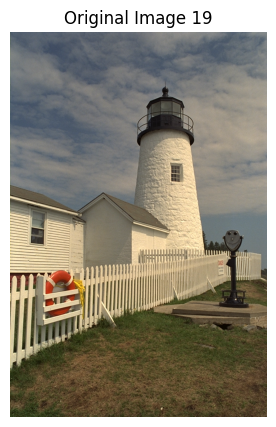

In [8]:
# images19 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[18])
plt.title('Original Image 19')
plt.axis('off')
plt.show()

In [9]:
image_tensor = pipe.feature_extractor(images=images[18], return_tensors="pt").pixel_values.to(device)
latent = pipe.image_encoder(image_tensor).image_embeds

100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


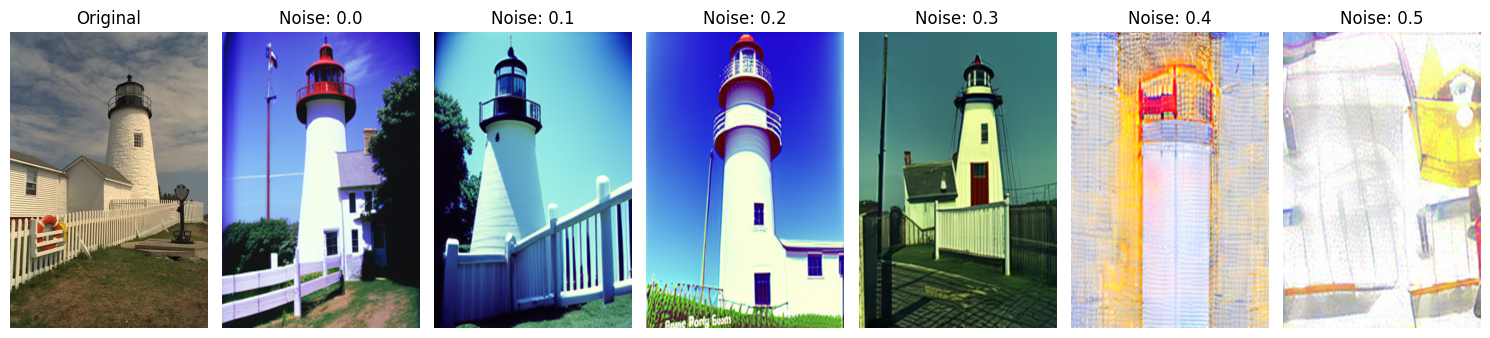

In [12]:
seed = 42
generator = torch.Generator(device=device).manual_seed(seed)

# 가우시안 노이즈의 강도를 다르게 하여 실험 
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(15, 5))

# 원본 이미지의 크기 저장
original_size = images[18].size

# 원본 이미지 표시
plt.subplot(1, len(noise_levels)+1, 1)
plt.imshow(images[18])
plt.title('Original')
plt.axis('off')

for idx, noise_level in enumerate(noise_levels):
    # 원본 latent에 가우시안 노이즈 추가
    noise = torch.randn_like(latent) * noise_level
    noisy_latent = latent + noise
    
    # 노이즈가 추가된 latent로 이미지 생성
    output = pipe(image_embeddings=noisy_latent, generator=generator)
    
    # 생성된 이미지 리사이징
    generated_image = output.images[0].resize(original_size)
    
    # 결과 시각화
    plt.subplot(1, len(noise_levels)+1, idx+2)
    plt.imshow(generated_image)
    plt.title(f'Noise: {noise_level:.1f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### C. Semantic Linearity in CLIP Latent

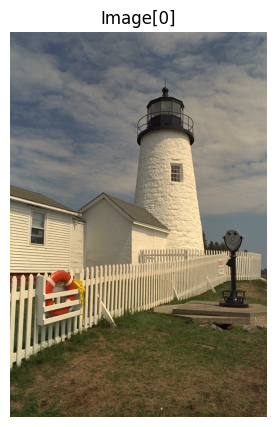

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(images[18])
plt.title('Image[0]')
plt.axis('off')
plt.show()


In [58]:
image = images[18]

image_path = '/app/ICM/SMIC/data/cat.jpg'
add_image = Image.open(image_path)

tensor1 = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
tensor2 = pipe.feature_extractor(images=add_image, return_tensors="pt").pixel_values.to(device)

latent1 = pipe.image_encoder(tensor1).image_embeds
latent2 = pipe.image_encoder(tensor2).image_embeds

100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


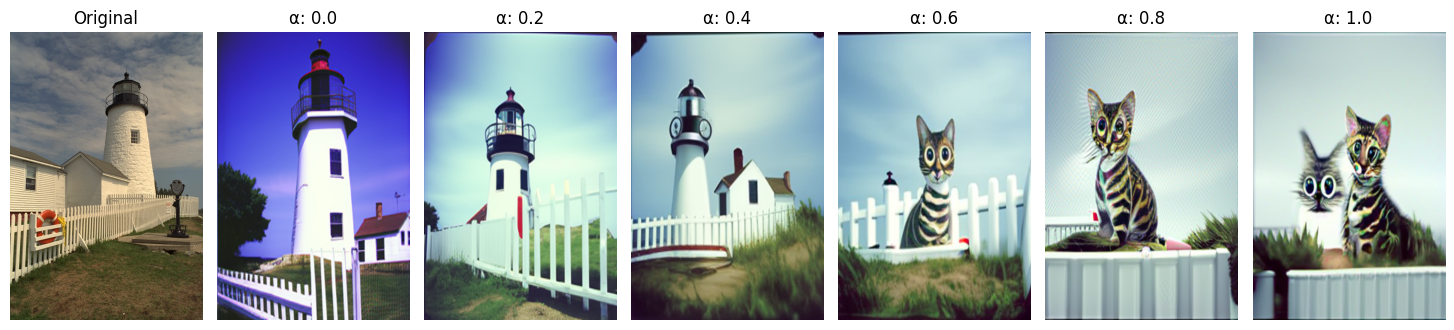

In [59]:
plt.figure(figsize=(25, 5))

# Original image
plt.subplot(1, 12, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

# 원본 이미지 크기 저장
original_size = image.size

seed = 43
generator = torch.Generator(device=device).manual_seed(seed)

# Generate interpolated images
alphas = [i/5 for i in range(0, 6)]  # 0.2 간격으로 수정
for i, alpha in enumerate(alphas):
    # 이미지 임베딩 보간
    # slerp를 사용하되 더해나가는 방식으로 구현
    norm1 = torch.norm(latent1)
    norm2 = torch.norm(latent2)
    normalized1 = latent1 / norm1
    normalized2 = latent2 / norm2
    omega = torch.acos((normalized1 * normalized2).sum())
    latent = latent1 + (torch.sin(alpha * omega) / torch.sin(omega)) * latent2

    output = pipe(image_embeddings=latent, generator=generator)
    generated_image = output.images[0].resize(original_size)
    
    plt.subplot(1, 12, i+2)
    plt.imshow(generated_image)
    plt.title(f'α: {alpha:.1f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### D. SLERP vs LERP

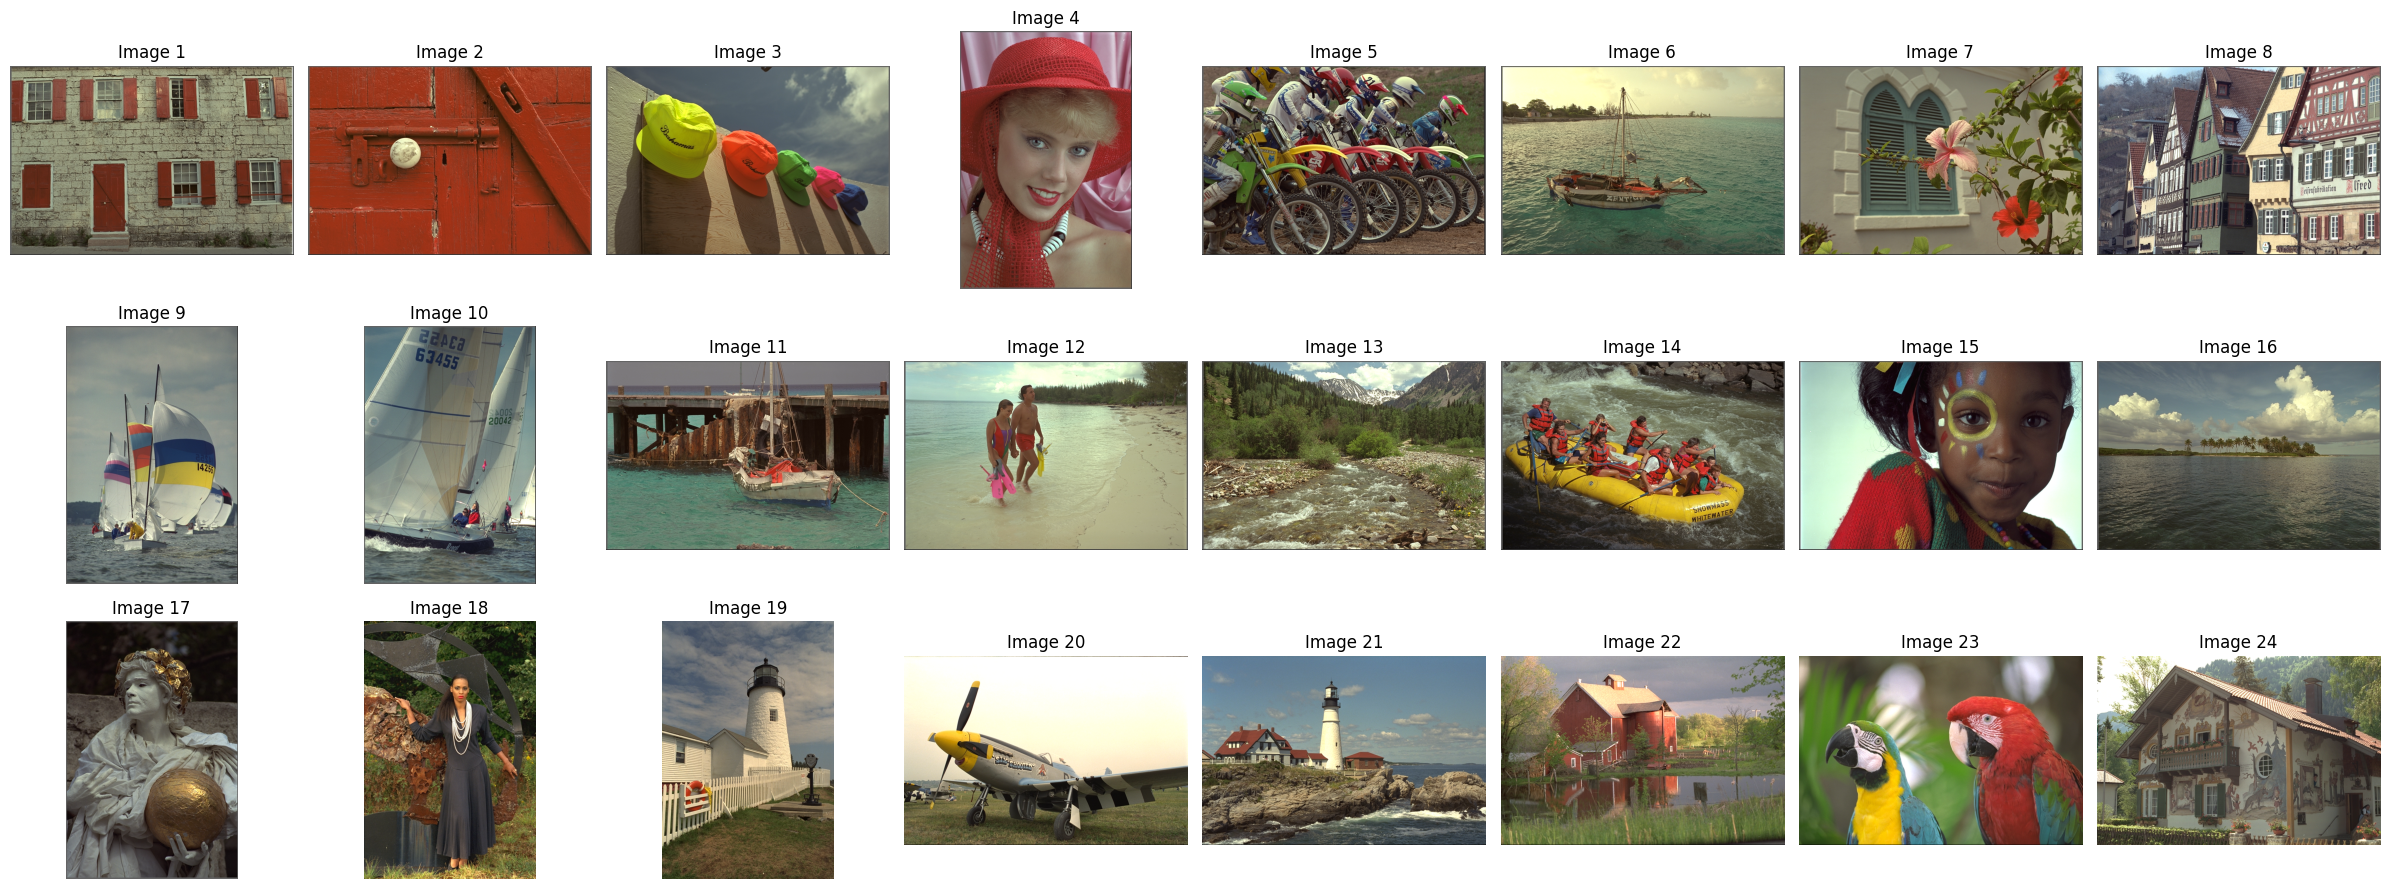

In [62]:
plt.figure(figsize=(24, 9))

for i in range(24):
    plt.subplot(3, 8, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

100%|██████████| 7/7 [00:01<00:00,  5.47it/s]


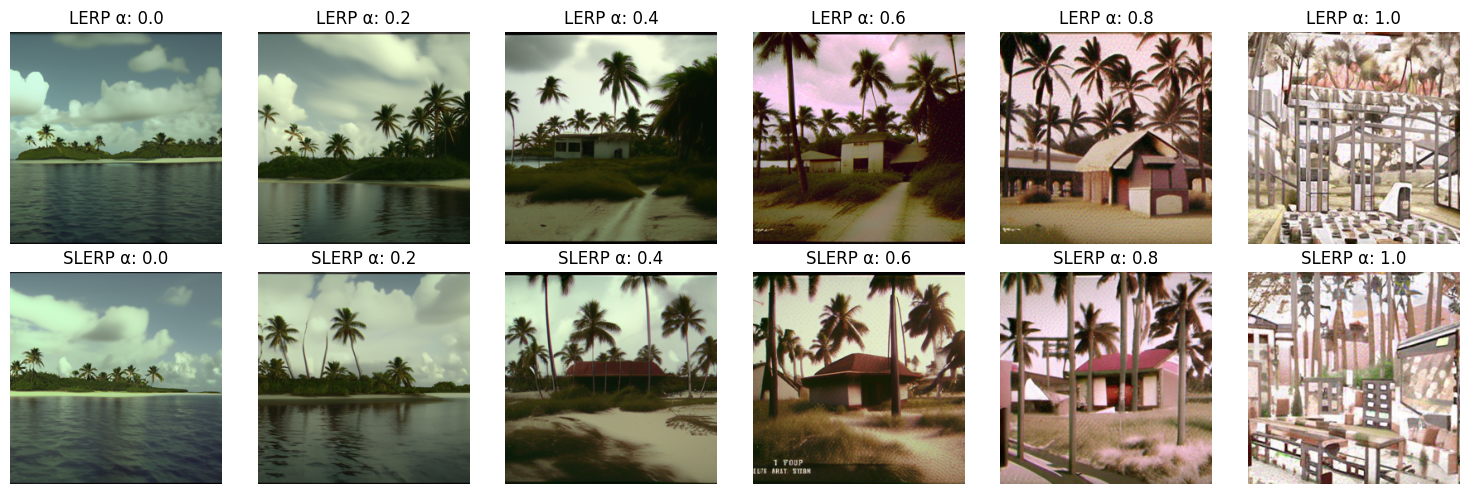

In [64]:
# 이미지 불러오기
image = images[15]
image_path = '/app/ICM/SMIC/data/sea.jpg'
sea_image = Image.open(image_path)

# 이미지 임베딩 얻기
tensor1 = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
tensor2 = pipe.feature_extractor(images=sea_image, return_tensors="pt").pixel_values.to(device)

latent1 = pipe.image_encoder(tensor1).image_embeds
latent2 = pipe.image_encoder(tensor2).image_embeds

# 보간 비율 설정
alphas = [i/5 for i in range(0, 6)]  # 0.2 간격

plt.figure(figsize=(15, 5))

# LERP와 SLERP 결과 비교
for i, alpha in enumerate(alphas):
    # LERP
    lerp_latent = latent1 - alpha * latent2
    
    # SLERP
    norm1 = torch.norm(latent1)
    norm2 = torch.norm(latent2)
    normalized1 = latent1 / norm1
    normalized2 = latent2 / norm2
    omega = torch.acos((normalized1 * normalized2).sum())
    slerp_latent = latent1 - torch.sin(alpha * omega) / torch.sin(omega) * latent2

    # 이미지 생성
    generator = torch.Generator(device=device).manual_seed(42)
    lerp_output = pipe(image_embeddings=lerp_latent, generator=generator)
    slerp_output = pipe(image_embeddings=slerp_latent, generator=generator)

    # LERP 결과 표시
    plt.subplot(2, 6, i+1)
    plt.imshow(lerp_output.images[0])
    plt.title(f'LERP α: {alpha:.1f}')
    plt.axis('off')

    # SLERP 결과 표시 
    plt.subplot(2, 6, i+7)
    plt.imshow(slerp_output.images[0])
    plt.title(f'SLERP α: {alpha:.1f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### D. Semantic Addition and Subtraction

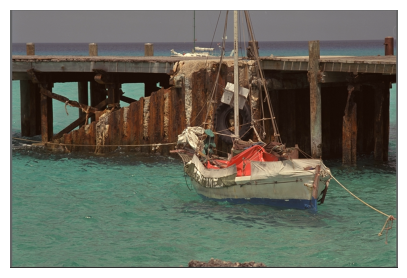

In [66]:
plt.figure(figsize=(5, 5))
plt.imshow(images[10])
plt.axis('off')
plt.show()


100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


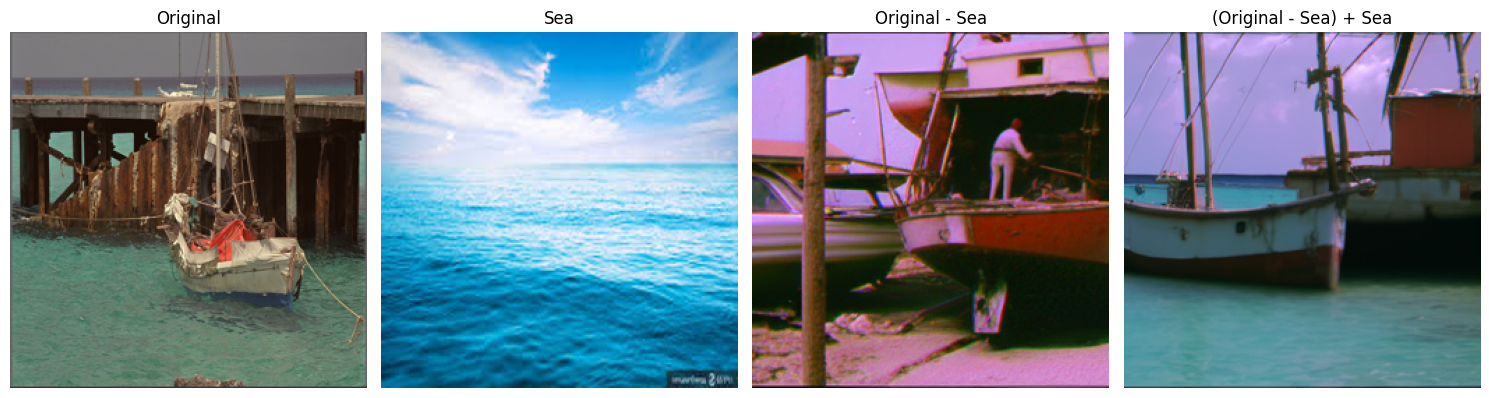

In [67]:
image = images[10]

image_path = '/app/ICM/SMIC/data/sea.jpg'
sea_image = Image.open(image_path)

# 이미지 임베딩 얻기
tensor1 = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
tensor2 = pipe.feature_extractor(images=sea_image, return_tensors="pt").pixel_values.to(device)

latent1 = pipe.image_encoder(tensor1).image_embeds
latent2 = pipe.image_encoder(tensor2).image_embeds

# 이미지 임베딩 뺄셈/덧셈
subtracted_embedding = latent1 - 0.5 * latent2
added_embedding = subtracted_embedding + 0.5 * latent2

plt.figure(figsize=(15, 5))

# 뺄셈 결과
generator = torch.Generator(device=device).manual_seed(42)
output_subtracted = pipe(image_embeddings=subtracted_embedding, generator=generator)

# 덧셈 결과 
generator = torch.Generator(device=device).manual_seed(42)
output_added = pipe(image_embeddings=added_embedding, generator=generator)

# 출력 이미지 크기에 맞춰 원본 이미지들 리사이즈
output_size = output_subtracted.images[0].size
resized_original = image.resize(output_size)
resized_sea = sea_image.resize(output_size)

# 원본 이미지
plt.subplot(1, 4, 1)
plt.imshow(resized_original)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(resized_sea)
plt.title('Sea')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(output_subtracted.images[0])
plt.title('Original - Sea')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(output_added.images[0])
plt.title('(Original - Sea) + Sea')
plt.axis('off')

plt.tight_layout()
plt.show()
